# Overview #

This project is to find the lanes from the video taken from the camera attached to the car using advanced and effective image processing methods.

The raw data can be found from https://github.com/udacity/CarND-Advanced-Lane-Lines


Below is the summary of the process of the project:

1. Calibrate the image using given chessboard images.
1. perform image distortion correction based on calibration matrix.
1. Perform color and gradient transformation to create a thresholded binary image.
1. Apply a birds eye view perspective transform to view the lines as parallel lines.
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Import all necessary packages ####

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
%matplotlib inline

#### Create local directories ####

In [2]:
dirname1 = 'chessboard_corners'
if not os.path.exists(dirname1):
    os.mkdir(dirname1)

dirname2 = 'test_images'
if not os.path.exists(dirname2):
    os.mkdir(dirname2)

dirname3 = 'output_images'
if not os.path.exists(dirname3):
    os.mkdir(dirname3)

#### Load necessary images ####

In [3]:
# Load chessboard images
cal_images = glob.glob('../../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

#Load test images
test_images = glob.glob('../../CarND-Advanced-Lane-Lines/test_images/test*.jpg')

## Camera Calibration ##

In [4]:
def find_corners():
    # Arrays to store object points and image points from all images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # prepare object points
    nx = 9#The number of inside corners in x
    ny = 6#The number of inside corners in y

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates
    for index, fname in enumerate(cal_images):
        #read in each image
        img = mpimg.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            write_name = 'chessboard_corners'+str(index)+'.jpg'
            cv2.imwrite(os.path.join(dirname1,write_name), img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

            # Save the distortion points for later use
            dist_pickle = {}
            dist_pickle["objpoints"] = objpoints
            dist_pickle["imgpoints"] = imgpoints
            pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

    img_size = (img.shape[1], img.shape[0])
    
    #Perform camera calibration given obj points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration_pickle = {}
    calibration_pickle["mtx"] = mtx
    calibration_pickle["dist"] = dist
    pickle.dump( calibration_pickle, open( "calibration_pickle.p", "wb" ) )
    
    cv2.destroyAllWindows()
    cv2.waitKey(1)

## Distortion Correction ##

In [5]:
def undistort_image(img, mtx, dist, debug=False): #objpoints, imgpoints):        
    #img_size = (img.shape[1], img.shape[0])
    
    #Perform camera calibration given obj points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    #undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #write_name = 'test_undist.jpg'
    #cv2.imwrite(os.path.join(dirname3,write_name), undist)
    #cv2.imshow('img', img)
    #cv2.waitKey(500)
    
    #cv2.destroyAllWindows()
    #cv2.waitKey(1)
    if debug:
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=30)
        write_name = 'test_undist_2.jpg'
        temp = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dirname3,write_name), temp)
    
    return undist

In [34]:
find_corners()

### Test calibration by undistorting ###

In [13]:
with open ("dist_pickle.p", "rb") as input_file:
    x = pickle.load(input_file)

objpoints = x['objpoints']
imgpoints = x['imgpoints']

with open ("calibration_pickle.p", "rb") as input_file:
    y = pickle.load(input_file)

mtx = y['mtx']
dist = y['dist']

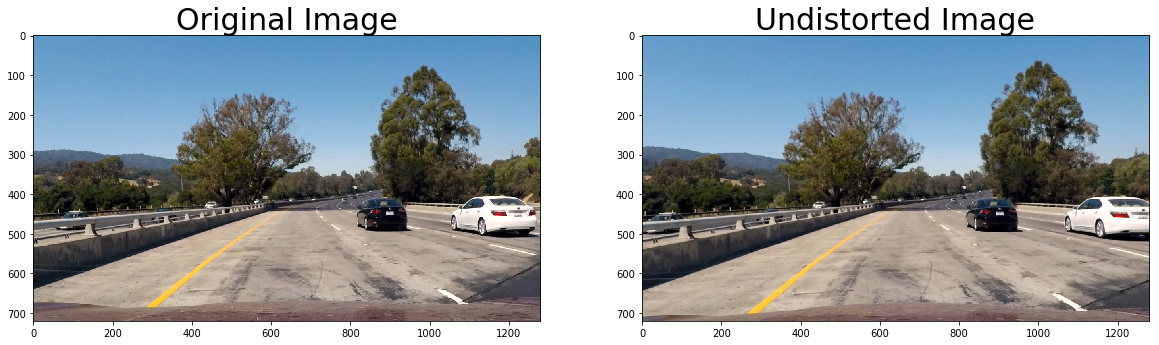

In [63]:
#Test undistortion on a chessboard image
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/camera_cal/calibration2.jpg')
undistort_image(image, mtx, dist, debug=False)

#Test undistortion on a road image
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test1.jpg')
undistorted_image = undistort_image(image, mtx, dist, debug=True)

## Color Thresholding ##

In [6]:
def color_thresholding(img, s_thresh=(0, 255), debug=False):
    """
    Perform color thresholding in s space.
    :img: image input
    :s_thresh: threshold for s space in hls
    :output: combined_binary image
    """
    # convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    #Threshold color channel HLS
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    if debug:
        # Plotting thresholded images
        plt.title('S channel thresholds')
        plt.imshow(s_binary, cmap='gray')
        write_name = 'color_thresh.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), s_binary*255)
    
    return s_binary

### Testing color thresholding after distortion correction ###

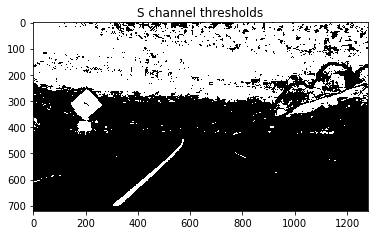

In [42]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255), debug=True)

## Sobel thresholding ##

In [7]:
def abs_sobel_thresholding(img, orientation = 'x', sobel_kernel = 3, thresh = (0,255), debug=False):
    """
    Perform gradient thresholding.
    :img: image input
    :thresh: threshold for sobel
    :orientation: x or y
    :sobel_kernel: kernel size
    :output: binary image
    """
    #Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orientation == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) #Take the derivative in x
        abs_sobel = np.absolute(sobel)
    elif orientation == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) #Take the derivative in y
        abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Threshold x gradient
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    if debug:
        # Plotting thresholded images
        plt.title('Sobel thresholds')
        plt.imshow(binary, cmap='gray')
        write_name = 'sobel_thresh.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), binary*255)
    return binary

### Testing sobel thresholding after distortion correction ###

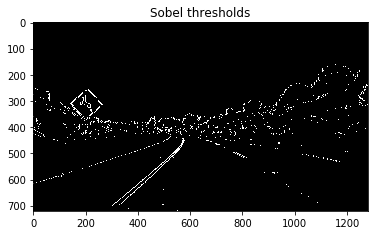

In [44]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(40,255), debug=True)

### Testing sobel thresholding and color thresholding ###

True

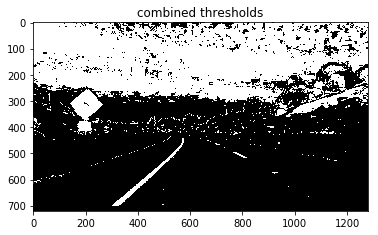

In [45]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255
plt.title('combined thresholds')
plt.imshow(combined_image, cmap = 'gray')

write_name = 'combined_thresh.jpg'
cv2.imwrite(os.path.join(dirname3,write_name), combined_image)

## Perspective Transform ##

In [8]:
def perspective_transform(img, mtx, dist, debug=False):
    """
    Pass in the image into this function to perform undistortion
    and perspective transformation.
    :img: image input
    :nx: number if inside corners in x
    :ny: number of inside corners in y
    :mtx: camera matrix
    :dist: distortion coefficient
    :output: warped iamge and transform matrix
    """
    img_size = (img.shape[1], img.shape[0])
    
    # Source points for perspective transformation
    top_right_src = [585. /1280.*img_size[0], 455./720.*img_size[1]]
    top_left_src = [705. /1280.*img_size[0], 455./720.*img_size[1]]
    bottom_right_src = [1270./1280.*img_size[0], 700./720.*img_size[1]]
    bottom_left_src = [190. /1280.*img_size[0], 700./720.*img_size[1]]
    
    # src coordinates
    src = np.float32([
        top_right_src, # top right
        bottom_right_src, # bottom right
        bottom_left_src, # bottom left
        top_left_src # top left
    ])
    
    # Stretch it into a square
    top_right_dest = [300. /1280.*img_size[0], 0./720.*img_size[1]]
    top_left_dest = [1000./1280.*img_size[0], 0./720.*img_size[1]]
    bottom_right_dest = [1000./1280.*img_size[0], 720./720.*img_size[1]]
    bottom_left_dest = [300. /1280.*img_size[0], 720./720.*img_size[1]]
    
    # dest coordinates
    dst = np.float32([
        top_right_dest, # top right
        bottom_right_dest, # bottom right
        bottom_left_dest, # bottom left
        top_left_dest # top left
    ])

    if(debug):
        plt.title('viewing sorce and dst points')
        plt.imshow(img, cmap='gray')
        plt.plot(src[0][0], src[0][1], 'o')
        plt.plot(src[1][0], src[1][1], 'o')
        plt.plot(src[2][0], src[2][1], 'o')
        plt.plot(src[3][0], src[3][1], 'o')

        plt.plot(dst[0][0], dst[0][1], 'o')
        plt.plot(dst[1][0], dst[1][1], 'o')
        plt.plot(dst[2][0], dst[2][1], 'o')
        plt.plot(dst[3][0], dst[3][1], 'o')
        plt.show()
    # Get perspective transformation matrix
    M = cv2.getPerspectiveTransform( src, dst)
    
    # Get inverse perspective Transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp the image to get birds eye view
    warped = cv2.warpPerspective(img, M, img_size, 
                                 flags = cv2.INTER_LINEAR)

    return warped, M, Minv

### Test perspective transform after distortion correction and thresholding ###

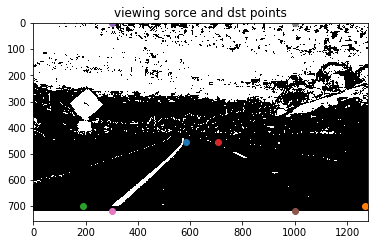

True

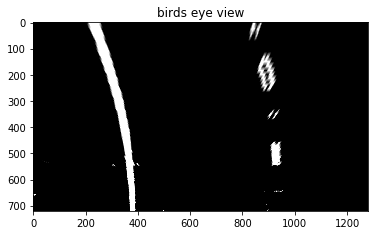

In [47]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist, debug=True)
plt.title('birds eye view')
plt.imshow(warped, cmap='gray')
write_name = 'birds_eye_view.jpg'
cv2.imwrite(os.path.join(dirname3,write_name), warped)

## Lane identification and fit poly line ##

In [61]:
def find_lane(img, nwindows = 9, debug = False):
    """
    This function accepts a binary warped image and returns 
    an image with lane line windows.
    :binary_warped: Input image
    :nwindows: number of sliding windows default is 9
    :output: image with lane line windows.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    # create an output image to draw on and visualize the result
    out_image = np.dstack((img, img, img)) *255
    
    # find the peaks of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # set the height of the windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify x and y positions of all non zero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # current positions
    left_current = left_base
    right_current = right_base
    
    # set the width of the windows
    margin = 100
    
    #set minimum number of pixels found to recenter window
    minpix = 50
    
    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # step through the windows one by one
    for window in range(nwindows):
        #Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_current - margin
        win_xleft_high = left_current + margin
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_image,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_image,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #if(debug):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if(debug):
        plt.imshow(out_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        write_name = 'Window_lane_finding.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), out_image)

    return out_image, left_fit, right_fit, left_fitx, right_fitx

### Test lane line finding ###

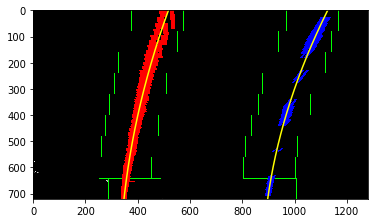

In [62]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test3.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist)
output, left, right, leftx, rightx = find_lane(warped, debug=True)

## Determine the curvature of the lane and position error ##

In [63]:
def computePositionError(left, right, imgWidth, debug=False):
    
    xLaneCenter = (right[0] + left[0]) / 2
    
    if debug:
        print("ImgWidth = %d" % (imgWidth))
        print("X-Lane Center = %d px" % (xLaneCenter))
    
    # Compute the difference between the computed lane center and the center of image.
    positionErrorPx = xLaneCenter - imgWidth/2
    
    # Convert the pixel difference into real-space (meters)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    posError = positionErrorPx * xm_per_pix
    
    if debug:
        print("posError = %d" % (posError))
        print("positionErrorPx = %d" % (positionErrorPx))
    return posError, positionErrorPx

In [64]:
def measure_curvature(leftx, rightx, pixel=False, debug=False):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if(debug):
        # Plot up the fake data
        mark_size = 3
        plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
        plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    if(pixel):
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        print(left_curverad, right_curverad)
    else:
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
    return ([left_curverad, right_curverad], ploty)

SyntaxError: invalid syntax (<ipython-input-64-75648ac9593f>, line 43)

### Test curvature ###

In [ ]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test4.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist)
output, left, right, leftx, rightx = find_lane(warped)

computePositionError(leftx, rightx, warped.shape[1], debug=True)

curve, ploty = measure_curvature(left, right, debug=True)

## Warp the detected lane boundaries back onto the original image. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position. ##

In [28]:
def draw_lines_on_road(raw_image, warped, Minv, left_fitx, right_fitx, ploty, debug=False):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (raw_image.shape[1], raw_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(raw_image, 1, newwarp, 0.3, 0)
    if (debug):
        plt.imshow(result)
        write_name = 'detected_lane_mask.jpg'
        temp = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dirname3,write_name), temp)
    return result

524.633583357 m 575.015511623 m


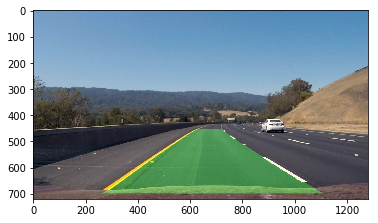

In [29]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test3.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist)
output, left, right, leftx, rightx = find_lane(warped)

curve, ploty = measure_curvature(left, right)

result = draw_lines_on_road(image, warped, inv_mtx, leftx, rightx, ploty, debug=True)

## Line class ##

In the block below, I define a Line class based on the Udacity-provided class. The class will fit a curve to the median of the previous N sets of lane keypoints.

In [56]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Pipeline ##

In [55]:
def Pipeline(image, mtx, dist, debug=False):
    #Resize image for consistency
    img= cv2.resize(image, (1280,720))
    
    #Correct for distortion
    undistorted_image = undistort_image(img, mtx, dist)
    
    #Apply color and sobel thresholds then combine them
    color = color_thresholding(undistorted_image, s_thresh=(100,255), debug=debug)
    sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255), debug=debug)

    combined_image = np.zeros_like(image[:,:,0])
    combined_image[((sobel_x == 1) | (color == 1))] = 255
    
    #Perform perspective transformation
    warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist, debug=debug)
    
    #Find lane lines
    output, left, right, leftx, rightx = find_lane(warped, debug=debug)
    
     # Compute the position error (off centerline)
    posError, posErrorPx = computePositionError(leftx, rightx, warped.shape[1])    
    
    #Compute curvature.
    curve, ploty = measure_curvature(left, right, debug=debug)
    
    #draw polygon on original image
    origImgWithOverlay = draw_lines_on_road(image, warped, inv_mtx, leftx, rightx, ploty, debug=debug)
    
    # Draw text on the screen (in unwarped image space).  Show position error and left/right curvature values.
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    posErrorString = "Pos Error = %6.2f m" % (posError)
    cv2.putText(origImgWithOverlay, posErrorString,(50,50), font, 1, (255,255,255),2)
    
    leftLaneCurvStr = "Left Curv = %6.2f m" % (curve[0])
    rightLaneCurvStr = "Right Curv = %6.2f m" % (curve[1])
    cv2.putText(origImgWithOverlay, leftLaneCurvStr,(50,100), font, 1, (255,255,255),2)
    cv2.putText(origImgWithOverlay, rightLaneCurvStr,(50,150), font, 1, (255,255,255),2)
    
    if debug:
        write_name = 'Pipeline_result.jpg'
        temp = cv2.cvtColor(origImgWithOverlay, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dirname3,write_name), temp)
    return origImgWithOverlay                                                                       

In [56]:
def Process_image(image, debug=False):
    return (Pipeline(image, mtx, dist, debug))

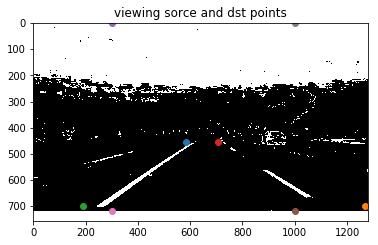

578.357215923 m 490.984326114 m


array([[[183, 202, 208],
        [138, 158, 167],
        [127, 150, 166],
        ..., 
        [ 34,  71,  98],
        [  3,  35,  56],
        [ 18,  49,  67]],

       [[140, 160, 169],
        [137, 159, 172],
        [132, 157, 177],
        ..., 
        [ 90, 131, 161],
        [ 55,  91, 115],
        [  2,  34,  55]],

       [[131, 154, 170],
        [135, 160, 180],
        [121, 149, 173],
        ..., 
        [ 97, 141, 176],
        [ 92, 133, 163],
        [ 33,  73,  99]],

       ..., 
       [[131, 116, 113],
        [105,  90,  87],
        [ 98,  83,  80],
        ..., 
        [ 78,  67,  65],
        [ 91,  80,  78],
        [129, 118, 116]],

       [[147, 133, 130],
        [126, 111, 108],
        [105,  90,  87],
        ..., 
        [ 84,  73,  71],
        [119, 108, 106],
        [145, 134, 132]],

       [[155, 141, 138],
        [122, 108, 105],
        [113,  98,  95],
        ..., 
        [123, 112, 110],
        [142, 132, 130],
        [190, 180,

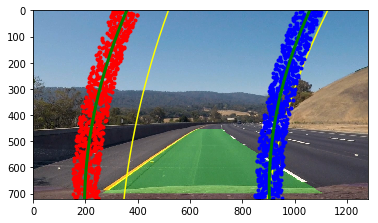

In [57]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test3.jpg')
Process_image(image, debug=True)

I implemented this frame grabber after running the project video through my pipeline. I noticed that when there is shadow on the road the algorithm struggles. So I wanted to extract the frames and run one frame with the shadow through the pipeline.

In [30]:
"""
Frame grabber
http://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
"""
vidcap = cv2.VideoCapture("../../CarND-Advanced-Lane-Lines/project_video.mp4")
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite(os.path.join(dirname2,"frame%d.jpg" % count), image)     # save frame as JPEG file
    count += 1
print("Complete!")

Complete!


Running the frame with shadow of tree on the road to see how the algorithm performs. Particularly the lane finding.

530.331166218 m 507.142896347 m


array([[[ 70,  65,  46],
        [ 65,  60,  41],
        [ 55,  52,  33],
        ..., 
        [ 73,  73,  37],
        [ 72,  72,  34],
        [ 72,  72,  34]],

       [[ 60,  55,  36],
        [ 59,  54,  35],
        [ 54,  49,  30],
        ..., 
        [ 75,  75,  39],
        [ 72,  72,  34],
        [ 72,  70,  32]],

       [[ 55,  50,  30],
        [ 55,  50,  30],
        [ 52,  47,  27],
        ..., 
        [ 75,  72,  37],
        [ 74,  72,  34],
        [ 74,  72,  34]],

       ..., 
       [[101,  81,  80],
        [100,  80,  79],
        [ 99,  79,  78],
        ..., 
        [112,  94,  92],
        [112,  94,  92],
        [112,  94,  92]],

       [[100,  80,  79],
        [100,  80,  79],
        [100,  80,  79],
        ..., 
        [115,  97,  95],
        [115,  97,  95],
        [115,  97,  95]],

       [[101,  81,  80],
        [101,  81,  80],
        [101,  81,  80],
        ..., 
        [115,  97,  95],
        [115,  97,  95],
        [116,  98,

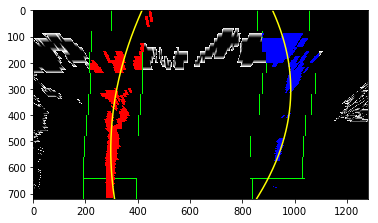

In [34]:
testing = mpimg.imread('test_images/frame1026.jpg')
Process_image(testing)

As we can see here, the curvature is drastically skewed because the shadow masks the lane line. We can try to perform some sort of shadow removal.

In [58]:
challenge_output = 'Project_video_output.mp4'
clip1 = VideoFileClip("../../CarND-Advanced-Lane-Lines/project_video.mp4")
challenge_clip = clip1.fl_image(Process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

573.43915912 m 573.508614365 m
[MoviePy] >>>> Building video Project_video_output.mp4
[MoviePy] Writing video Project_video_output.mp4


  0%|          | 1/1261 [00:00<02:54,  7.20it/s]

556.555256695 m 530.937436101 m


  0%|          | 2/1261 [00:00<02:56,  7.15it/s]

541.582562181 m 599.673892845 m


  0%|          | 3/1261 [00:00<02:55,  7.16it/s]

504.803163613 m 649.20913951 m


  0%|          | 4/1261 [00:00<02:54,  7.19it/s]

583.107701883 m 596.923676354 m


  0%|          | 5/1261 [00:00<02:55,  7.17it/s]

539.591528225 m 554.596836753 m


  0%|          | 6/1261 [00:00<02:53,  7.23it/s]

522.536777195 m 487.917201952 m


  1%|          | 7/1261 [00:00<02:53,  7.25it/s]

468.205345672 m 556.276168934 m


  1%|          | 8/1261 [00:01<02:51,  7.29it/s]

534.738720167 m 516.441231074 m


  1%|          | 9/1261 [00:01<02:49,  7.40it/s]

635.034328611 m 549.75420674 m


  1%|          | 10/1261 [00:01<02:54,  7.19it/s]

530.062117126 m 568.60456177 m


  1%|          | 11/1261 [00:01<02:56,  7.08it/s]

539.296408762 m 544.622055966 m


  1%|          | 12/1261 [00:01<03:00,  6.91it/s]

469.462018701 m 560.899329714 m


  1%|          | 13/1261 [00:01<03:00,  6.90it/s]

525.229499026 m 499.581656477 m


  1%|          | 14/1261 [00:01<02:59,  6.93it/s]

549.363394622 m 548.848230189 m


  1%|          | 15/1261 [00:02<02:56,  7.06it/s]

503.343101861 m 580.835841122 m


  1%|▏         | 16/1261 [00:02<02:54,  7.12it/s]

566.441066395 m 521.602220854 m


  1%|▏         | 17/1261 [00:02<02:54,  7.14it/s]

511.498633656 m 572.925705452 m


  1%|▏         | 18/1261 [00:02<02:51,  7.26it/s]

541.47338164 m 546.622679233 m


  2%|▏         | 19/1261 [00:02<02:51,  7.26it/s]

467.829834371 m 521.360282885 m


  2%|▏         | 20/1261 [00:02<02:50,  7.29it/s]

557.934701911 m 628.505714513 m


  2%|▏         | 21/1261 [00:02<02:49,  7.30it/s]

489.889246287 m 548.655791716 m


  2%|▏         | 22/1261 [00:03<02:52,  7.17it/s]

527.600993859 m 620.726241415 m


  2%|▏         | 23/1261 [00:03<02:53,  7.14it/s]

546.998623499 m 592.685681791 m


  2%|▏         | 24/1261 [00:03<02:52,  7.18it/s]

591.343734762 m 511.413570568 m


  2%|▏         | 25/1261 [00:03<02:54,  7.07it/s]

562.072422918 m 554.288278515 m


  2%|▏         | 26/1261 [00:03<02:58,  6.92it/s]

580.631091779 m 532.924595984 m


  2%|▏         | 27/1261 [00:03<02:57,  6.96it/s]

564.457469859 m 471.903077602 m


  2%|▏         | 28/1261 [00:03<02:52,  7.13it/s]

600.307727364 m 624.019204085 m


  2%|▏         | 29/1261 [00:04<02:49,  7.28it/s]

499.641306268 m 536.1647404 m


  2%|▏         | 30/1261 [00:04<02:48,  7.30it/s]

503.634605997 m 613.183617768 m


  2%|▏         | 31/1261 [00:04<02:50,  7.21it/s]

492.814144787 m 561.891634478 m


  3%|▎         | 32/1261 [00:04<02:50,  7.19it/s]

556.257628216 m 554.211409286 m


  3%|▎         | 33/1261 [00:04<02:49,  7.24it/s]

522.463313691 m 545.095695979 m


  3%|▎         | 34/1261 [00:04<02:49,  7.25it/s]

483.052810734 m 565.656879035 m


  3%|▎         | 35/1261 [00:04<02:48,  7.28it/s]

622.59624145 m 570.728822351 m


  3%|▎         | 36/1261 [00:05<02:49,  7.22it/s]

523.665725027 m 611.915004269 m


  3%|▎         | 37/1261 [00:05<02:50,  7.16it/s]

570.445862371 m 515.69541488 m


  3%|▎         | 38/1261 [00:05<02:50,  7.17it/s]

522.709308225 m 503.393464628 m


  3%|▎         | 39/1261 [00:05<02:49,  7.22it/s]

530.340389547 m 608.171911116 m


  3%|▎         | 40/1261 [00:05<02:48,  7.27it/s]

553.065535063 m 617.333183766 m


  3%|▎         | 41/1261 [00:05<02:46,  7.32it/s]

539.778060675 m 722.869431677 m


  3%|▎         | 42/1261 [00:05<02:44,  7.41it/s]

493.550309071 m 599.676199984 m


  3%|▎         | 43/1261 [00:05<02:51,  7.09it/s]

548.672324273 m 503.894760098 m


  3%|▎         | 44/1261 [00:06<02:52,  7.05it/s]

460.289859702 m 585.021153501 m


  4%|▎         | 45/1261 [00:06<02:52,  7.06it/s]

525.145072611 m 629.536744315 m


  4%|▎         | 46/1261 [00:06<02:49,  7.16it/s]

550.171225719 m 674.469361258 m


  4%|▎         | 47/1261 [00:06<02:46,  7.28it/s]

516.918668517 m 513.180320784 m


  4%|▍         | 48/1261 [00:06<02:43,  7.40it/s]

603.023274629 m 524.995900344 m


  4%|▍         | 49/1261 [00:06<02:42,  7.45it/s]

533.921711701 m 562.587731017 m


  4%|▍         | 50/1261 [00:06<02:40,  7.54it/s]

508.547633199 m 586.704264126 m


  4%|▍         | 51/1261 [00:07<02:41,  7.47it/s]

547.081887455 m 534.158076899 m


  4%|▍         | 52/1261 [00:07<02:41,  7.48it/s]

512.619149087 m 518.194703057 m


  4%|▍         | 53/1261 [00:07<02:46,  7.25it/s]

543.775413368 m 556.018001175 m


  4%|▍         | 54/1261 [00:07<02:48,  7.18it/s]

518.764048054 m 532.063934863 m


  4%|▍         | 55/1261 [00:07<02:47,  7.20it/s]

533.401395872 m 470.283898239 m


  4%|▍         | 56/1261 [00:07<02:46,  7.26it/s]

537.536635205 m 602.949799117 m


  5%|▍         | 57/1261 [00:07<02:44,  7.31it/s]

613.183782227 m 500.278008772 m


  5%|▍         | 58/1261 [00:08<02:43,  7.35it/s]

530.44283351 m 634.673135751 m


  5%|▍         | 59/1261 [00:08<02:44,  7.29it/s]

616.815124699 m 561.910011468 m


  5%|▍         | 60/1261 [00:08<02:43,  7.33it/s]

594.033919158 m 536.132409761 m


  5%|▍         | 61/1261 [00:08<02:44,  7.31it/s]

511.809471618 m 536.355867541 m


  5%|▍         | 62/1261 [00:08<02:45,  7.27it/s]

533.47245573 m 593.379337583 m


  5%|▍         | 63/1261 [00:08<02:51,  6.97it/s]

529.84818865 m 505.347160533 m


  5%|▌         | 64/1261 [00:08<03:00,  6.62it/s]

652.75182302 m 586.30217178 m


  5%|▌         | 65/1261 [00:09<03:04,  6.49it/s]

628.462317175 m 447.87112143 m


  5%|▌         | 66/1261 [00:09<03:00,  6.63it/s]

582.583724829 m 549.160193931 m


  5%|▌         | 67/1261 [00:09<03:00,  6.62it/s]

468.064363801 m 562.860026958 m


  5%|▌         | 68/1261 [00:09<03:00,  6.61it/s]

525.222598232 m 504.302527194 m


  5%|▌         | 69/1261 [00:09<03:01,  6.56it/s]

615.523457186 m 509.989376245 m


  6%|▌         | 70/1261 [00:09<02:59,  6.63it/s]

586.347622229 m 576.08148988 m


  6%|▌         | 71/1261 [00:09<03:00,  6.61it/s]

547.216255226 m 656.246626682 m


  6%|▌         | 72/1261 [00:10<02:55,  6.76it/s]

555.109117905 m 543.491937182 m


  6%|▌         | 73/1261 [00:10<02:53,  6.84it/s]

604.308665256 m 527.539037827 m


  6%|▌         | 74/1261 [00:10<02:49,  6.99it/s]

502.949108685 m 681.250866272 m


  6%|▌         | 75/1261 [00:10<02:49,  7.00it/s]

588.487396439 m 505.180203727 m


  6%|▌         | 76/1261 [00:10<02:54,  6.78it/s]

597.554601413 m 494.810290569 m


  6%|▌         | 77/1261 [00:10<02:57,  6.66it/s]

526.372758652 m 614.68623256 m


  6%|▌         | 78/1261 [00:11<02:56,  6.71it/s]

475.222597047 m 574.017288907 m


  6%|▋         | 79/1261 [00:11<02:59,  6.57it/s]

526.654113038 m 593.216217263 m


  6%|▋         | 80/1261 [00:11<02:53,  6.81it/s]

517.739640025 m 515.957694489 m


  6%|▋         | 81/1261 [00:11<02:51,  6.87it/s]

513.21327035 m 499.318926574 m


  7%|▋         | 82/1261 [00:11<02:46,  7.07it/s]

550.53829961 m 566.08899318 m


  7%|▋         | 83/1261 [00:11<02:43,  7.19it/s]

485.629008926 m 575.842162285 m


  7%|▋         | 84/1261 [00:11<02:40,  7.32it/s]

545.274427269 m 512.55329687 m


  7%|▋         | 85/1261 [00:11<02:46,  7.08it/s]

655.568574162 m 533.185901201 m


  7%|▋         | 86/1261 [00:12<02:49,  6.92it/s]

603.444932516 m 492.122451423 m


  7%|▋         | 87/1261 [00:12<02:51,  6.84it/s]

525.850174482 m 563.10450926 m


  7%|▋         | 88/1261 [00:12<02:56,  6.65it/s]

657.236059364 m 489.954869518 m


  7%|▋         | 89/1261 [00:12<02:54,  6.70it/s]

524.472036025 m 503.517780632 m


  7%|▋         | 90/1261 [00:12<02:50,  6.87it/s]

488.489456258 m 533.112707646 m


  7%|▋         | 91/1261 [00:12<02:51,  6.80it/s]

566.740133542 m 496.505876774 m


  7%|▋         | 92/1261 [00:13<02:49,  6.89it/s]

500.488400911 m 590.248289085 m


  7%|▋         | 93/1261 [00:13<02:42,  7.18it/s]

524.818377231 m 583.58012365 m


  7%|▋         | 94/1261 [00:13<02:35,  7.49it/s]

477.58730619 m 491.199907068 m


  8%|▊         | 95/1261 [00:13<02:35,  7.50it/s]

533.929245205 m 512.226849954 m


  8%|▊         | 96/1261 [00:13<02:37,  7.41it/s]

530.660192205 m 636.166386951 m


  8%|▊         | 97/1261 [00:13<02:33,  7.60it/s]

539.67376177 m 527.390910627 m


  8%|▊         | 98/1261 [00:13<02:29,  7.80it/s]

536.733584584 m 519.81448812 m


  8%|▊         | 99/1261 [00:13<02:27,  7.90it/s]

472.170860508 m 534.320103383 m


  8%|▊         | 100/1261 [00:14<02:29,  7.76it/s]

518.551349431 m 525.68554901 m


  8%|▊         | 101/1261 [00:14<02:29,  7.76it/s]

548.019487641 m 500.31265954 m


  8%|▊         | 102/1261 [00:14<02:29,  7.75it/s]

524.00942205 m 514.03038939 m


  8%|▊         | 103/1261 [00:14<02:33,  7.53it/s]

597.352146246 m 521.821754267 m


  8%|▊         | 104/1261 [00:14<02:37,  7.37it/s]

517.386950242 m 546.111688007 m


  8%|▊         | 105/1261 [00:14<02:40,  7.18it/s]

522.542047864 m 536.079749857 m


  8%|▊         | 106/1261 [00:14<02:34,  7.47it/s]

644.575626955 m 648.898214584 m


  8%|▊         | 107/1261 [00:14<02:32,  7.56it/s]

600.820529505 m 562.738695801 m


  9%|▊         | 108/1261 [00:15<02:33,  7.50it/s]

534.601495898 m 555.131140633 m


  9%|▊         | 109/1261 [00:15<02:33,  7.49it/s]

495.094780164 m 514.030912268 m


  9%|▊         | 110/1261 [00:15<02:33,  7.49it/s]

535.904765147 m 607.302787787 m


  9%|▉         | 111/1261 [00:15<02:36,  7.35it/s]

574.701475322 m 567.948396829 m


  9%|▉         | 112/1261 [00:15<02:35,  7.40it/s]

658.559879618 m 585.446641662 m


  9%|▉         | 113/1261 [00:15<02:35,  7.39it/s]

510.222131926 m 494.215079882 m


  9%|▉         | 114/1261 [00:15<02:35,  7.36it/s]

520.293106007 m 503.105723256 m


  9%|▉         | 115/1261 [00:16<02:39,  7.20it/s]

614.867152911 m 502.418939393 m


  9%|▉         | 116/1261 [00:16<02:39,  7.17it/s]

552.744219673 m 651.615241124 m


  9%|▉         | 117/1261 [00:16<02:39,  7.15it/s]

531.783784794 m 618.78955771 m


  9%|▉         | 118/1261 [00:16<02:40,  7.13it/s]

573.362848014 m 525.606711864 m


  9%|▉         | 119/1261 [00:16<02:38,  7.21it/s]

558.926371618 m 540.848349538 m


 10%|▉         | 120/1261 [00:16<02:36,  7.28it/s]

657.5434843 m 480.54398612 m


 10%|▉         | 121/1261 [00:16<02:38,  7.21it/s]

574.145966635 m 539.53977847 m


 10%|▉         | 122/1261 [00:17<02:38,  7.20it/s]

505.608336165 m 477.690219015 m


 10%|▉         | 123/1261 [00:17<02:42,  7.01it/s]

606.956572181 m 522.442416539 m


 10%|▉         | 124/1261 [00:17<02:49,  6.70it/s]

501.790696609 m 511.715162271 m


 10%|▉         | 125/1261 [00:17<02:48,  6.73it/s]

590.092105988 m 632.856198223 m


 10%|▉         | 126/1261 [00:17<02:42,  7.00it/s]

539.404934518 m 501.367909591 m


 10%|█         | 127/1261 [00:17<02:38,  7.14it/s]

532.004968365 m 486.512704298 m


 10%|█         | 128/1261 [00:17<02:37,  7.21it/s]

601.98050481 m 543.814503481 m


 10%|█         | 129/1261 [00:18<02:37,  7.18it/s]

587.68493112 m 511.565255711 m


 10%|█         | 130/1261 [00:18<02:37,  7.18it/s]

537.501196586 m 560.176103475 m


 10%|█         | 131/1261 [00:18<02:34,  7.30it/s]

497.142656172 m 542.784753908 m


 10%|█         | 132/1261 [00:18<02:33,  7.34it/s]

515.690940079 m 476.163020932 m


 11%|█         | 133/1261 [00:18<02:33,  7.35it/s]

630.381530389 m 524.473612676 m


 11%|█         | 134/1261 [00:18<02:44,  6.83it/s]

506.351962753 m 513.615107982 m


 11%|█         | 136/1261 [00:19<03:00,  6.22it/s]

583.251878107 m 561.684523975 m
543.477914822 m 589.773486979 m


 11%|█         | 138/1261 [00:19<02:47,  6.71it/s]

613.919392579 m 501.928819244 m
604.343844384 m 493.318466329 m


 11%|█         | 140/1261 [00:19<02:44,  6.83it/s]

509.729950603 m 468.348033034 m
597.006343157 m 533.551419126 m


 11%|█▏        | 142/1261 [00:19<02:39,  7.00it/s]

570.325448564 m 512.753859609 m
618.666071966 m 558.024479498 m


 11%|█▏        | 144/1261 [00:20<02:36,  7.16it/s]

511.470637005 m 607.926453275 m
487.282765802 m 477.726253872 m


 12%|█▏        | 146/1261 [00:20<02:32,  7.32it/s]

549.849014646 m 551.769119095 m
599.390990878 m 534.200156031 m


 12%|█▏        | 148/1261 [00:20<02:29,  7.46it/s]

510.712579337 m 623.18379909 m
549.453656011 m 633.945157294 m


 12%|█▏        | 150/1261 [00:21<02:27,  7.55it/s]

559.364857493 m 538.437407768 m
559.716335072 m 563.341521434 m


 12%|█▏        | 152/1261 [00:21<02:28,  7.47it/s]

559.569447842 m 514.442491716 m
540.800421308 m 472.504155642 m


 12%|█▏        | 154/1261 [00:21<02:29,  7.42it/s]

684.763444479 m 553.346580205 m
508.542251117 m 592.977608498 m


 12%|█▏        | 156/1261 [00:21<02:26,  7.54it/s]

510.596742303 m 503.037724398 m
516.526178724 m 629.811027563 m


 13%|█▎        | 158/1261 [00:22<02:23,  7.70it/s]

536.677299833 m 541.541755416 m
595.508770688 m 560.925566086 m


 13%|█▎        | 160/1261 [00:22<02:30,  7.29it/s]

571.223835491 m 599.473166249 m
554.61232446 m 505.197265264 m


 13%|█▎        | 162/1261 [00:22<02:29,  7.36it/s]

594.633143081 m 485.664178679 m
565.760098015 m 638.35232588 m


 13%|█▎        | 164/1261 [00:22<02:39,  6.86it/s]

515.745291289 m 498.84185667 m
574.74117414 m 680.193019948 m


 13%|█▎        | 166/1261 [00:23<02:36,  6.99it/s]

509.007024882 m 510.808578013 m
602.83234421 m 561.923983189 m


 13%|█▎        | 168/1261 [00:23<02:29,  7.29it/s]

616.026476853 m 596.245167519 m
585.385888555 m 550.332947718 m


 13%|█▎        | 170/1261 [00:23<02:27,  7.41it/s]

548.030925888 m 532.357389882 m
603.041375088 m 583.526415105 m


 14%|█▎        | 172/1261 [00:24<02:27,  7.37it/s]

514.23320621 m 534.755440515 m
625.903780177 m 484.09516446 m


 14%|█▍        | 174/1261 [00:24<02:27,  7.37it/s]

538.036449539 m 534.822647026 m
518.103482211 m 585.073776762 m


 14%|█▍        | 176/1261 [00:24<02:23,  7.56it/s]

481.802434609 m 505.54190737 m
600.29361881 m 575.088552717 m


 14%|█▍        | 178/1261 [00:24<02:20,  7.71it/s]

544.422309549 m 486.385971599 m
582.504319367 m 541.293467345 m


 14%|█▍        | 180/1261 [00:25<02:20,  7.71it/s]

591.671148663 m 571.005023493 m
536.117758381 m 531.669360161 m


 14%|█▍        | 182/1261 [00:25<02:18,  7.77it/s]

621.080154998 m 627.52095653 m
546.757066755 m 567.558159231 m


 15%|█▍        | 184/1261 [00:25<02:17,  7.81it/s]

606.900419773 m 556.649681718 m
622.386086072 m 643.786928878 m


 15%|█▍        | 186/1261 [00:25<02:20,  7.66it/s]

537.898457566 m 515.908604228 m
557.408161774 m 526.574316649 m


 15%|█▍        | 188/1261 [00:26<02:21,  7.57it/s]

544.360801578 m 531.964518688 m
538.31085082 m 547.677046851 m


 15%|█▌        | 190/1261 [00:26<02:23,  7.44it/s]

573.569905309 m 552.507593052 m
521.527323631 m 564.04688921 m


 15%|█▌        | 192/1261 [00:26<02:18,  7.70it/s]

522.656349424 m 488.046451108 m
516.526814382 m 524.391366632 m


 15%|█▌        | 194/1261 [00:26<02:19,  7.63it/s]

487.424186499 m 566.026104618 m
574.295847061 m 546.046401691 m


 16%|█▌        | 196/1261 [00:27<02:18,  7.69it/s]

565.28941349 m 513.259054907 m
491.584733981 m 523.511295731 m


 16%|█▌        | 198/1261 [00:27<02:21,  7.53it/s]

484.125818663 m 478.94731701 m
519.675723022 m 488.534561075 m


 16%|█▌        | 200/1261 [00:27<02:19,  7.61it/s]

580.195144259 m 539.509875149 m
541.461164616 m 602.597676631 m


 16%|█▌        | 202/1261 [00:27<02:18,  7.62it/s]

597.243140861 m 510.653505579 m
574.48588608 m 625.046482763 m


 16%|█▌        | 204/1261 [00:28<02:17,  7.70it/s]

578.604566398 m 562.144207808 m
520.822576986 m 523.595157976 m


 16%|█▋        | 206/1261 [00:28<02:16,  7.72it/s]

554.247151114 m 523.807366861 m
538.782916828 m 521.629168194 m


 16%|█▋        | 208/1261 [00:28<02:15,  7.78it/s]

593.727345149 m 553.06668493 m
593.973764042 m 645.241328441 m


 17%|█▋        | 210/1261 [00:28<02:15,  7.75it/s]

575.744583646 m 595.364079813 m
569.974605423 m 545.660317913 m


 17%|█▋        | 212/1261 [00:29<02:31,  6.94it/s]

566.431069871 m 694.595176201 m
466.386985966 m 522.336031801 m


 17%|█▋        | 214/1261 [00:29<02:25,  7.20it/s]

560.622098415 m 633.105161405 m
504.790707645 m 470.301043073 m


 17%|█▋        | 215/1261 [00:29<02:31,  6.88it/s]

487.448049468 m 564.907864116 m
492.499901481 m 534.931490975 m


 17%|█▋        | 218/1261 [00:30<02:35,  6.71it/s]

546.024534864 m 496.299445237 m
607.349665139 m 530.450007463 m


 17%|█▋        | 220/1261 [00:30<02:29,  6.96it/s]

539.585648271 m 561.739776346 m
598.964813653 m 566.535108511 m


 18%|█▊        | 222/1261 [00:30<02:30,  6.89it/s]

553.854937528 m 623.20502055 m
557.579743469 m 552.219166975 m


 18%|█▊        | 224/1261 [00:31<02:25,  7.13it/s]

552.764693497 m 654.694203131 m
646.55466567 m 530.847864845 m


 18%|█▊        | 226/1261 [00:31<02:23,  7.20it/s]

548.506434708 m 518.03681216 m
551.20892832 m 576.397132693 m


 18%|█▊        | 228/1261 [00:31<02:26,  7.05it/s]

798.256349601 m 543.361414554 m
591.943365996 m 605.414013759 m


 18%|█▊        | 230/1261 [00:31<02:19,  7.38it/s]

567.751567962 m 470.948511767 m
499.639673399 m 573.1866062 m


 18%|█▊        | 232/1261 [00:32<02:18,  7.45it/s]

608.227374737 m 576.237469525 m
617.791182589 m 528.013624962 m


 19%|█▊        | 234/1261 [00:32<02:14,  7.62it/s]

616.802786875 m 622.094987895 m
457.788320264 m 502.012189424 m


 19%|█▊        | 236/1261 [00:32<02:17,  7.46it/s]

645.528711744 m 590.629338117 m
583.981820559 m 527.822559203 m


 19%|█▉        | 238/1261 [00:32<02:19,  7.35it/s]

567.234008341 m 674.552821934 m
520.708081666 m 514.58143236 m


 19%|█▉        | 240/1261 [00:33<02:17,  7.43it/s]

482.687247765 m 529.397487778 m
553.036523526 m 521.466372821 m


 19%|█▉        | 242/1261 [00:33<02:18,  7.38it/s]

457.007626425 m 517.194058497 m
526.944688611 m 500.664475711 m


 19%|█▉        | 244/1261 [00:33<02:19,  7.32it/s]

491.255530245 m 606.529759076 m
527.623907021 m 527.279702754 m


 20%|█▉        | 246/1261 [00:33<02:15,  7.49it/s]

468.618399406 m 482.369227099 m
476.77682008 m 517.218429577 m


 20%|█▉        | 248/1261 [00:34<02:12,  7.65it/s]

589.711037504 m 628.151202465 m
516.271289288 m 539.749705992 m


 20%|█▉        | 250/1261 [00:34<02:13,  7.59it/s]

514.508305928 m 533.254217252 m
648.943757359 m 514.012094644 m


 20%|█▉        | 252/1261 [00:34<02:11,  7.70it/s]

488.56928985 m 562.171259813 m
472.599321421 m 496.116780415 m


 20%|██        | 254/1261 [00:35<02:11,  7.68it/s]

593.341011599 m 527.220323544 m
644.652950415 m 500.985250113 m


 20%|██        | 256/1261 [00:35<02:13,  7.55it/s]

476.466363639 m 526.529984612 m
530.651302033 m 458.060962483 m


 20%|██        | 258/1261 [00:35<02:11,  7.64it/s]

512.370898444 m 561.03518628 m
620.44875468 m 576.14060002 m


 21%|██        | 260/1261 [00:35<02:19,  7.19it/s]

716.810499263 m 476.381445799 m
604.224164954 m 683.098334608 m


 21%|██        | 262/1261 [00:36<02:15,  7.37it/s]

603.616248736 m 510.49092017 m
487.01500233 m 483.818299273 m


 21%|██        | 264/1261 [00:36<02:19,  7.14it/s]

491.182690547 m 480.012596876 m
487.727534518 m 499.681031311 m


 21%|██        | 266/1261 [00:36<02:14,  7.40it/s]

584.536771896 m 566.47791352 m
490.648727991 m 468.642513178 m


 21%|██▏       | 268/1261 [00:37<02:28,  6.69it/s]

442.273096124 m 740.912696742 m
595.758232535 m 546.052523412 m


 21%|██▏       | 269/1261 [00:37<02:30,  6.57it/s]

609.191644303 m 501.775619883 m
590.511094742 m 542.673039057 m


 21%|██▏       | 271/1261 [00:37<02:55,  5.65it/s]

504.454785911 m 596.634424168 m
517.908905743 m 598.851261233 m


 22%|██▏       | 273/1261 [00:37<02:51,  5.76it/s]

555.675642713 m 498.110692134 m
657.235463836 m 572.292984438 m


 22%|██▏       | 276/1261 [00:38<02:50,  5.79it/s]

506.207465167 m 550.754688477 m
559.437194724 m 529.940481383 m


 22%|██▏       | 278/1261 [00:38<02:34,  6.35it/s]

560.248624862 m 636.938297065 m
606.210743737 m 524.494409796 m


 22%|██▏       | 280/1261 [00:39<02:29,  6.58it/s]

542.307014692 m 640.502030881 m
649.847100779 m 586.314010759 m


 22%|██▏       | 282/1261 [00:39<02:24,  6.76it/s]

563.058443541 m 588.192705622 m
540.059054152 m 507.867964925 m


 23%|██▎       | 284/1261 [00:39<02:15,  7.20it/s]

512.911293605 m 521.54417856 m
603.66332371 m 459.486233493 m


 23%|██▎       | 286/1261 [00:39<02:10,  7.46it/s]

554.987873931 m 594.823959754 m
514.490717689 m 581.550345262 m


 23%|██▎       | 288/1261 [00:40<02:12,  7.36it/s]

510.941780377 m 506.754431726 m
554.478657672 m 578.748970921 m


 23%|██▎       | 290/1261 [00:40<02:12,  7.33it/s]

569.001176303 m 558.143246081 m
646.489204477 m 491.038437999 m


 23%|██▎       | 292/1261 [00:40<02:07,  7.61it/s]

536.434160408 m 597.166836585 m
572.909887549 m 523.465749475 m


 23%|██▎       | 294/1261 [00:40<02:13,  7.26it/s]

634.763789601 m 455.521825003 m
560.20055912 m 503.077767671 m


 23%|██▎       | 296/1261 [00:41<02:14,  7.19it/s]

499.416273011 m 475.493084559 m
568.970090746 m 538.329649318 m


 24%|██▎       | 298/1261 [00:41<02:13,  7.19it/s]

589.020854131 m 621.045014288 m
510.575304329 m 628.08801344 m


 24%|██▍       | 300/1261 [00:41<02:13,  7.19it/s]

505.166102846 m 581.8368019 m
499.00828295 m 548.733806771 m


 24%|██▍       | 302/1261 [00:42<02:22,  6.71it/s]

524.241472546 m 582.643877537 m
434.713537529 m 489.281349187 m


 24%|██▍       | 304/1261 [00:42<02:21,  6.74it/s]

511.749916242 m 547.326565585 m
506.893359088 m 515.242780088 m


 24%|██▍       | 306/1261 [00:42<02:19,  6.83it/s]

525.36643058 m 583.17510956 m
547.267003883 m 489.345853788 m


 24%|██▍       | 308/1261 [00:42<02:20,  6.80it/s]

633.531203195 m 455.229869862 m
615.184254011 m 637.016549703 m


 25%|██▍       | 310/1261 [00:43<02:16,  6.96it/s]

538.679313566 m 618.293473886 m
546.689852157 m 508.598350174 m


 25%|██▍       | 312/1261 [00:43<02:15,  7.01it/s]

566.601013699 m 541.203414615 m
550.118705721 m 628.812946428 m


 25%|██▍       | 314/1261 [00:43<02:10,  7.26it/s]

519.479182239 m 433.509627966 m
520.055269286 m 494.923324653 m


 25%|██▌       | 316/1261 [00:43<02:03,  7.62it/s]

464.300955506 m 558.297363862 m
500.841040453 m 510.240314587 m


 25%|██▌       | 318/1261 [00:44<02:02,  7.69it/s]

512.850002849 m 533.927709788 m
535.223123389 m 650.070722908 m


 25%|██▌       | 320/1261 [00:44<02:01,  7.77it/s]

572.723635156 m 571.335816399 m
565.516446285 m 513.75277063 m


 26%|██▌       | 322/1261 [00:44<02:00,  7.79it/s]

456.293667059 m 513.131217005 m
598.842675774 m 607.129771071 m


 26%|██▌       | 324/1261 [00:45<02:00,  7.75it/s]

568.928702276 m 504.367123212 m
498.01819547 m 556.202628515 m


 26%|██▌       | 326/1261 [00:45<02:06,  7.39it/s]

704.947561207 m 507.485531211 m
520.16391664 m 516.314266398 m


 26%|██▌       | 328/1261 [00:45<02:07,  7.33it/s]

506.510098068 m 444.923769092 m
496.628100255 m 634.973003826 m


 26%|██▌       | 330/1261 [00:45<02:04,  7.45it/s]

474.768523281 m 551.527146842 m
655.950307058 m 586.653318189 m


 26%|██▋       | 332/1261 [00:46<02:03,  7.52it/s]

564.810010541 m 623.893323447 m
597.196244363 m 596.710672286 m


 26%|██▋       | 334/1261 [00:46<02:03,  7.51it/s]

466.07832202 m 511.456531302 m
537.917214783 m 559.19324051 m


 27%|██▋       | 336/1261 [00:46<02:07,  7.25it/s]

602.210495022 m 455.156155611 m
498.40767573 m 670.580401466 m


 27%|██▋       | 338/1261 [00:46<02:06,  7.30it/s]

561.35067797 m 535.500010913 m
548.649030328 m 542.084319752 m


 27%|██▋       | 340/1261 [00:47<02:01,  7.57it/s]

519.062881837 m 551.723381084 m
560.504667053 m 601.501045171 m


 27%|██▋       | 342/1261 [00:47<01:59,  7.71it/s]

569.831122659 m 452.546663259 m
512.997627776 m 467.144124631 m


 27%|██▋       | 344/1261 [00:47<01:59,  7.69it/s]

526.300240628 m 605.203868392 m
592.047087577 m 437.579068916 m


 27%|██▋       | 346/1261 [00:47<01:59,  7.66it/s]

685.042657234 m 512.132496742 m
665.442235638 m 546.339691236 m


 28%|██▊       | 348/1261 [00:48<02:01,  7.53it/s]

486.491317003 m 590.134869186 m
508.553036358 m 633.418740125 m


 28%|██▊       | 350/1261 [00:48<01:58,  7.68it/s]

600.145610361 m 506.403081281 m
580.089252028 m 474.591446295 m


 28%|██▊       | 352/1261 [00:48<01:56,  7.81it/s]

552.839756356 m 591.932056018 m
551.204279741 m 463.117450747 m


 28%|██▊       | 354/1261 [00:48<01:56,  7.80it/s]

493.055547539 m 489.022709956 m
477.39827329 m 508.76224464 m


 28%|██▊       | 356/1261 [00:49<01:55,  7.83it/s]

474.173966404 m 555.524961041 m
506.09442347 m 647.570841167 m


 28%|██▊       | 358/1261 [00:49<01:54,  7.88it/s]

543.591824297 m 531.033757445 m
565.879962501 m 594.654703948 m


 29%|██▊       | 360/1261 [00:49<01:54,  7.85it/s]

571.400581985 m 588.674357635 m
537.773386533 m 551.291887383 m


 29%|██▊       | 362/1261 [00:49<01:53,  7.90it/s]

528.399181808 m 468.007685725 m
562.34514978 m 535.482150719 m


 29%|██▉       | 364/1261 [00:50<01:53,  7.89it/s]

493.72853986 m 534.888187691 m
609.439455319 m 591.971613809 m


 29%|██▉       | 366/1261 [00:50<01:54,  7.83it/s]

555.725227037 m 544.81147377 m
558.208322305 m 524.616064577 m


 29%|██▉       | 368/1261 [00:50<01:54,  7.81it/s]

519.734306258 m 548.557895369 m
575.760857493 m 619.37825071 m


 29%|██▉       | 370/1261 [00:51<01:56,  7.62it/s]

568.949213799 m 524.923956905 m
500.215691588 m 519.903046162 m


 30%|██▉       | 372/1261 [00:51<01:58,  7.49it/s]

468.843307702 m 549.82078065 m
597.399769713 m 576.943018143 m


 30%|██▉       | 374/1261 [00:51<01:59,  7.43it/s]

564.58835871 m 595.43471239 m
655.426581523 m 636.529999631 m


 30%|██▉       | 376/1261 [00:51<01:57,  7.51it/s]

578.338218858 m 495.015341128 m
545.115174702 m 478.433306281 m


 30%|██▉       | 378/1261 [00:52<01:56,  7.56it/s]

576.051489741 m 542.154063731 m
491.558855995 m 487.166357862 m


 30%|███       | 380/1261 [00:52<01:57,  7.49it/s]

546.585294269 m 569.051461824 m
633.006817734 m 586.728815242 m


 30%|███       | 382/1261 [00:52<01:58,  7.39it/s]

547.54801405 m 549.344475367 m
519.951799209 m 562.256643096 m


 30%|███       | 384/1261 [00:52<01:56,  7.52it/s]

640.364812002 m 494.831515902 m
595.036275732 m 504.813742415 m


 31%|███       | 386/1261 [00:53<01:55,  7.58it/s]

468.728050677 m 524.499448537 m
513.618577689 m 554.637765427 m


 31%|███       | 388/1261 [00:53<01:56,  7.52it/s]

611.592723523 m 576.734738205 m
545.645881254 m 597.127710915 m


 31%|███       | 390/1261 [00:53<01:55,  7.57it/s]

522.802612766 m 552.300168754 m
518.015403987 m 564.341988331 m


 31%|███       | 392/1261 [00:53<01:56,  7.49it/s]

600.252456449 m 588.888986694 m
603.051278118 m 659.641142239 m


 31%|███       | 394/1261 [00:54<01:58,  7.31it/s]

484.115420929 m 596.351104624 m
538.403885359 m 597.03228525 m


 31%|███▏      | 396/1261 [00:54<02:00,  7.19it/s]

560.097808996 m 468.747261652 m
628.491309058 m 592.520935519 m


 32%|███▏      | 398/1261 [00:54<01:56,  7.38it/s]

521.041602728 m 507.170102769 m
571.780092988 m 722.353598358 m


 32%|███▏      | 400/1261 [00:55<01:55,  7.45it/s]

562.423566503 m 620.386048909 m
551.096188516 m 626.602777432 m


 32%|███▏      | 402/1261 [00:55<01:52,  7.62it/s]

536.694353278 m 487.87760033 m
458.378990641 m 507.846322987 m


 32%|███▏      | 404/1261 [00:55<01:51,  7.66it/s]

498.262781194 m 523.101816845 m
597.564810968 m 631.647678449 m


 32%|███▏      | 406/1261 [00:55<01:50,  7.73it/s]

588.340982592 m 558.911007902 m
579.888634176 m 527.466287408 m


 32%|███▏      | 408/1261 [00:56<01:50,  7.71it/s]

565.724615733 m 568.417046956 m
509.535119119 m 551.022567337 m


 33%|███▎      | 410/1261 [00:56<01:51,  7.65it/s]

597.782065801 m 562.381057845 m
558.859568323 m 550.863819508 m


 33%|███▎      | 412/1261 [00:56<01:50,  7.69it/s]

505.021882617 m 486.029161989 m
527.507729878 m 571.041134764 m


 33%|███▎      | 414/1261 [00:56<01:51,  7.63it/s]

575.871802099 m 545.772038962 m
471.965790006 m 550.506664404 m


 33%|███▎      | 416/1261 [00:57<01:52,  7.54it/s]

565.716669824 m 510.445055332 m
481.840100777 m 498.844980977 m


 33%|███▎      | 418/1261 [00:57<01:54,  7.37it/s]

519.790435635 m 516.086431701 m
622.964152944 m 612.719671173 m


 33%|███▎      | 420/1261 [00:57<01:57,  7.17it/s]

624.46890163 m 590.21289663 m
607.660360773 m 540.465145158 m


 33%|███▎      | 422/1261 [00:57<01:57,  7.12it/s]

646.755747633 m 537.33325562 m
542.37804604 m 524.018040266 m


 34%|███▎      | 424/1261 [00:58<01:56,  7.21it/s]

578.182487368 m 569.03072925 m
527.393060161 m 485.139014451 m


 34%|███▍      | 426/1261 [00:58<01:54,  7.31it/s]

559.275191272 m 535.630084531 m
466.071857671 m 529.578246111 m


 34%|███▍      | 428/1261 [00:58<01:53,  7.33it/s]

555.086915818 m 481.812836178 m
539.961334239 m 609.01112876 m


 34%|███▍      | 430/1261 [00:59<01:52,  7.36it/s]

529.308099306 m 527.395925805 m
458.247206445 m 560.082134832 m


 34%|███▍      | 432/1261 [00:59<01:50,  7.53it/s]

578.018601135 m 603.082837723 m
541.904329714 m 533.846982293 m


 34%|███▍      | 434/1261 [00:59<01:48,  7.60it/s]

563.070752483 m 543.884199786 m
488.746480849 m 468.297778753 m


 35%|███▍      | 436/1261 [00:59<01:48,  7.62it/s]

554.906716591 m 612.691938794 m
532.843211505 m 561.417621288 m


 35%|███▍      | 438/1261 [01:00<01:48,  7.58it/s]

587.870097991 m 524.405812701 m
498.252598572 m 515.188911844 m


 35%|███▍      | 440/1261 [01:00<01:48,  7.55it/s]

594.912271542 m 566.233284583 m
552.998886385 m 635.989796831 m


 35%|███▌      | 442/1261 [01:00<01:49,  7.46it/s]

563.731298618 m 500.225877721 m
569.654224465 m 481.628361047 m


 35%|███▌      | 444/1261 [01:00<01:52,  7.24it/s]

497.600646279 m 534.89453519 m
529.972380447 m 573.153756598 m


 35%|███▌      | 446/1261 [01:01<01:53,  7.18it/s]

677.056379609 m 557.20240065 m
635.980928872 m 655.052725162 m


 36%|███▌      | 448/1261 [01:01<01:52,  7.23it/s]

530.714657725 m 528.27766977 m
493.260979999 m 549.730352925 m


 36%|███▌      | 450/1261 [01:01<01:47,  7.53it/s]

546.081936915 m 513.691398183 m
528.075130316 m 525.879932992 m


 36%|███▌      | 452/1261 [01:01<01:45,  7.69it/s]

484.890110991 m 680.337061131 m
541.211963114 m 500.916095729 m


 36%|███▌      | 454/1261 [01:02<01:44,  7.71it/s]

530.874796417 m 527.913589171 m
500.9552841 m 636.358326643 m


 36%|███▌      | 456/1261 [01:02<01:48,  7.45it/s]

495.705059024 m 464.266048225 m
595.468468926 m 499.897199773 m


 36%|███▋      | 458/1261 [01:02<01:49,  7.32it/s]

528.825125634 m 521.195257626 m
446.899165181 m 551.410226764 m


 36%|███▋      | 460/1261 [01:03<01:49,  7.34it/s]

514.135855496 m 639.633023046 m
503.925299305 m 598.532059378 m


 37%|███▋      | 462/1261 [01:03<01:47,  7.42it/s]

542.257650181 m 524.203585206 m
567.278045003 m 541.793729134 m


 37%|███▋      | 464/1261 [01:03<01:46,  7.52it/s]

627.187567866 m 476.76593047 m
593.39901852 m 517.200545162 m


 37%|███▋      | 466/1261 [01:03<01:44,  7.59it/s]

608.850971734 m 499.875968754 m
487.060307575 m 468.103121164 m


 37%|███▋      | 468/1261 [01:04<01:43,  7.69it/s]

580.762950448 m 510.79686213 m
646.46069733 m 548.783038115 m


 37%|███▋      | 470/1261 [01:04<01:42,  7.71it/s]

521.524041506 m 576.183847182 m
554.662598429 m 515.439412554 m


 37%|███▋      | 472/1261 [01:04<01:41,  7.76it/s]

534.47170945 m 517.77272742 m
561.001757582 m 481.859313088 m


 38%|███▊      | 474/1261 [01:04<01:41,  7.79it/s]

502.593895696 m 495.082592151 m
552.577463877 m 510.319154093 m


 38%|███▊      | 476/1261 [01:05<01:40,  7.79it/s]

712.889347374 m 677.521527135 m
573.990726278 m 656.775001408 m


 38%|███▊      | 478/1261 [01:05<01:40,  7.82it/s]

594.132382332 m 541.834666251 m
497.703213999 m 482.254571644 m


 38%|███▊      | 480/1261 [01:05<01:40,  7.80it/s]

619.772349335 m 516.931384373 m
564.77582183 m 539.952748405 m


 38%|███▊      | 482/1261 [01:05<01:41,  7.71it/s]

676.144919461 m 632.737951693 m
558.213837139 m 534.351366661 m


 38%|███▊      | 484/1261 [01:06<01:42,  7.60it/s]

563.167729853 m 548.563233974 m
563.818074656 m 583.524545308 m


 39%|███▊      | 486/1261 [01:06<01:42,  7.60it/s]

535.094960944 m 521.529101771 m
593.440605593 m 508.826564028 m


 39%|███▊      | 488/1261 [01:06<01:43,  7.50it/s]

459.00897695 m 493.784358308 m
788.010585158 m 679.902517599 m


 39%|███▉      | 490/1261 [01:06<01:47,  7.15it/s]

543.984675771 m 687.035324757 m
576.136010588 m 572.340026958 m


 39%|███▉      | 492/1261 [01:07<01:53,  6.77it/s]

494.763931379 m 545.111214039 m
515.971853045 m 576.346647903 m


 39%|███▉      | 494/1261 [01:07<01:56,  6.56it/s]

547.240616097 m 596.037107597 m
615.197966133 m 587.536445617 m


 39%|███▉      | 496/1261 [01:07<02:01,  6.31it/s]

524.533878209 m 575.098253217 m
602.794630478 m 466.259664126 m


 39%|███▉      | 498/1261 [01:08<02:10,  5.85it/s]

533.018678535 m 438.033335404 m
497.88823775 m 610.282584368 m


 40%|███▉      | 500/1261 [01:08<02:02,  6.21it/s]

584.228861964 m 596.913615255 m
523.629149965 m 616.441067911 m


 40%|███▉      | 502/1261 [01:08<01:57,  6.46it/s]

563.359785924 m 611.536009053 m
527.0846937 m 557.783153708 m


 40%|███▉      | 504/1261 [01:09<01:53,  6.70it/s]

535.193242716 m 565.711209743 m
613.057618029 m 480.599621287 m


 40%|████      | 506/1261 [01:09<01:47,  7.01it/s]

571.472320898 m 550.395008892 m
541.492409054 m 509.374146477 m


 40%|████      | 508/1261 [01:09<01:46,  7.10it/s]

518.290317347 m 504.968427128 m
539.271233917 m 510.494865139 m


 40%|████      | 510/1261 [01:10<01:45,  7.12it/s]

624.42052747 m 531.020376866 m
557.110906598 m 531.349181216 m


 41%|████      | 512/1261 [01:10<01:43,  7.25it/s]

464.40833737 m 505.660500553 m
517.776579724 m 603.028310339 m


 41%|████      | 514/1261 [01:10<01:42,  7.29it/s]

575.952216086 m 547.955547351 m
521.504512442 m 494.788687989 m


 41%|████      | 516/1261 [01:10<01:42,  7.28it/s]

651.630607243 m 586.718593001 m
602.749118635 m 570.814412049 m


 41%|████      | 518/1261 [01:11<01:38,  7.53it/s]

599.92618913 m 518.019169388 m
601.411241336 m 523.184204904 m


 41%|████      | 520/1261 [01:11<01:37,  7.62it/s]

554.319843744 m 460.71970094 m
582.034260538 m 517.214608165 m


 41%|████▏     | 522/1261 [01:11<01:37,  7.61it/s]

502.909752522 m 626.437248188 m
541.745787539 m 530.579952881 m


 42%|████▏     | 524/1261 [01:11<01:37,  7.60it/s]

538.701738831 m 531.034993023 m
581.55772451 m 511.700924569 m


 42%|████▏     | 526/1261 [01:12<01:38,  7.47it/s]

541.56865151 m 461.982989072 m
598.801146755 m 521.518538638 m


 42%|████▏     | 528/1261 [01:12<01:38,  7.45it/s]

655.773097204 m 651.120102048 m
546.950184287 m 537.794979698 m


 42%|████▏     | 530/1261 [01:12<01:37,  7.46it/s]

578.314006927 m 487.33796951 m
508.263634493 m 584.862080533 m


 42%|████▏     | 532/1261 [01:12<01:37,  7.47it/s]

479.004514018 m 494.952060038 m
485.347628363 m 516.668196045 m


 42%|████▏     | 534/1261 [01:13<01:38,  7.41it/s]

559.525471572 m 530.157723886 m
538.23686141 m 514.013990955 m


 43%|████▎     | 536/1261 [01:13<01:37,  7.43it/s]

669.293611461 m 545.084692066 m
558.719001958 m 540.59570418 m


 43%|████▎     | 538/1261 [01:13<01:37,  7.41it/s]

555.240908227 m 608.601276357 m
611.595501199 m 541.035843879 m


 43%|████▎     | 540/1261 [01:14<01:37,  7.37it/s]

641.207329355 m 469.8310967 m
516.871888032 m 565.995044385 m


 43%|████▎     | 542/1261 [01:14<01:39,  7.23it/s]

585.574405484 m 511.509627137 m
562.040631749 m 494.778017118 m


 43%|████▎     | 544/1261 [01:14<01:44,  6.84it/s]

436.102622803 m 542.178629563 m
638.574982534 m 599.749163714 m


 43%|████▎     | 546/1261 [01:14<01:47,  6.65it/s]

575.975627178 m 454.015873464 m
452.109570109 m 493.8171567 m


 43%|████▎     | 548/1261 [01:15<01:48,  6.55it/s]

551.645905356 m 546.166971433 m
525.58913994 m 588.554730118 m


 44%|████▎     | 549/1261 [01:15<01:57,  6.04it/s]

508.491470593 m 537.316514388 m


 44%|████▎     | 551/1261 [01:15<02:03,  5.77it/s]

492.948775006 m 532.540104822 m
528.777090496 m 538.836806888 m


 44%|████▍     | 553/1261 [01:16<01:56,  6.05it/s]

503.8480946 m 599.600952829 m
610.722075366 m 563.691570141 m


 44%|████▍     | 555/1261 [01:16<01:51,  6.34it/s]

574.852650559 m 618.090548762 m
541.363601721 m 552.43159951 m


 44%|████▍     | 557/1261 [01:16<01:42,  6.84it/s]

579.82034777 m 478.767421357 m
653.870983656 m 555.657333571 m


 44%|████▍     | 559/1261 [01:16<01:38,  7.14it/s]

555.063993914 m 510.349723077 m
597.307848776 m 687.961943405 m


 44%|████▍     | 561/1261 [01:17<01:34,  7.40it/s]

532.269648964 m 544.35546583 m
578.33982404 m 503.399799984 m


 45%|████▍     | 563/1261 [01:17<01:35,  7.33it/s]

584.209994447 m 505.935910315 m
555.235279001 m 520.722690944 m


 45%|████▍     | 565/1261 [01:17<01:33,  7.41it/s]

456.726912451 m 484.219719892 m
516.088363005 m 579.075594164 m


 45%|████▍     | 567/1261 [01:18<01:35,  7.26it/s]

651.293960084 m 493.46583551 m
612.895117677 m 555.690802869 m


 45%|████▌     | 569/1261 [01:18<01:32,  7.48it/s]

563.673107339 m 523.633789308 m
612.141853949 m 517.491770872 m


 45%|████▌     | 571/1261 [01:18<01:30,  7.64it/s]

539.398346047 m 466.542804826 m
491.488443473 m 524.708450982 m


 45%|████▌     | 573/1261 [01:18<01:29,  7.68it/s]

518.49370307 m 575.762128207 m
569.46818458 m 581.216260642 m


 46%|████▌     | 575/1261 [01:19<01:29,  7.69it/s]

586.634314495 m 564.066190083 m
577.95572346 m 689.979794582 m


 46%|████▌     | 577/1261 [01:19<01:28,  7.70it/s]

635.616667606 m 486.671810335 m
505.514916035 m 458.975717446 m


 46%|████▌     | 579/1261 [01:19<01:26,  7.88it/s]

666.897625524 m 555.306556608 m
424.405765693 m 616.897155793 m


 46%|████▌     | 581/1261 [01:19<01:25,  7.95it/s]

600.236478799 m 491.72952658 m
578.712763184 m 594.313198732 m


 46%|████▌     | 583/1261 [01:20<01:24,  8.06it/s]

568.915669711 m 594.455177605 m
616.825806989 m 575.658078746 m


 46%|████▋     | 585/1261 [01:20<01:22,  8.16it/s]

639.867126142 m 597.812585588 m
627.99819712 m 559.328494098 m


 47%|████▋     | 587/1261 [01:20<01:22,  8.16it/s]

573.234478101 m 476.494007258 m
558.592508698 m 453.332499705 m


 47%|████▋     | 589/1261 [01:20<01:22,  8.13it/s]

480.069143452 m 505.598719817 m
568.945933157 m 495.20023819 m


 47%|████▋     | 591/1261 [01:21<01:25,  7.86it/s]

537.381328486 m 482.28526454 m
601.995904882 m 510.019963569 m


 47%|████▋     | 593/1261 [01:21<01:29,  7.49it/s]

594.238035875 m 504.54629037 m
524.679300418 m 512.613144752 m


 47%|████▋     | 595/1261 [01:21<01:31,  7.31it/s]

540.457829673 m 600.686005416 m
535.769760752 m 510.647727381 m


 47%|████▋     | 597/1261 [01:21<01:30,  7.37it/s]

530.380591341 m 589.349521358 m
546.265121439 m 533.100819983 m


 48%|████▊     | 599/1261 [01:22<01:30,  7.32it/s]

498.907782876 m 503.526764571 m
565.145564224 m 605.526556307 m


 48%|████▊     | 601/1261 [01:22<01:30,  7.28it/s]

523.30576483 m 522.322021104 m
553.236084313 m 518.543088413 m


 48%|████▊     | 603/1261 [01:22<01:33,  7.01it/s]

550.803157004 m 501.354389751 m
544.031723459 m 512.927784382 m


 48%|████▊     | 605/1261 [01:22<01:32,  7.13it/s]

519.447002936 m 564.910692359 m
513.448292961 m 500.781769909 m


 48%|████▊     | 607/1261 [01:23<01:30,  7.23it/s]

558.722183781 m 560.721364751 m
621.058522091 m 507.810424496 m


 48%|████▊     | 609/1261 [01:23<01:27,  7.44it/s]

632.20470657 m 532.175018549 m
593.885541909 m 547.978494829 m


 48%|████▊     | 610/1261 [01:23<01:26,  7.54it/s]

496.451499815 m 518.591287905 m


 49%|████▊     | 612/1261 [01:24<01:46,  6.09it/s]

544.986815538 m 478.58029936 m
539.271506302 m 571.910917082 m


 49%|████▊     | 614/1261 [01:24<01:41,  6.36it/s]

551.326029812 m 526.76255298 m
584.919367028 m 702.578467423 m


 49%|████▉     | 616/1261 [01:24<01:33,  6.93it/s]

559.212066685 m 560.049785536 m
554.696036857 m 559.655881516 m


 49%|████▉     | 618/1261 [01:24<01:34,  6.77it/s]

658.587850304 m 510.270366048 m
524.814928046 m 524.500990478 m


 49%|████▉     | 620/1261 [01:25<01:34,  6.77it/s]

537.453027357 m 595.176730581 m
583.260562958 m 591.635147816 m


 49%|████▉     | 622/1261 [01:25<01:32,  6.93it/s]

560.975741648 m 547.20162101 m
599.452920352 m 578.833077461 m


 49%|████▉     | 624/1261 [01:25<01:32,  6.90it/s]

546.123433024 m 556.576808601 m
579.270075171 m 643.505502347 m


 50%|████▉     | 626/1261 [01:26<01:34,  6.72it/s]

461.394374079 m 503.499061043 m
546.88403334 m 493.5656468 m


 50%|████▉     | 628/1261 [01:26<01:39,  6.36it/s]

554.495064964 m 531.669618336 m
563.110756041 m 565.47499895 m


 50%|████▉     | 630/1261 [01:26<01:34,  6.66it/s]

584.137307705 m 539.715599916 m
520.177149061 m 553.742361953 m


 50%|█████     | 632/1261 [01:27<01:32,  6.79it/s]

536.702430729 m 502.976027563 m
525.494862041 m 549.841831087 m


 50%|█████     | 634/1261 [01:27<01:33,  6.69it/s]

554.434371459 m 547.855307973 m
596.214986087 m 406.901403332 m


 50%|█████     | 636/1261 [01:27<01:32,  6.78it/s]

509.918784343 m 552.839109177 m
565.139914067 m 588.316849127 m


 51%|█████     | 638/1261 [01:27<01:31,  6.78it/s]

558.08737694 m 564.332167182 m
644.592290834 m 596.179066575 m


 51%|█████     | 640/1261 [01:28<01:32,  6.70it/s]

592.05543706 m 555.915177405 m
494.79571026 m 564.21664415 m


 51%|█████     | 642/1261 [01:28<01:30,  6.83it/s]

571.24382421 m 594.666182984 m
607.737091309 m 575.280301865 m


 51%|█████     | 644/1261 [01:28<01:30,  6.83it/s]

518.133103238 m 564.725245224 m
576.198924898 m 505.961850049 m


 51%|█████     | 646/1261 [01:29<01:33,  6.60it/s]

665.790369245 m 522.052766358 m
571.132330456 m 550.250013736 m


 51%|█████▏    | 648/1261 [01:29<01:35,  6.45it/s]

505.20899153 m 718.681297354 m
701.814377625 m 572.092358573 m


 52%|█████▏    | 650/1261 [01:29<01:34,  6.47it/s]

532.716648769 m 532.805525784 m
583.678551298 m 518.264817395 m


 52%|█████▏    | 652/1261 [01:30<01:32,  6.56it/s]

491.909518391 m 520.232976776 m
483.005366975 m 541.054986783 m


 52%|█████▏    | 654/1261 [01:30<01:32,  6.53it/s]

547.98616528 m 554.613431078 m
550.308677065 m 547.199492002 m


 52%|█████▏    | 656/1261 [01:30<01:29,  6.73it/s]

546.932925396 m 459.772773693 m
556.602028567 m 456.673895809 m


 52%|█████▏    | 658/1261 [01:30<01:31,  6.58it/s]

519.150653106 m 667.567537226 m
532.499950398 m 481.071915741 m


 52%|█████▏    | 659/1261 [01:31<01:39,  6.07it/s]

559.262769917 m 516.793861109 m
519.525883767 m 555.666086566 m


 52%|█████▏    | 662/1261 [01:31<01:34,  6.31it/s]

532.254177944 m 646.243982386 m
581.943086059 m 562.318712596 m


 53%|█████▎    | 664/1261 [01:31<01:28,  6.75it/s]

587.3931624 m 533.504501654 m
522.732444911 m 578.75153943 m


 53%|█████▎    | 666/1261 [01:32<01:24,  7.07it/s]

542.624169843 m 660.268792782 m
549.879471112 m 493.123758249 m


 53%|█████▎    | 668/1261 [01:32<01:25,  6.95it/s]

536.329613148 m 537.64306588 m
520.886384605 m 632.538116307 m


 53%|█████▎    | 670/1261 [01:32<01:24,  7.03it/s]

582.845655062 m 583.73868249 m
552.560559335 m 553.849975241 m


 53%|█████▎    | 672/1261 [01:33<01:24,  6.96it/s]

460.425992765 m 473.781001815 m
510.140187877 m 587.136834471 m


 53%|█████▎    | 674/1261 [01:33<01:25,  6.85it/s]

501.373925839 m 481.57721745 m
484.454592815 m 541.894483027 m


 54%|█████▎    | 676/1261 [01:33<01:22,  7.06it/s]

470.958485812 m 634.565514195 m
622.406773918 m 610.141565455 m


 54%|█████▍    | 678/1261 [01:33<01:19,  7.34it/s]

542.778460133 m 603.026096865 m
626.210251512 m 553.252588008 m


 54%|█████▍    | 680/1261 [01:34<01:19,  7.28it/s]

533.82560076 m 466.17074396 m
533.104578873 m 507.70370367 m


 54%|█████▍    | 682/1261 [01:34<01:20,  7.15it/s]

608.856768835 m 544.853005657 m
670.756431936 m 594.972795667 m


 54%|█████▍    | 684/1261 [01:34<01:20,  7.21it/s]

576.554046766 m 420.531321537 m
530.511900045 m 604.653499478 m


 54%|█████▍    | 686/1261 [01:34<01:17,  7.42it/s]

658.876757656 m 584.918295265 m
522.05249869 m 574.126318863 m


 55%|█████▍    | 688/1261 [01:35<01:15,  7.59it/s]

569.284965381 m 530.258355866 m
550.260442001 m 465.106017493 m


 55%|█████▍    | 690/1261 [01:35<01:16,  7.50it/s]

499.488539182 m 546.051312321 m
535.852930189 m 479.795082329 m


 55%|█████▍    | 692/1261 [01:35<01:15,  7.51it/s]

538.439269601 m 680.035697018 m
493.95517119 m 583.112470273 m


 55%|█████▌    | 694/1261 [01:36<01:16,  7.37it/s]

513.959410431 m 512.879956352 m
624.040141418 m 618.536785284 m


 55%|█████▌    | 696/1261 [01:36<01:15,  7.51it/s]

641.972109312 m 516.612689005 m
464.314539226 m 606.121698619 m


 55%|█████▌    | 698/1261 [01:36<01:13,  7.65it/s]

534.418426257 m 543.711552524 m
567.505803535 m 475.063778105 m


 56%|█████▌    | 700/1261 [01:36<01:12,  7.72it/s]

574.735740275 m 711.382194479 m
454.00702652 m 566.58589879 m


 56%|█████▌    | 702/1261 [01:37<01:12,  7.71it/s]

569.426349939 m 519.612774235 m
531.974562954 m 596.213941925 m


 56%|█████▌    | 704/1261 [01:37<01:11,  7.75it/s]

499.717386999 m 530.03527569 m
587.788742072 m 628.477924586 m


 56%|█████▌    | 706/1261 [01:37<01:12,  7.63it/s]

618.387304886 m 441.786255277 m
551.867724258 m 664.169846217 m


 56%|█████▌    | 708/1261 [01:37<01:12,  7.61it/s]

534.873809076 m 525.08933856 m
542.389433345 m 481.998421179 m


 56%|█████▋    | 710/1261 [01:38<01:13,  7.46it/s]

551.527621947 m 557.228134289 m
558.638315143 m 568.344653968 m


 56%|█████▋    | 712/1261 [01:38<01:26,  6.37it/s]

543.189639868 m 628.46691169 m
530.621266937 m 526.682471058 m


 57%|█████▋    | 714/1261 [01:38<01:19,  6.88it/s]

505.295827587 m 558.491981963 m
528.477769201 m 549.523220666 m


 57%|█████▋    | 716/1261 [01:39<01:16,  7.08it/s]

508.928206614 m 521.614665305 m
533.80248443 m 567.325455175 m


 57%|█████▋    | 718/1261 [01:39<01:15,  7.21it/s]

593.838918777 m 640.498394137 m
550.231732793 m 500.785903659 m


 57%|█████▋    | 720/1261 [01:39<01:15,  7.16it/s]

546.076838432 m 517.499418047 m
591.154461874 m 490.959491497 m


 57%|█████▋    | 722/1261 [01:39<01:13,  7.34it/s]

590.146728977 m 495.003190918 m
553.840897259 m 454.882954266 m


 57%|█████▋    | 724/1261 [01:40<01:13,  7.28it/s]

526.425418123 m 585.828936028 m
597.10557719 m 539.985557548 m


 58%|█████▊    | 726/1261 [01:40<01:15,  7.05it/s]

597.151573539 m 538.653679815 m
729.867917718 m 482.006255871 m


 58%|█████▊    | 728/1261 [01:40<01:15,  7.11it/s]

452.087315048 m 560.796261336 m
577.73443445 m 642.919766013 m


 58%|█████▊    | 730/1261 [01:40<01:12,  7.29it/s]

493.721104567 m 532.331431513 m
589.743271211 m 543.320784985 m


 58%|█████▊    | 732/1261 [01:41<01:11,  7.42it/s]

556.282827706 m 433.990188066 m
584.242450992 m 522.817110565 m


 58%|█████▊    | 734/1261 [01:41<01:10,  7.53it/s]

512.778714443 m 527.347128851 m
539.995513972 m 554.374525212 m


 58%|█████▊    | 736/1261 [01:41<01:11,  7.39it/s]

574.104039502 m 520.287755891 m
628.030572493 m 522.554985044 m


 59%|█████▊    | 738/1261 [01:42<01:12,  7.22it/s]

568.085809103 m 543.623482671 m
580.810874911 m 550.021953831 m


 59%|█████▊    | 740/1261 [01:42<01:11,  7.34it/s]

496.841654609 m 513.571517408 m
534.309404576 m 491.125560748 m


 59%|█████▉    | 742/1261 [01:42<01:09,  7.52it/s]

661.569015198 m 587.552064035 m
603.765383658 m 572.407940701 m


 59%|█████▉    | 744/1261 [01:42<01:07,  7.63it/s]

451.458249212 m 481.262306874 m
475.216105998 m 526.160650669 m


 59%|█████▉    | 746/1261 [01:43<01:08,  7.54it/s]

655.482329913 m 506.706838199 m
531.51075267 m 595.309203028 m


 59%|█████▉    | 748/1261 [01:43<01:09,  7.35it/s]

734.926969765 m 608.17960193 m
488.440601762 m 488.370608058 m


 59%|█████▉    | 750/1261 [01:43<01:11,  7.20it/s]

528.629132603 m 559.707262727 m
503.925343273 m 561.026998202 m


 60%|█████▉    | 752/1261 [01:43<01:08,  7.40it/s]

536.327125804 m 633.997071936 m
515.935671465 m 521.803435623 m


 60%|█████▉    | 754/1261 [01:44<01:07,  7.46it/s]

614.603608123 m 582.215206916 m
561.317342305 m 468.139584463 m


 60%|█████▉    | 756/1261 [01:44<01:07,  7.47it/s]

457.745517669 m 551.222305726 m
619.187344531 m 545.412257997 m


 60%|██████    | 758/1261 [01:44<01:06,  7.54it/s]

528.435088039 m 558.60068888 m
492.694425562 m 593.572110609 m


 60%|██████    | 760/1261 [01:44<01:06,  7.54it/s]

578.164862061 m 497.980303993 m
482.464326793 m 505.64525339 m


 60%|██████    | 762/1261 [01:45<01:05,  7.57it/s]

604.59587329 m 512.739203891 m
507.451981811 m 611.775495475 m


 61%|██████    | 764/1261 [01:45<01:06,  7.53it/s]

683.696304377 m 525.972191643 m
586.264786699 m 583.093818206 m


 61%|██████    | 766/1261 [01:45<01:07,  7.33it/s]

501.72835215 m 594.381534418 m
554.76260552 m 531.508091442 m


 61%|██████    | 768/1261 [01:46<01:07,  7.30it/s]

536.166309826 m 489.385275798 m
522.591411223 m 581.117334217 m


 61%|██████    | 770/1261 [01:46<01:09,  7.12it/s]

592.462986522 m 467.928584242 m
533.8857763 m 667.381379622 m


 61%|██████    | 772/1261 [01:46<01:09,  7.00it/s]

519.754900327 m 590.273064752 m
552.980427371 m 587.463517358 m


 61%|██████▏   | 774/1261 [01:46<01:08,  7.13it/s]

518.366273307 m 584.476395763 m
603.303655643 m 510.793415786 m


 62%|██████▏   | 776/1261 [01:47<01:08,  7.10it/s]

610.335826537 m 482.073812062 m
539.075543029 m 476.870148787 m


 62%|██████▏   | 778/1261 [01:47<01:07,  7.15it/s]

502.771947153 m 515.306910762 m
539.572272545 m 565.4169532 m


 62%|██████▏   | 780/1261 [01:47<01:05,  7.36it/s]

524.322089598 m 510.057088702 m
606.18444543 m 656.715513975 m


 62%|██████▏   | 782/1261 [01:47<01:04,  7.45it/s]

573.273704053 m 558.592057175 m
521.560476567 m 561.642332546 m


 62%|██████▏   | 784/1261 [01:48<01:03,  7.51it/s]

547.522974117 m 502.041663707 m
527.580893107 m 508.634609447 m


 62%|██████▏   | 786/1261 [01:48<01:02,  7.59it/s]

580.938014089 m 540.422951767 m
498.920270269 m 564.690737604 m


 62%|██████▏   | 788/1261 [01:48<01:03,  7.46it/s]

604.430883389 m 499.576193739 m
499.455016662 m 570.295347923 m


 63%|██████▎   | 790/1261 [01:49<01:03,  7.45it/s]

458.125541957 m 495.521406094 m
546.134320104 m 692.510997553 m


 63%|██████▎   | 792/1261 [01:49<01:04,  7.32it/s]

525.296467554 m 709.855432259 m
502.719703156 m 522.078286896 m


 63%|██████▎   | 794/1261 [01:49<01:06,  7.00it/s]

505.805719959 m 578.836532998 m
546.386183674 m 530.962346826 m


 63%|██████▎   | 796/1261 [01:49<01:06,  7.02it/s]

487.520813881 m 534.454106175 m
532.560018089 m 545.116367542 m


 63%|██████▎   | 798/1261 [01:50<01:12,  6.41it/s]

657.513711858 m 508.165982849 m
559.511353729 m 504.536104905 m


 63%|██████▎   | 800/1261 [01:50<01:05,  7.02it/s]

546.09835475 m 531.932225389 m
536.009822659 m 556.172548821 m


 64%|██████▎   | 802/1261 [01:50<01:02,  7.32it/s]

727.649188151 m 639.964344688 m
525.33180497 m 559.227577157 m


 64%|██████▍   | 804/1261 [01:51<01:02,  7.31it/s]

515.145916933 m 566.169435356 m
480.222087238 m 539.314733044 m


 64%|██████▍   | 806/1261 [01:51<01:03,  7.13it/s]

526.811729354 m 566.520099527 m
526.982126135 m 537.102913897 m


 64%|██████▍   | 808/1261 [01:51<01:01,  7.33it/s]

549.582297523 m 529.998165295 m
537.921810035 m 678.804000483 m


 64%|██████▍   | 810/1261 [01:51<01:00,  7.47it/s]

539.303923035 m 532.534420562 m
599.901459656 m 537.722634725 m


 64%|██████▍   | 812/1261 [01:52<00:59,  7.50it/s]

472.868409533 m 585.245828429 m
655.19402241 m 537.978973818 m


 65%|██████▍   | 814/1261 [01:52<01:00,  7.42it/s]

616.753605597 m 505.371869906 m
513.83085925 m 587.500741716 m


 65%|██████▍   | 816/1261 [01:52<01:01,  7.29it/s]

548.764914478 m 514.854383379 m
636.372932564 m 552.172058061 m


 65%|██████▍   | 818/1261 [01:52<01:00,  7.27it/s]

523.836641975 m 541.752426252 m
540.900259764 m 698.936607921 m


 65%|██████▌   | 820/1261 [01:53<01:01,  7.17it/s]

644.619887309 m 547.216142544 m
538.576342449 m 517.920021761 m


 65%|██████▌   | 822/1261 [01:53<01:00,  7.27it/s]

522.423629816 m 528.193926042 m
628.096789243 m 465.070979346 m


 65%|██████▌   | 824/1261 [01:53<01:00,  7.24it/s]

572.008223126 m 557.566377447 m
552.743130683 m 539.041079169 m


 66%|██████▌   | 826/1261 [01:54<00:59,  7.26it/s]

526.93742895 m 579.874990933 m
608.791056131 m 607.011582586 m


 66%|██████▌   | 828/1261 [01:54<01:01,  7.03it/s]

568.533695391 m 472.777755172 m
638.520424517 m 589.98200838 m


 66%|██████▌   | 830/1261 [01:54<01:01,  7.06it/s]

504.982629968 m 585.60455374 m
543.345501806 m 523.628365523 m


 66%|██████▌   | 832/1261 [01:54<01:00,  7.13it/s]

589.454623435 m 509.893796391 m
561.134856922 m 619.508605936 m


 66%|██████▌   | 834/1261 [01:55<01:00,  7.08it/s]

494.715847919 m 490.79876943 m
557.638131217 m 543.081754105 m


 66%|██████▋   | 836/1261 [01:55<00:58,  7.26it/s]

458.741289748 m 563.304388499 m
485.366278049 m 582.903084533 m


 66%|██████▋   | 838/1261 [01:55<00:58,  7.26it/s]

548.325702817 m 491.085531432 m
493.787975569 m 667.82213639 m


 67%|██████▋   | 840/1261 [01:56<00:58,  7.24it/s]

625.842062707 m 531.632944175 m
541.337841708 m 482.859125524 m


 67%|██████▋   | 842/1261 [01:56<00:57,  7.25it/s]

519.142263012 m 531.91635056 m
487.980272859 m 635.099819809 m


 67%|██████▋   | 844/1261 [01:56<00:59,  6.98it/s]

599.632430732 m 582.304229544 m
540.083739964 m 520.239419801 m


 67%|██████▋   | 846/1261 [01:56<01:01,  6.78it/s]

601.445015756 m 524.881414361 m
513.595791982 m 509.448909262 m


 67%|██████▋   | 848/1261 [01:57<01:00,  6.85it/s]

529.709430168 m 532.445425825 m
547.03446631 m 573.198906305 m


 67%|██████▋   | 850/1261 [01:57<00:58,  7.05it/s]

548.362306014 m 557.766224498 m
509.191633869 m 584.312997598 m


 68%|██████▊   | 852/1261 [01:57<00:56,  7.19it/s]

510.108290357 m 610.846250273 m
569.557943454 m 539.487253886 m


 68%|██████▊   | 854/1261 [01:57<00:56,  7.24it/s]

472.607990576 m 543.183728696 m
633.084882513 m 516.981524989 m


 68%|██████▊   | 856/1261 [01:58<00:56,  7.22it/s]

469.227856362 m 568.823409443 m
572.399905831 m 518.562787872 m


 68%|██████▊   | 858/1261 [01:58<00:56,  7.17it/s]

570.556093791 m 501.600590323 m
570.885465554 m 440.414605699 m


 68%|██████▊   | 860/1261 [01:58<00:58,  6.91it/s]

558.97736309 m 539.046214155 m
542.131613412 m 582.452160848 m


 68%|██████▊   | 862/1261 [01:59<00:56,  7.02it/s]

671.631270055 m 445.119802792 m
485.728836815 m 469.096754076 m


 69%|██████▊   | 864/1261 [01:59<00:55,  7.15it/s]

554.543320822 m 556.836523358 m
542.34166699 m 592.673767173 m


 69%|██████▊   | 866/1261 [01:59<00:55,  7.16it/s]

552.765199291 m 553.3347296 m
505.360528854 m 583.309697786 m


 69%|██████▉   | 868/1261 [01:59<00:54,  7.19it/s]

502.277233707 m 638.916843512 m
537.626678184 m 471.027154502 m


 69%|██████▉   | 870/1261 [02:00<00:53,  7.28it/s]

509.934028443 m 599.340120033 m
552.736408166 m 538.803377729 m


 69%|██████▉   | 872/1261 [02:00<00:52,  7.43it/s]

526.224774925 m 584.537430485 m
577.233746201 m 457.960135349 m


 69%|██████▉   | 874/1261 [02:00<00:52,  7.33it/s]

502.607372203 m 587.212044678 m
596.6923956 m 447.734711794 m


 69%|██████▉   | 876/1261 [02:01<00:51,  7.41it/s]

666.126003389 m 553.622195363 m
452.92873526 m 659.961787959 m


 70%|██████▉   | 878/1261 [02:01<00:50,  7.54it/s]

486.831418056 m 483.407531399 m
565.726628087 m 564.764616491 m


 70%|██████▉   | 880/1261 [02:01<00:50,  7.56it/s]

541.038000081 m 518.970292736 m
517.868426172 m 580.972177847 m


 70%|██████▉   | 882/1261 [02:01<00:50,  7.56it/s]

565.239986965 m 555.632769549 m
592.396401475 m 538.579847054 m


 70%|███████   | 884/1261 [02:02<00:50,  7.42it/s]

541.535081288 m 623.013284238 m
542.09462748 m 637.002383854 m


 70%|███████   | 886/1261 [02:02<00:50,  7.40it/s]

552.709888771 m 555.687291789 m
541.274883708 m 560.451163306 m


 70%|███████   | 888/1261 [02:02<00:49,  7.47it/s]

710.429608278 m 598.922456986 m
478.311895735 m 452.526772502 m


 71%|███████   | 890/1261 [02:02<00:49,  7.51it/s]

535.321888946 m 556.109750434 m
602.757249958 m 619.613453167 m


 71%|███████   | 892/1261 [02:03<00:49,  7.47it/s]

695.341906108 m 564.571787135 m
634.508078979 m 615.066407525 m


 71%|███████   | 894/1261 [02:03<00:49,  7.45it/s]

513.677556616 m 495.669366646 m
536.124804099 m 615.623173315 m


 71%|███████   | 896/1261 [02:03<00:49,  7.36it/s]

488.855229821 m 575.731466581 m
641.518716404 m 632.22346174 m


 71%|███████   | 898/1261 [02:03<00:49,  7.33it/s]

576.028917085 m 482.15669288 m
565.445113171 m 633.012079955 m


 71%|███████▏  | 900/1261 [02:04<00:49,  7.34it/s]

506.904921999 m 586.78835048 m
516.561822331 m 617.602389349 m


 72%|███████▏  | 902/1261 [02:04<00:47,  7.48it/s]

534.867801549 m 675.057635534 m
625.279507804 m 487.714813827 m


 72%|███████▏  | 904/1261 [02:04<00:47,  7.52it/s]

483.919750678 m 545.588312969 m
570.06900747 m 604.700542095 m


 72%|███████▏  | 906/1261 [02:05<00:47,  7.53it/s]

478.988669666 m 465.742988156 m
612.634659606 m 517.19268762 m


 72%|███████▏  | 908/1261 [02:05<00:47,  7.42it/s]

543.93053033 m 669.263378115 m
520.657406007 m 542.727687747 m


 72%|███████▏  | 910/1261 [02:05<00:46,  7.50it/s]

597.604054474 m 534.230245623 m
572.616395495 m 586.056522014 m


 72%|███████▏  | 912/1261 [02:05<00:46,  7.48it/s]

647.445218857 m 485.210610988 m
590.923844124 m 547.25289024 m


 72%|███████▏  | 914/1261 [02:06<00:48,  7.20it/s]

534.195156187 m 520.542271902 m
540.532124679 m 607.831974777 m


 73%|███████▎  | 916/1261 [02:06<00:49,  7.03it/s]

595.592240932 m 492.320678593 m
610.614077244 m 723.331059532 m


 73%|███████▎  | 918/1261 [02:06<00:47,  7.22it/s]

498.26988881 m 570.565967866 m
472.832896649 m 475.802641047 m


 73%|███████▎  | 920/1261 [02:06<00:47,  7.21it/s]

632.609528176 m 507.043581218 m
645.619563427 m 578.73453417 m


 73%|███████▎  | 922/1261 [02:07<00:46,  7.25it/s]

526.853024075 m 555.277605322 m
496.242624732 m 607.19924441 m


 73%|███████▎  | 924/1261 [02:07<00:46,  7.23it/s]

504.340486871 m 538.088627592 m
616.807898631 m 550.005123669 m


 73%|███████▎  | 926/1261 [02:07<00:46,  7.14it/s]

457.069335178 m 572.431175992 m
638.781528388 m 521.031819763 m


 74%|███████▎  | 928/1261 [02:08<00:45,  7.25it/s]

686.072803061 m 534.966694853 m
542.721932116 m 554.37574504 m


 74%|███████▍  | 930/1261 [02:08<00:45,  7.20it/s]

598.827620909 m 625.330456735 m
549.735170746 m 729.503544007 m


 74%|███████▍  | 932/1261 [02:08<00:45,  7.16it/s]

499.913951947 m 523.637493748 m
563.464090799 m 549.987133083 m


 74%|███████▍  | 934/1261 [02:08<00:45,  7.22it/s]

554.202194665 m 578.40046295 m
523.858190957 m 648.23207519 m


 74%|███████▍  | 936/1261 [02:09<00:45,  7.11it/s]

535.671181791 m 628.78385012 m
556.651576396 m 512.47501979 m


 74%|███████▍  | 938/1261 [02:09<00:44,  7.29it/s]

472.826824453 m 440.666731041 m
600.578155051 m 573.054314307 m


 75%|███████▍  | 940/1261 [02:09<00:43,  7.39it/s]

574.737434413 m 586.947185893 m
461.98561389 m 497.896245061 m


 75%|███████▍  | 942/1261 [02:10<00:42,  7.47it/s]

643.353351069 m 564.021067975 m
633.431558584 m 571.585089635 m


 75%|███████▍  | 944/1261 [02:10<00:42,  7.43it/s]

514.840110106 m 520.93224871 m
495.769892914 m 531.131920995 m


 75%|███████▌  | 946/1261 [02:10<00:41,  7.53it/s]

592.513084343 m 511.525692702 m
531.000072747 m 669.076843084 m


 75%|███████▌  | 948/1261 [02:10<00:41,  7.47it/s]

599.111054438 m 635.863235534 m
546.583123994 m 600.94774636 m


 75%|███████▌  | 950/1261 [02:11<00:41,  7.44it/s]

441.607730671 m 757.253579204 m
579.197563955 m 578.707478168 m


 75%|███████▌  | 952/1261 [02:11<00:41,  7.40it/s]

586.866882826 m 546.404406198 m
570.141717226 m 541.135539979 m


 76%|███████▌  | 954/1261 [02:11<00:42,  7.24it/s]

585.067283337 m 626.676519654 m
585.661359493 m 509.119110994 m


 76%|███████▌  | 956/1261 [02:11<00:42,  7.10it/s]

567.571095949 m 554.617524378 m
542.211605629 m 535.169475369 m


 76%|███████▌  | 958/1261 [02:12<00:42,  7.11it/s]

485.285736197 m 538.302776724 m
602.880597306 m 522.405000481 m


 76%|███████▌  | 960/1261 [02:12<00:41,  7.27it/s]

532.845151352 m 570.738368443 m
665.738284508 m 618.164248179 m


 76%|███████▋  | 962/1261 [02:12<00:41,  7.19it/s]

460.514756633 m 588.24243448 m
542.516458137 m 455.474906109 m


 76%|███████▋  | 964/1261 [02:13<00:39,  7.50it/s]

499.989483165 m 537.655824795 m
536.819708519 m 524.86123904 m


 77%|███████▋  | 966/1261 [02:13<00:39,  7.56it/s]

639.313540009 m 613.273233189 m
521.424288995 m 483.965746791 m


 77%|███████▋  | 968/1261 [02:13<00:38,  7.67it/s]

615.828719269 m 520.471849486 m
589.827979058 m 508.650204051 m


 77%|███████▋  | 970/1261 [02:13<00:40,  7.21it/s]

610.508374618 m 569.0739057 m
501.704240007 m 546.902345765 m


 77%|███████▋  | 972/1261 [02:14<00:44,  6.47it/s]

554.511412664 m 558.578882475 m
541.367396576 m 486.163131477 m


 77%|███████▋  | 974/1261 [02:14<00:42,  6.70it/s]

607.954485567 m 577.443649163 m
542.741112624 m 566.981829147 m


 77%|███████▋  | 976/1261 [02:14<00:42,  6.78it/s]

503.12906735 m 506.207729515 m
496.692801133 m 482.107229563 m


 78%|███████▊  | 978/1261 [02:15<00:42,  6.62it/s]

581.685553545 m 520.594718557 m
536.880124964 m 662.940845838 m


 78%|███████▊  | 980/1261 [02:15<00:41,  6.74it/s]

584.256430426 m 526.943896205 m
559.713426614 m 486.754852507 m


 78%|███████▊  | 982/1261 [02:15<00:41,  6.70it/s]

550.895444232 m 551.179938114 m
582.029151328 m 567.538701024 m


 78%|███████▊  | 984/1261 [02:15<00:43,  6.44it/s]

577.519112367 m 484.463357228 m
553.339583236 m 542.291880971 m


 78%|███████▊  | 986/1261 [02:16<00:42,  6.47it/s]

501.610695623 m 518.645645484 m
623.712115744 m 530.858323237 m


 78%|███████▊  | 988/1261 [02:16<00:42,  6.45it/s]

563.697261734 m 584.641475923 m
489.932746796 m 539.741535748 m


 79%|███████▊  | 990/1261 [02:16<00:43,  6.27it/s]

509.369372098 m 590.179599112 m
513.51271017 m 456.072542242 m


 79%|███████▊  | 992/1261 [02:17<00:43,  6.16it/s]

594.775701173 m 568.099714501 m
551.438018463 m 488.834033099 m


 79%|███████▉  | 994/1261 [02:17<00:40,  6.51it/s]

563.288622376 m 513.406264506 m
597.933012743 m 540.999303673 m


 79%|███████▉  | 996/1261 [02:17<00:38,  6.82it/s]

488.619462611 m 548.337223698 m
508.17620549 m 563.875407298 m


 79%|███████▉  | 998/1261 [02:18<00:38,  6.89it/s]

507.987801625 m 530.809252455 m
516.980757471 m 502.161989727 m


 79%|███████▉  | 1000/1261 [02:18<00:39,  6.63it/s]

561.3260287 m 529.503455278 m
511.269469875 m 657.45337595 m


 79%|███████▉  | 1002/1261 [02:18<00:39,  6.53it/s]

468.190137011 m 473.260265794 m
567.876921993 m 557.736984856 m


 80%|███████▉  | 1004/1261 [02:19<00:38,  6.64it/s]

581.679052299 m 544.000255184 m
495.276328326 m 485.086395797 m


 80%|███████▉  | 1006/1261 [02:19<00:37,  6.77it/s]

546.452292918 m 675.268212096 m
563.897377316 m 685.26984073 m


 80%|███████▉  | 1008/1261 [02:19<00:36,  7.00it/s]

620.536124738 m 502.446706959 m
461.360296039 m 498.691596912 m


 80%|████████  | 1010/1261 [02:19<00:35,  7.16it/s]

628.70760386 m 553.582001053 m
653.716016231 m 546.267154681 m


 80%|████████  | 1012/1261 [02:20<00:34,  7.13it/s]

580.907661679 m 567.829178884 m
580.931649631 m 477.644905812 m


 80%|████████  | 1014/1261 [02:20<00:34,  7.09it/s]

610.376293506 m 617.420156438 m
557.687500494 m 561.276551532 m


 81%|████████  | 1016/1261 [02:20<00:35,  6.92it/s]

567.105519928 m 534.17386997 m
554.831254148 m 640.359328292 m


 81%|████████  | 1018/1261 [02:21<00:35,  6.80it/s]

587.831546086 m 544.283087077 m
572.224804821 m 508.075623821 m


 81%|████████  | 1020/1261 [02:21<00:33,  7.11it/s]

579.750520631 m 532.933873519 m
575.690147457 m 529.413146407 m


 81%|████████  | 1022/1261 [02:21<00:33,  7.15it/s]

504.697785477 m 538.727189033 m
550.18702755 m 580.375150592 m


 81%|████████  | 1024/1261 [02:21<00:32,  7.23it/s]

515.780704837 m 660.827761953 m
551.588325674 m 606.472141056 m


 81%|████████▏ | 1026/1261 [02:22<00:32,  7.24it/s]

520.291618262 m 590.153118268 m
606.072862106 m 525.322884835 m


 82%|████████▏ | 1028/1261 [02:22<00:33,  6.91it/s]

552.627260178 m 478.240447377 m
500.396840015 m 612.939679355 m


 82%|████████▏ | 1030/1261 [02:22<00:35,  6.59it/s]

513.162628089 m 521.537356037 m
531.209352234 m 540.435992639 m


 82%|████████▏ | 1032/1261 [02:23<00:35,  6.43it/s]

517.873225505 m 514.336893738 m
546.999987362 m 422.761908654 m


 82%|████████▏ | 1034/1261 [02:23<00:35,  6.35it/s]

627.031056469 m 627.040268155 m
538.665526755 m 578.349879732 m


 82%|████████▏ | 1036/1261 [02:23<00:34,  6.50it/s]

530.609435945 m 643.995743675 m
600.125815138 m 461.157674246 m


 82%|████████▏ | 1038/1261 [02:23<00:34,  6.55it/s]

515.755535273 m 495.201610149 m
549.022343521 m 611.400746806 m


 82%|████████▏ | 1040/1261 [02:24<00:33,  6.57it/s]

592.418124487 m 541.274738684 m
535.326338748 m 471.862061853 m


 83%|████████▎ | 1042/1261 [02:24<00:32,  6.68it/s]

489.925362865 m 497.082670397 m
600.164403077 m 528.568058439 m


 83%|████████▎ | 1044/1261 [02:24<00:32,  6.60it/s]

617.234370417 m 578.478116072 m
579.953141051 m 522.635518566 m


 83%|████████▎ | 1046/1261 [02:25<00:33,  6.45it/s]

535.169311895 m 494.44654155 m
638.183338029 m 562.759883088 m


 83%|████████▎ | 1048/1261 [02:25<00:31,  6.66it/s]

452.381562471 m 587.11546403 m
486.008103441 m 547.298910201 m


 83%|████████▎ | 1050/1261 [02:25<00:31,  6.79it/s]

508.256257103 m 532.208677944 m
527.347927025 m 530.31911077 m


 83%|████████▎ | 1052/1261 [02:26<00:30,  6.91it/s]

598.577594489 m 647.045713366 m
558.007071067 m 614.521434423 m


 84%|████████▎ | 1054/1261 [02:26<00:28,  7.18it/s]

510.750295891 m 554.911798823 m
561.275475375 m 531.692135277 m


 84%|████████▎ | 1056/1261 [02:26<00:27,  7.39it/s]

559.707688114 m 492.630022682 m
523.754711944 m 511.320874296 m


 84%|████████▍ | 1058/1261 [02:26<00:27,  7.36it/s]

558.658833572 m 516.784582955 m
533.977212526 m 460.662164869 m


 84%|████████▍ | 1060/1261 [02:27<00:27,  7.21it/s]

570.53129771 m 515.13537484 m
525.477026299 m 594.327181478 m


 84%|████████▍ | 1062/1261 [02:27<00:27,  7.30it/s]

518.08527782 m 567.807987007 m
581.727051394 m 551.404133917 m


 84%|████████▍ | 1064/1261 [02:27<00:26,  7.45it/s]

557.625596153 m 601.938410559 m
584.459048941 m 568.226664995 m


 85%|████████▍ | 1066/1261 [02:27<00:27,  7.00it/s]

477.039413281 m 526.609903795 m
591.616594907 m 514.003901509 m


 85%|████████▍ | 1068/1261 [02:28<00:29,  6.59it/s]

539.858573337 m 535.426035268 m
553.858231833 m 542.826925569 m


 85%|████████▍ | 1070/1261 [02:28<00:28,  6.79it/s]

514.738388056 m 561.233651077 m
493.312638083 m 583.782534507 m


 85%|████████▌ | 1072/1261 [02:28<00:27,  6.91it/s]

494.222038709 m 527.314211028 m
556.153569916 m 522.78716347 m


 85%|████████▌ | 1074/1261 [02:29<00:27,  6.89it/s]

602.787744314 m 642.539232969 m
482.090554043 m 512.882448936 m


 85%|████████▌ | 1076/1261 [02:29<00:27,  6.85it/s]

596.385706577 m 540.859210625 m
556.256638772 m 587.364313475 m


 85%|████████▌ | 1078/1261 [02:29<00:27,  6.72it/s]

542.456650731 m 611.106455424 m
584.025470382 m 642.215300805 m


 86%|████████▌ | 1080/1261 [02:30<00:25,  7.14it/s]

567.868773644 m 591.027832162 m
494.030659182 m 578.515666103 m


 86%|████████▌ | 1082/1261 [02:30<00:24,  7.28it/s]

543.91263601 m 535.083906836 m
555.55440363 m 479.726511222 m


 86%|████████▌ | 1084/1261 [02:30<00:23,  7.38it/s]

561.797092825 m 500.292038721 m
579.394845235 m 547.275247622 m


 86%|████████▌ | 1086/1261 [02:30<00:23,  7.45it/s]

584.081466297 m 555.634318694 m
478.226139793 m 523.429557895 m


 86%|████████▋ | 1088/1261 [02:31<00:23,  7.46it/s]

524.544769948 m 506.499803043 m
570.220141941 m 552.214858797 m


 86%|████████▋ | 1090/1261 [02:31<00:22,  7.48it/s]

489.467057414 m 550.2299797 m
574.050861645 m 500.025783314 m


 87%|████████▋ | 1092/1261 [02:31<00:22,  7.49it/s]

548.499758683 m 609.926628893 m
570.221243671 m 544.498943353 m


 87%|████████▋ | 1094/1261 [02:31<00:22,  7.53it/s]

531.345331311 m 611.386558111 m
573.449021685 m 586.28233905 m


 87%|████████▋ | 1096/1261 [02:32<00:22,  7.42it/s]

543.191306902 m 524.991091314 m
489.260368027 m 448.335829131 m


 87%|████████▋ | 1098/1261 [02:32<00:22,  7.20it/s]

576.85555122 m 637.954344987 m
667.357627085 m 600.721601165 m


 87%|████████▋ | 1100/1261 [02:32<00:22,  7.19it/s]

658.212150504 m 499.486952647 m
556.006495736 m 623.204516936 m


 87%|████████▋ | 1102/1261 [02:32<00:22,  7.15it/s]

544.668946494 m 607.568057397 m
513.024965807 m 491.570532837 m


 88%|████████▊ | 1104/1261 [02:33<00:22,  7.09it/s]

543.544829941 m 618.361813683 m
526.928967544 m 559.876833615 m


 88%|████████▊ | 1106/1261 [02:33<00:21,  7.27it/s]

595.554202617 m 611.130604919 m
597.495257674 m 560.13051961 m


 88%|████████▊ | 1108/1261 [02:33<00:20,  7.43it/s]

559.08758597 m 612.791760953 m
532.433893448 m 596.544292458 m


 88%|████████▊ | 1110/1261 [02:34<00:20,  7.48it/s]

599.54134572 m 578.523222659 m
510.096946438 m 602.653889727 m


 88%|████████▊ | 1112/1261 [02:34<00:19,  7.51it/s]

556.482279292 m 546.926215668 m
574.03257916 m 454.393499982 m


 88%|████████▊ | 1114/1261 [02:34<00:19,  7.47it/s]

531.348796421 m 490.882770593 m
553.416949844 m 567.127922215 m


 89%|████████▊ | 1116/1261 [02:34<00:19,  7.36it/s]

573.844711833 m 450.315072722 m
547.987635228 m 533.458973463 m


 89%|████████▊ | 1118/1261 [02:35<00:19,  7.24it/s]

455.262053319 m 509.094403091 m
560.271906238 m 576.720888189 m


 89%|████████▉ | 1120/1261 [02:35<00:19,  7.20it/s]

647.270753049 m 551.446127643 m
609.273967451 m 603.684734089 m


 89%|████████▉ | 1122/1261 [02:35<00:19,  7.19it/s]

550.633200315 m 602.990836547 m
558.096899804 m 550.195251114 m


 89%|████████▉ | 1124/1261 [02:35<00:19,  7.17it/s]

471.644860487 m 481.323326118 m
590.725073589 m 481.294929905 m


 89%|████████▉ | 1126/1261 [02:36<00:18,  7.35it/s]

634.947471012 m 559.648474576 m
521.311977844 m 478.662586002 m


 89%|████████▉ | 1128/1261 [02:36<00:18,  7.38it/s]

485.024876209 m 527.275141813 m
538.64784211 m 447.511695233 m


 90%|████████▉ | 1130/1261 [02:36<00:17,  7.38it/s]

570.210773697 m 623.43748405 m
561.97709621 m 530.130098428 m


 90%|████████▉ | 1132/1261 [02:37<00:17,  7.35it/s]

480.870935819 m 548.836188148 m
559.318156699 m 552.800463218 m


 90%|████████▉ | 1134/1261 [02:37<00:17,  7.40it/s]

557.197139406 m 528.207595709 m
636.520346562 m 492.858059656 m


 90%|█████████ | 1136/1261 [02:37<00:16,  7.44it/s]

530.175180474 m 503.981123047 m
623.555043979 m 578.643169888 m


 90%|█████████ | 1138/1261 [02:37<00:16,  7.39it/s]

562.674002329 m 494.411931877 m
557.191761279 m 488.567042416 m


 90%|█████████ | 1140/1261 [02:38<00:16,  7.44it/s]

520.613054358 m 584.515191699 m
504.967328726 m 607.878973496 m


 91%|█████████ | 1142/1261 [02:38<00:15,  7.45it/s]

554.715935186 m 511.862491261 m
524.166686966 m 577.952689024 m


 91%|█████████ | 1144/1261 [02:38<00:15,  7.46it/s]

531.81139588 m 526.831824698 m
482.868834825 m 538.559715445 m


 91%|█████████ | 1146/1261 [02:38<00:15,  7.46it/s]

491.915033058 m 508.078381553 m
576.116673363 m 546.551867729 m


 91%|█████████ | 1148/1261 [02:39<00:15,  7.51it/s]

588.770479002 m 496.706867795 m
461.962354439 m 509.67760308 m


 91%|█████████ | 1150/1261 [02:39<00:14,  7.50it/s]

593.157213684 m 564.63175548 m
542.940233553 m 524.762292995 m


 91%|█████████▏| 1152/1261 [02:39<00:14,  7.35it/s]

575.477955682 m 548.259175381 m
556.720237679 m 588.625723323 m


 92%|█████████▏| 1154/1261 [02:40<00:14,  7.25it/s]

557.419052632 m 573.941798998 m
444.467238085 m 599.589224654 m


 92%|█████████▏| 1156/1261 [02:40<00:14,  7.19it/s]

658.612651696 m 532.114289459 m
559.458329123 m 565.918490276 m


 92%|█████████▏| 1158/1261 [02:40<00:14,  7.34it/s]

582.623811332 m 632.171264079 m
604.44055611 m 521.473205632 m


 92%|█████████▏| 1160/1261 [02:40<00:13,  7.51it/s]

455.473329152 m 505.422920579 m
509.506612174 m 437.232623981 m


 92%|█████████▏| 1162/1261 [02:41<00:13,  7.57it/s]

573.971069118 m 452.613363095 m
526.868905566 m 770.546114133 m


 92%|█████████▏| 1164/1261 [02:41<00:12,  7.58it/s]

564.022977278 m 462.356760375 m
478.59602677 m 558.320395084 m


 92%|█████████▏| 1166/1261 [02:41<00:12,  7.44it/s]

571.208537852 m 511.78948553 m
483.877150615 m 529.992775098 m


 93%|█████████▎| 1168/1261 [02:41<00:12,  7.40it/s]

482.245786615 m 533.799334089 m
682.427188721 m 502.442461681 m


 93%|█████████▎| 1170/1261 [02:42<00:12,  7.10it/s]

556.440889821 m 583.779915772 m
625.081240979 m 664.482449654 m


 93%|█████████▎| 1172/1261 [02:42<00:12,  7.11it/s]

499.73676155 m 542.956749659 m
506.704717886 m 584.960574565 m


 93%|█████████▎| 1174/1261 [02:42<00:12,  7.10it/s]

545.890041831 m 613.567155504 m
518.312107913 m 476.186105504 m


 93%|█████████▎| 1176/1261 [02:43<00:11,  7.33it/s]

558.185346451 m 554.835071393 m
540.783675937 m 563.875457937 m


 93%|█████████▎| 1178/1261 [02:43<00:11,  7.46it/s]

542.001861272 m 576.88225363 m
512.53600882 m 585.113113224 m


 94%|█████████▎| 1180/1261 [02:43<00:10,  7.47it/s]

593.694277667 m 543.16550354 m
537.484468171 m 498.416784939 m


 94%|█████████▎| 1182/1261 [02:43<00:10,  7.51it/s]

546.703382234 m 565.941271254 m
570.693538996 m 555.503074271 m


 94%|█████████▍| 1184/1261 [02:44<00:10,  7.50it/s]

580.718320891 m 597.283161965 m
473.448885431 m 537.987489411 m


 94%|█████████▍| 1186/1261 [02:44<00:09,  7.52it/s]

594.956909551 m 474.472305657 m
526.82441481 m 526.282070133 m


 94%|█████████▍| 1188/1261 [02:44<00:09,  7.39it/s]

511.186220985 m 576.526269611 m
458.1090682 m 550.423123177 m


 94%|█████████▍| 1190/1261 [02:44<00:09,  7.47it/s]

567.04389249 m 585.854533581 m
575.678131097 m 533.375234275 m


 95%|█████████▍| 1192/1261 [02:45<00:09,  7.31it/s]

552.231917579 m 556.508616004 m
535.794984647 m 513.617893839 m


 95%|█████████▍| 1194/1261 [02:45<00:09,  7.28it/s]

495.825789005 m 584.931015934 m
511.613997478 m 534.242425795 m


 95%|█████████▍| 1196/1261 [02:45<00:08,  7.34it/s]

582.167338332 m 582.776539116 m
460.878052717 m 582.44004157 m


 95%|█████████▌| 1198/1261 [02:45<00:08,  7.44it/s]

573.996428856 m 569.742696099 m
638.546707325 m 523.754250874 m


 95%|█████████▌| 1200/1261 [02:46<00:08,  7.48it/s]

652.681886959 m 528.895500765 m
580.852452532 m 551.877661726 m


 95%|█████████▌| 1202/1261 [02:46<00:07,  7.53it/s]

507.906475963 m 577.723023119 m
548.537660839 m 517.898794751 m


 95%|█████████▌| 1204/1261 [02:46<00:07,  7.59it/s]

577.39468631 m 539.163249035 m
509.6834032 m 547.829512352 m


 96%|█████████▌| 1206/1261 [02:47<00:07,  7.39it/s]

514.187464131 m 589.032173172 m
524.730847319 m 687.701536611 m


 96%|█████████▌| 1208/1261 [02:47<00:07,  7.23it/s]

587.841570075 m 546.152618401 m
522.295086654 m 524.051519813 m


 96%|█████████▌| 1210/1261 [02:47<00:07,  7.14it/s]

476.9362241 m 494.064264411 m
501.558498162 m 642.346072944 m


 96%|█████████▌| 1212/1261 [02:47<00:06,  7.37it/s]

639.173319235 m 466.596020134 m
546.740263793 m 576.092395852 m


 96%|█████████▋| 1214/1261 [02:48<00:06,  7.45it/s]

501.570974309 m 605.856527731 m
629.238101117 m 556.562942867 m


 96%|█████████▋| 1216/1261 [02:48<00:05,  7.51it/s]

588.25015311 m 584.047970929 m
566.03453387 m 524.199798043 m


 97%|█████████▋| 1218/1261 [02:48<00:05,  7.51it/s]

641.671156188 m 572.668391017 m
535.327800991 m 574.202580957 m


 97%|█████████▋| 1220/1261 [02:48<00:05,  7.54it/s]

520.832385532 m 562.997917683 m
549.824904995 m 587.793385354 m


 97%|█████████▋| 1222/1261 [02:49<00:05,  7.52it/s]

631.303044325 m 578.069385947 m
442.173569756 m 547.279340293 m


 97%|█████████▋| 1224/1261 [02:49<00:05,  7.37it/s]

467.485975777 m 637.026879742 m
491.357930708 m 528.594724746 m


 97%|█████████▋| 1226/1261 [02:49<00:04,  7.24it/s]

519.607494011 m 544.269179917 m
676.483842331 m 567.515374532 m


 97%|█████████▋| 1228/1261 [02:50<00:04,  7.25it/s]

585.537752775 m 523.519990933 m
634.081007226 m 595.35130926 m


 98%|█████████▊| 1230/1261 [02:50<00:04,  7.15it/s]

578.402638516 m 482.976743716 m
535.148446211 m 532.530510268 m


 98%|█████████▊| 1232/1261 [02:50<00:04,  7.16it/s]

532.730299925 m 575.665355341 m
675.47433005 m 554.368062816 m


 98%|█████████▊| 1234/1261 [02:50<00:03,  7.10it/s]

486.070384493 m 523.147279082 m
562.551914554 m 671.606617425 m


 98%|█████████▊| 1236/1261 [02:51<00:03,  7.28it/s]

582.866853721 m 552.982200976 m
717.827236369 m 583.42590195 m


 98%|█████████▊| 1238/1261 [02:51<00:03,  7.47it/s]

567.845197088 m 602.795563531 m
533.645797894 m 732.086396957 m


 98%|█████████▊| 1240/1261 [02:51<00:02,  7.42it/s]

520.457508564 m 630.859780073 m
611.710851181 m 523.57405311 m


 98%|█████████▊| 1242/1261 [02:51<00:02,  7.29it/s]

601.772118501 m 497.061251895 m
565.974191953 m 487.957456465 m


 99%|█████████▊| 1244/1261 [02:52<00:02,  7.30it/s]

558.42776957 m 574.895492133 m
552.171380105 m 558.035652874 m


 99%|█████████▉| 1246/1261 [02:52<00:02,  7.28it/s]

549.523827986 m 511.918792789 m
578.217904025 m 592.044062396 m


 99%|█████████▉| 1248/1261 [02:52<00:01,  7.22it/s]

619.319732567 m 550.360364663 m
524.984739208 m 540.545751932 m


 99%|█████████▉| 1250/1261 [02:53<00:01,  7.16it/s]

659.396704681 m 524.464534974 m
552.280949782 m 556.35368913 m


 99%|█████████▉| 1252/1261 [02:53<00:01,  7.34it/s]

558.634796108 m 550.648605884 m
552.736647423 m 601.521640647 m


 99%|█████████▉| 1254/1261 [02:53<00:00,  7.50it/s]

560.768943036 m 559.480719773 m
584.496519853 m 501.303156054 m


100%|█████████▉| 1256/1261 [02:53<00:00,  7.56it/s]

572.44897786 m 499.086828565 m
560.103647745 m 491.469233589 m


100%|█████████▉| 1258/1261 [02:54<00:00,  7.61it/s]

633.867154283 m 593.649172957 m
544.168059506 m 610.916003247 m


100%|█████████▉| 1260/1261 [02:54<00:00,  7.59it/s]

547.223731036 m 469.768394557 m
567.047350955 m 594.248827177 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_video_output.mp4 

CPU times: user 3min 31s, sys: 47.4 s, total: 4min 19s
Wall time: 2min 55s


In [59]:
challenge_output = 'Project_challenge_output.mp4'
clip1 = VideoFileClip("../../CarND-Advanced-Lane-Lines/challenge_video.mp4")
challenge_clip = clip1.fl_image(Process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

476.073113607 m 527.548725131 m
[MoviePy] >>>> Building video Project_challenge_output.mp4
[MoviePy] Writing video Project_challenge_output.mp4


  0%|          | 1/485 [00:00<01:02,  7.73it/s]

509.195800648 m 559.064352156 m


  0%|          | 2/485 [00:00<01:02,  7.79it/s]

514.19084714 m 429.440684058 m


  1%|          | 3/485 [00:00<01:02,  7.68it/s]

655.439666794 m 549.212337383 m


  1%|          | 4/485 [00:00<01:02,  7.69it/s]

543.478719414 m 539.716766734 m


  1%|          | 5/485 [00:00<01:01,  7.76it/s]

611.495211993 m 491.043050457 m


  1%|          | 6/485 [00:00<01:02,  7.72it/s]

651.71626339 m 564.668990218 m


  1%|▏         | 7/485 [00:00<00:59,  8.01it/s]

512.174125569 m 468.945993641 m


  2%|▏         | 8/485 [00:01<00:57,  8.29it/s]

492.928874659 m 626.228664531 m


  2%|▏         | 9/485 [00:01<00:56,  8.49it/s]

481.03766913 m 538.4268468 m


  2%|▏         | 10/485 [00:01<00:55,  8.56it/s]

587.799464016 m 613.863600707 m


  2%|▏         | 11/485 [00:01<00:54,  8.73it/s]

565.220901707 m 547.809564574 m


  2%|▏         | 12/485 [00:01<00:54,  8.71it/s]

527.140343074 m 606.25887401 m


  3%|▎         | 13/485 [00:01<00:54,  8.65it/s]

567.190139845 m 667.202124101 m


  3%|▎         | 14/485 [00:01<00:54,  8.68it/s]

603.956186839 m 449.621927278 m


  3%|▎         | 15/485 [00:01<00:54,  8.68it/s]

502.032545285 m 558.808493117 m


  3%|▎         | 16/485 [00:01<00:53,  8.73it/s]

560.909979757 m 558.717754514 m


  4%|▎         | 17/485 [00:02<00:53,  8.76it/s]

517.711079147 m 572.621930088 m


  4%|▎         | 18/485 [00:02<00:52,  8.91it/s]

499.922387415 m 540.503069696 m


  4%|▍         | 19/485 [00:02<00:52,  8.83it/s]

581.483678732 m 572.174830953 m


  4%|▍         | 20/485 [00:02<00:53,  8.76it/s]

480.629804063 m 513.041790966 m


  4%|▍         | 21/485 [00:02<00:53,  8.70it/s]

491.854482672 m 570.882510223 m


  5%|▍         | 22/485 [00:02<00:54,  8.54it/s]

616.460445188 m 559.612270865 m


  5%|▍         | 23/485 [00:02<00:55,  8.36it/s]

507.534272363 m 602.994803902 m


  5%|▍         | 24/485 [00:02<00:56,  8.21it/s]

589.465789059 m 597.317296735 m


  5%|▌         | 25/485 [00:02<00:55,  8.22it/s]

583.799597764 m 593.107982931 m


  5%|▌         | 26/485 [00:03<00:55,  8.25it/s]

566.381337527 m 474.531295365 m


  6%|▌         | 27/485 [00:03<00:54,  8.40it/s]

497.611305559 m 582.690685215 m


  6%|▌         | 28/485 [00:03<00:53,  8.56it/s]

644.500327397 m 561.604894444 m


  6%|▌         | 29/485 [00:03<00:53,  8.59it/s]

489.450003088 m 538.104413168 m


  6%|▌         | 30/485 [00:03<00:52,  8.69it/s]

509.121418902 m 599.739758947 m


  6%|▋         | 31/485 [00:03<00:51,  8.76it/s]

531.250208778 m 491.567396976 m


  7%|▋         | 32/485 [00:03<00:51,  8.78it/s]

557.447773499 m 637.434728124 m


  7%|▋         | 33/485 [00:03<00:50,  8.87it/s]

589.489652795 m 528.736492668 m


  7%|▋         | 34/485 [00:03<00:50,  8.95it/s]

492.194156926 m 568.159739406 m


  7%|▋         | 35/485 [00:04<00:50,  8.96it/s]

539.242944698 m 591.578115497 m


  7%|▋         | 36/485 [00:04<00:50,  8.91it/s]

442.662227453 m 559.183050594 m


  8%|▊         | 37/485 [00:04<00:49,  8.99it/s]

517.75404837 m 570.301820218 m


  8%|▊         | 38/485 [00:04<00:49,  8.95it/s]

610.439811771 m 503.526949222 m


  8%|▊         | 39/485 [00:04<00:49,  9.05it/s]

590.53611295 m 482.932118645 m


  8%|▊         | 40/485 [00:04<00:48,  9.13it/s]

488.730443292 m 594.62172319 m


  8%|▊         | 41/485 [00:04<00:48,  9.25it/s]

543.160329824 m 579.760260657 m


  9%|▊         | 42/485 [00:04<00:48,  9.17it/s]

552.157017162 m 504.673551082 m


  9%|▉         | 43/485 [00:04<00:49,  8.91it/s]

478.391266648 m 540.450685663 m


  9%|▉         | 44/485 [00:05<00:50,  8.82it/s]

579.989965601 m 595.452198417 m


  9%|▉         | 45/485 [00:05<00:50,  8.75it/s]

477.78841725 m 565.135867057 m


  9%|▉         | 46/485 [00:05<00:49,  8.83it/s]

577.404178325 m 557.836707956 m


 10%|▉         | 47/485 [00:05<00:49,  8.79it/s]

609.229065233 m 524.93510042 m


 10%|▉         | 48/485 [00:05<00:50,  8.69it/s]

486.914753655 m 604.170612012 m


 10%|█         | 49/485 [00:05<00:50,  8.62it/s]

526.419721809 m 518.179316919 m


 10%|█         | 50/485 [00:05<00:51,  8.48it/s]

524.381958581 m 502.329327547 m


 11%|█         | 51/485 [00:05<00:51,  8.45it/s]

596.676714721 m 505.768824397 m


 11%|█         | 52/485 [00:06<00:50,  8.55it/s]

483.429050068 m 532.35500163 m


 11%|█         | 53/485 [00:06<00:51,  8.46it/s]

527.268442471 m 513.702484768 m


 11%|█         | 54/485 [00:06<00:51,  8.42it/s]

544.678495882 m 489.21944954 m


 11%|█▏        | 55/485 [00:06<00:51,  8.40it/s]

527.436353922 m 534.805148238 m


 12%|█▏        | 56/485 [00:06<00:51,  8.39it/s]

584.769803748 m 534.386246914 m


 12%|█▏        | 57/485 [00:06<00:52,  8.14it/s]

603.711409625 m 574.141445381 m


 12%|█▏        | 58/485 [00:06<00:53,  8.03it/s]

470.061178248 m 548.954842318 m


 12%|█▏        | 59/485 [00:06<00:53,  8.00it/s]

527.853219283 m 530.095109138 m


 12%|█▏        | 60/485 [00:07<00:51,  8.19it/s]

562.095842852 m 620.656589605 m


 13%|█▎        | 61/485 [00:07<00:50,  8.47it/s]

590.227320363 m 638.147120059 m


 13%|█▎        | 62/485 [00:07<00:49,  8.63it/s]

471.191982586 m 495.493775957 m


 13%|█▎        | 63/485 [00:07<00:49,  8.60it/s]

507.852342031 m 636.624519268 m


 13%|█▎        | 64/485 [00:07<00:48,  8.75it/s]

549.99441614 m 527.720992806 m


 13%|█▎        | 65/485 [00:07<00:47,  8.89it/s]

518.504748769 m 518.666117047 m


 14%|█▎        | 66/485 [00:07<00:46,  9.03it/s]

548.029483946 m 511.542352459 m


 14%|█▍        | 67/485 [00:07<00:46,  9.04it/s]

514.610128287 m 545.563469292 m


 14%|█▍        | 68/485 [00:07<00:46,  9.00it/s]

530.841345818 m 485.970190336 m


 14%|█▍        | 69/485 [00:08<00:46,  8.94it/s]

594.507162749 m 573.994467595 m


 14%|█▍        | 70/485 [00:08<00:45,  9.05it/s]

522.705891576 m 552.067345316 m


 15%|█▍        | 71/485 [00:08<00:45,  9.03it/s]

507.044766571 m 467.290792133 m


 15%|█▍        | 72/485 [00:08<00:46,  8.95it/s]

564.943930269 m 613.12306552 m


 15%|█▌        | 73/485 [00:08<00:45,  8.96it/s]

504.805007438 m 640.508911841 m


 15%|█▌        | 74/485 [00:08<00:46,  8.89it/s]

535.572390774 m 588.015704109 m


 15%|█▌        | 75/485 [00:08<00:47,  8.55it/s]

541.737798529 m 520.554601594 m


 16%|█▌        | 76/485 [00:08<00:47,  8.55it/s]

509.766440097 m 635.467961348 m


 16%|█▌        | 77/485 [00:08<00:48,  8.45it/s]

491.385496236 m 543.557783586 m


 16%|█▌        | 78/485 [00:09<00:48,  8.32it/s]

449.770765983 m 672.984494515 m


 16%|█▋        | 79/485 [00:09<00:49,  8.27it/s]

607.201718783 m 589.636863429 m


 16%|█▋        | 80/485 [00:09<00:49,  8.24it/s]

586.430801811 m 591.128026607 m


 17%|█▋        | 81/485 [00:09<00:49,  8.15it/s]

504.717439303 m 472.241960098 m


 17%|█▋        | 82/485 [00:09<00:48,  8.27it/s]

516.832631712 m 638.279213962 m


 17%|█▋        | 83/485 [00:09<00:48,  8.21it/s]

633.424802243 m 606.063091678 m


 17%|█▋        | 84/485 [00:09<00:50,  7.98it/s]

595.602516898 m 537.172344671 m


 18%|█▊        | 85/485 [00:09<00:50,  7.88it/s]

566.303429003 m 587.865475284 m


 18%|█▊        | 86/485 [00:10<00:50,  7.86it/s]

517.531802957 m 542.368436233 m


 18%|█▊        | 87/485 [00:10<00:50,  7.89it/s]

511.024923807 m 507.204908443 m


 18%|█▊        | 88/485 [00:10<00:51,  7.68it/s]

516.651094338 m 534.23657482 m


 18%|█▊        | 89/485 [00:10<00:51,  7.75it/s]

563.046921078 m 692.028785118 m


 19%|█▊        | 90/485 [00:10<00:50,  7.80it/s]

575.667874173 m 643.302471383 m


 19%|█▉        | 91/485 [00:10<00:49,  7.90it/s]

508.932491113 m 548.803692734 m


 19%|█▉        | 92/485 [00:10<00:49,  7.98it/s]

621.577332702 m 539.045534455 m


 19%|█▉        | 93/485 [00:10<00:47,  8.17it/s]

505.073315239 m 456.681295209 m


 19%|█▉        | 94/485 [00:11<00:47,  8.24it/s]

532.566987632 m 485.757477682 m


 20%|█▉        | 95/485 [00:11<00:47,  8.17it/s]

558.182679128 m 526.119209413 m


 20%|█▉        | 96/485 [00:11<00:47,  8.18it/s]

582.428080898 m 537.868373116 m


 20%|██        | 97/485 [00:11<00:46,  8.26it/s]

490.359607419 m 575.73763805 m


 20%|██        | 98/485 [00:11<00:46,  8.25it/s]

512.384959781 m 626.005544113 m


 20%|██        | 99/485 [00:11<00:46,  8.31it/s]

552.766661113 m 678.868132979 m


 21%|██        | 100/485 [00:11<00:47,  8.08it/s]

512.848782516 m 672.217356265 m


 21%|██        | 101/485 [00:11<00:46,  8.23it/s]

546.762736132 m 581.569155194 m


 21%|██        | 102/485 [00:12<00:46,  8.21it/s]

546.229812463 m 487.955790846 m


 21%|██        | 103/485 [00:12<00:46,  8.16it/s]

469.562742666 m 518.889543952 m


 21%|██▏       | 104/485 [00:12<00:49,  7.73it/s]

632.49442696 m 501.004339312 m


 22%|██▏       | 105/485 [00:12<00:46,  8.10it/s]

576.354617599 m 568.2887817 m


 22%|██▏       | 106/485 [00:12<00:46,  8.23it/s]

519.922278224 m 610.205662445 m


 22%|██▏       | 107/485 [00:12<00:45,  8.31it/s]

543.878366115 m 429.379651229 m


 22%|██▏       | 108/485 [00:12<00:45,  8.30it/s]

568.604955217 m 478.249597491 m


 22%|██▏       | 109/485 [00:12<00:45,  8.30it/s]

595.83076451 m 505.17958971 m


 23%|██▎       | 110/485 [00:13<00:45,  8.18it/s]

594.890661031 m 512.326966002 m


 23%|██▎       | 111/485 [00:13<00:45,  8.23it/s]

524.689126775 m 561.176289149 m


 23%|██▎       | 112/485 [00:13<00:45,  8.18it/s]

605.76869752 m 502.748928898 m


 23%|██▎       | 113/485 [00:13<00:44,  8.33it/s]

632.954871611 m 571.416046091 m


 24%|██▎       | 114/485 [00:13<00:44,  8.31it/s]

516.299903746 m 506.661395924 m


 24%|██▎       | 115/485 [00:13<00:43,  8.54it/s]

503.093474295 m 553.017925602 m


 24%|██▍       | 116/485 [00:13<00:42,  8.68it/s]

493.087419712 m 554.525636053 m


 24%|██▍       | 117/485 [00:13<00:42,  8.75it/s]

616.887675204 m 500.435342475 m


 24%|██▍       | 118/485 [00:13<00:43,  8.52it/s]

569.060798216 m 537.856362939 m


 25%|██▍       | 119/485 [00:14<00:43,  8.35it/s]

568.620445448 m 490.178626169 m


 25%|██▍       | 120/485 [00:14<00:46,  7.91it/s]

586.736137786 m 540.189838065 m


 25%|██▍       | 121/485 [00:14<00:45,  7.96it/s]

562.407397658 m 518.427795553 m


 25%|██▌       | 122/485 [00:14<00:45,  8.00it/s]

479.484892983 m 596.593976998 m


 25%|██▌       | 123/485 [00:14<00:44,  8.15it/s]

516.551713287 m 594.313457628 m


 26%|██▌       | 124/485 [00:14<00:44,  8.14it/s]

547.532716822 m 548.224776306 m


 26%|██▌       | 125/485 [00:14<00:43,  8.24it/s]

508.550144215 m 549.717565874 m


 26%|██▌       | 126/485 [00:14<00:43,  8.18it/s]

530.646962025 m 505.317029338 m


 26%|██▌       | 127/485 [00:15<00:43,  8.23it/s]

505.859719127 m 517.17372939 m


 26%|██▋       | 128/485 [00:15<00:43,  8.26it/s]

574.394228701 m 590.044271799 m


 27%|██▋       | 129/485 [00:15<00:43,  8.20it/s]

556.400047215 m 571.843315225 m


 27%|██▋       | 130/485 [00:15<00:44,  8.06it/s]

541.692919123 m 646.568637505 m


 27%|██▋       | 131/485 [00:15<00:43,  8.11it/s]

543.939797268 m 585.866009838 m


 27%|██▋       | 132/485 [00:15<00:46,  7.60it/s]

526.431594664 m 488.805975479 m


 27%|██▋       | 133/485 [00:15<00:48,  7.20it/s]

485.922409653 m 596.379439706 m


 28%|██▊       | 134/485 [00:16<00:49,  7.06it/s]

490.813841272 m 533.393898533 m


 28%|██▊       | 135/485 [00:16<00:49,  7.13it/s]

596.284899633 m 531.134694356 m


 28%|██▊       | 136/485 [00:16<00:47,  7.31it/s]

558.582788364 m 544.695660739 m


 28%|██▊       | 137/485 [00:16<00:46,  7.41it/s]

515.92955492 m 571.213516095 m


 28%|██▊       | 138/485 [00:16<00:46,  7.39it/s]

637.533955193 m 572.60353216 m


 29%|██▊       | 139/485 [00:16<00:46,  7.49it/s]

591.047623246 m 533.33741603 m


 29%|██▉       | 140/485 [00:16<00:45,  7.53it/s]

513.835664808 m 548.987555682 m


 29%|██▉       | 141/485 [00:16<00:44,  7.70it/s]

477.023478165 m 520.121304621 m


 29%|██▉       | 142/485 [00:17<00:43,  7.91it/s]

516.178859771 m 586.211995764 m


 29%|██▉       | 143/485 [00:17<00:41,  8.16it/s]

517.983869917 m 518.525183405 m


 30%|██▉       | 144/485 [00:17<00:40,  8.37it/s]

511.507835429 m 543.203889089 m


 30%|██▉       | 145/485 [00:17<00:40,  8.50it/s]

541.276985009 m 584.561203438 m


 30%|███       | 146/485 [00:17<00:39,  8.55it/s]

532.794176635 m 604.502868708 m


 30%|███       | 147/485 [00:17<00:40,  8.26it/s]

515.333682993 m 618.627687216 m


 31%|███       | 148/485 [00:17<00:42,  8.00it/s]

564.203320218 m 474.196887564 m


 31%|███       | 149/485 [00:17<00:42,  7.89it/s]

727.731856131 m 493.965626484 m


 31%|███       | 150/485 [00:18<00:42,  7.90it/s]

500.076482831 m 544.344743626 m


 31%|███       | 151/485 [00:18<00:42,  7.93it/s]

567.547837695 m 452.178288219 m


 31%|███▏      | 152/485 [00:18<00:41,  8.01it/s]

534.774537281 m 482.401669209 m


 32%|███▏      | 153/485 [00:18<00:40,  8.19it/s]

592.29512071 m 540.018664221 m


 32%|███▏      | 154/485 [00:18<00:40,  8.12it/s]

522.751102909 m 554.091441684 m


 32%|███▏      | 155/485 [00:18<00:41,  7.92it/s]

519.771127022 m 536.681639285 m


 32%|███▏      | 156/485 [00:18<00:43,  7.59it/s]

506.558879844 m 530.235439959 m


 32%|███▏      | 157/485 [00:18<00:44,  7.31it/s]

579.178372452 m 474.600408656 m


 33%|███▎      | 158/485 [00:19<00:44,  7.29it/s]

550.170958781 m 429.302023275 m


 33%|███▎      | 159/485 [00:19<00:42,  7.60it/s]

563.979620621 m 619.153600917 m


 33%|███▎      | 160/485 [00:19<00:43,  7.54it/s]

466.906315131 m 629.621208418 m


 33%|███▎      | 161/485 [00:19<00:42,  7.54it/s]

592.628295786 m 599.331931392 m


 33%|███▎      | 162/485 [00:19<00:43,  7.40it/s]

559.036980964 m 589.940089524 m


 34%|███▎      | 163/485 [00:19<00:43,  7.38it/s]

523.261552176 m 512.465228835 m


 34%|███▍      | 164/485 [00:19<00:44,  7.27it/s]

649.084131368 m 519.15908798 m


 34%|███▍      | 165/485 [00:20<00:42,  7.48it/s]

639.969951635 m 565.11429675 m


 34%|███▍      | 166/485 [00:20<00:41,  7.72it/s]

518.324996318 m 536.667547241 m


 34%|███▍      | 167/485 [00:20<00:40,  7.79it/s]

564.089059854 m 527.451707734 m


 35%|███▍      | 168/485 [00:20<00:41,  7.69it/s]

471.504847065 m 648.312063105 m


 35%|███▍      | 169/485 [00:20<00:40,  7.90it/s]

639.138453748 m 468.1990378 m


 35%|███▌      | 170/485 [00:20<00:39,  8.00it/s]

616.18096421 m 591.717099729 m


 35%|███▌      | 171/485 [00:20<00:41,  7.57it/s]

508.434508735 m 525.08433202 m


 35%|███▌      | 172/485 [00:20<00:41,  7.55it/s]

603.576509267 m 456.936109877 m


 36%|███▌      | 173/485 [00:21<00:41,  7.54it/s]

621.419188594 m 591.601240245 m


 36%|███▌      | 174/485 [00:21<00:42,  7.39it/s]

633.627486684 m 579.939857378 m


 36%|███▌      | 175/485 [00:21<00:40,  7.75it/s]

570.249944504 m 559.380822861 m


 36%|███▋      | 176/485 [00:21<00:38,  8.01it/s]

466.526361663 m 556.163319262 m


 36%|███▋      | 177/485 [00:21<00:38,  8.10it/s]

609.859644641 m 507.561601199 m


 37%|███▋      | 178/485 [00:21<00:37,  8.21it/s]

536.58689025 m 619.384066381 m


 37%|███▋      | 179/485 [00:21<00:37,  8.23it/s]

502.242977278 m 605.563375941 m


 37%|███▋      | 180/485 [00:21<00:36,  8.38it/s]

520.67575865 m 539.798351263 m


 37%|███▋      | 181/485 [00:22<00:36,  8.34it/s]

616.383011868 m 644.779652187 m


 38%|███▊      | 182/485 [00:22<00:35,  8.44it/s]

540.692563316 m 527.100230954 m


 38%|███▊      | 183/485 [00:22<00:35,  8.50it/s]

566.207123796 m 519.485642737 m


 38%|███▊      | 184/485 [00:22<00:35,  8.40it/s]

515.222202999 m 578.727885476 m


 38%|███▊      | 185/485 [00:22<00:36,  8.20it/s]

575.049951451 m 550.185339042 m


 38%|███▊      | 186/485 [00:22<00:36,  8.08it/s]

525.098663128 m 511.345247472 m


 39%|███▊      | 187/485 [00:22<00:36,  8.08it/s]

522.747348108 m 544.368603707 m


 39%|███▉      | 188/485 [00:22<00:37,  7.95it/s]

627.636613695 m 500.376601759 m


 39%|███▉      | 189/485 [00:23<00:37,  7.90it/s]

510.8176051 m 522.204627297 m


 39%|███▉      | 190/485 [00:23<00:38,  7.69it/s]

546.309140923 m 463.550390361 m


 39%|███▉      | 191/485 [00:23<00:37,  7.84it/s]

533.734163287 m 591.323961991 m


 40%|███▉      | 192/485 [00:23<00:37,  7.92it/s]

636.288489946 m 507.356534171 m


 40%|███▉      | 193/485 [00:23<00:36,  8.08it/s]

567.094461191 m 520.988574061 m


 40%|████      | 194/485 [00:23<00:35,  8.22it/s]

516.151103975 m 539.034948223 m


 40%|████      | 195/485 [00:23<00:35,  8.26it/s]

571.904854362 m 526.273436776 m


 40%|████      | 196/485 [00:23<00:34,  8.47it/s]

574.208108856 m 551.892738659 m


 41%|████      | 197/485 [00:23<00:34,  8.41it/s]

564.086610382 m 462.662929101 m


 41%|████      | 198/485 [00:24<00:34,  8.42it/s]

589.61947683 m 618.711860293 m


 41%|████      | 199/485 [00:24<00:34,  8.39it/s]

548.91279482 m 603.891428924 m


 41%|████      | 200/485 [00:24<00:33,  8.49it/s]

565.605999163 m 518.713151551 m


 41%|████▏     | 201/485 [00:24<00:33,  8.52it/s]

549.655240449 m 518.411834637 m


 42%|████▏     | 202/485 [00:24<00:33,  8.35it/s]

569.513723583 m 527.53960999 m


 42%|████▏     | 203/485 [00:24<00:34,  8.25it/s]

648.502243974 m 525.362656406 m


 42%|████▏     | 204/485 [00:24<00:34,  8.25it/s]

473.737479143 m 512.39177309 m


 42%|████▏     | 205/485 [00:24<00:34,  8.17it/s]

587.249061804 m 511.402314319 m


 42%|████▏     | 206/485 [00:25<00:33,  8.25it/s]

499.950582692 m 649.40440645 m


 43%|████▎     | 207/485 [00:25<00:37,  7.40it/s]

623.568995193 m 535.070123874 m
665.593801197 m 515.480255773 m


 43%|████▎     | 210/485 [00:25<00:42,  6.51it/s]

486.873702495 m 556.491453104 m
561.167968954 m 515.029385248 m


 44%|████▎     | 212/485 [00:26<00:39,  6.91it/s]

656.781070785 m 528.855108893 m
521.207781111 m 680.078132905 m


 44%|████▍     | 214/485 [00:26<00:35,  7.71it/s]

536.936039673 m 451.346270558 m
544.426445636 m 501.687845225 m


 45%|████▍     | 216/485 [00:26<00:32,  8.31it/s]

541.58506695 m 552.3820288 m
535.989503537 m 617.708236094 m


 45%|████▍     | 218/485 [00:26<00:31,  8.57it/s]

724.532594038 m 471.449312862 m
543.672084779 m 566.275977294 m


 45%|████▌     | 220/485 [00:26<00:30,  8.59it/s]

593.157372543 m 506.610418797 m
621.951268105 m 506.095052933 m


 46%|████▌     | 222/485 [00:27<00:30,  8.69it/s]

560.598602045 m 538.125550743 m
516.206445073 m 436.347060752 m


 46%|████▌     | 224/485 [00:27<00:31,  8.35it/s]

606.128469468 m 552.950946813 m
549.480933569 m 535.246378563 m


 47%|████▋     | 226/485 [00:27<00:31,  8.16it/s]

555.115243682 m 501.677232118 m
536.42042997 m 520.455115917 m


 47%|████▋     | 228/485 [00:27<00:30,  8.35it/s]

502.587830022 m 592.464150858 m
570.313328854 m 603.248914523 m


 47%|████▋     | 230/485 [00:28<00:30,  8.31it/s]

490.084543551 m 560.677258804 m
545.968561374 m 485.643920522 m


 48%|████▊     | 232/485 [00:28<00:29,  8.44it/s]

497.575398892 m 564.801994442 m
572.252799079 m 628.9970032 m


 48%|████▊     | 234/485 [00:28<00:29,  8.37it/s]

560.684121472 m 596.09469302 m
519.579290536 m 529.393120796 m


 49%|████▊     | 236/485 [00:28<00:30,  8.13it/s]

506.091761044 m 520.456557279 m
542.382330845 m 538.240387955 m


 49%|████▉     | 238/485 [00:29<00:30,  8.11it/s]

631.613401928 m 582.703727045 m
579.258486603 m 500.585088588 m


 49%|████▉     | 240/485 [00:29<00:29,  8.40it/s]

569.813760059 m 523.824083916 m
567.951481787 m 499.023969738 m


 50%|████▉     | 242/485 [00:29<00:28,  8.59it/s]

596.957625672 m 573.404655282 m
496.098204914 m 502.538018755 m


 50%|█████     | 244/485 [00:29<00:27,  8.61it/s]

530.237750165 m 541.466895041 m
537.223414469 m 598.188263441 m


 51%|█████     | 246/485 [00:30<00:27,  8.74it/s]

557.547888785 m 536.715774623 m
586.387027787 m 594.244889184 m


 51%|█████     | 248/485 [00:30<00:27,  8.57it/s]

572.236662106 m 563.70414908 m
611.967493611 m 643.884136495 m


 52%|█████▏    | 250/485 [00:30<00:26,  8.70it/s]

591.683150649 m 477.827843416 m
480.728000568 m 595.240859147 m


 52%|█████▏    | 252/485 [00:30<00:26,  8.65it/s]

565.844521829 m 504.235878002 m
566.556485724 m 517.865973982 m


 52%|█████▏    | 254/485 [00:30<00:26,  8.70it/s]

550.658467127 m 546.106443138 m
529.733152429 m 515.583489266 m


 53%|█████▎    | 256/485 [00:31<00:26,  8.61it/s]

554.23372486 m 569.520602366 m
581.641167816 m 552.670036517 m


 53%|█████▎    | 258/485 [00:31<00:27,  8.37it/s]

555.809501992 m 577.148324192 m
538.611566142 m 536.828011705 m


 54%|█████▎    | 260/485 [00:31<00:27,  8.18it/s]

517.63487503 m 534.725876476 m
540.540316033 m 550.590410697 m


 54%|█████▍    | 262/485 [00:31<00:27,  8.24it/s]

534.480863449 m 537.361052118 m
560.253048558 m 510.378449698 m


 54%|█████▍    | 264/485 [00:32<00:26,  8.28it/s]

512.522849139 m 541.714789142 m
560.829039582 m 644.822237864 m


 55%|█████▍    | 266/485 [00:32<00:26,  8.14it/s]

591.172306752 m 563.41357211 m
520.803324481 m 597.784897275 m


 55%|█████▌    | 268/485 [00:32<00:26,  8.18it/s]

592.374224201 m 551.309258618 m
521.28184822 m 652.748758096 m


 56%|█████▌    | 270/485 [00:32<00:25,  8.43it/s]

624.978926853 m 505.38310438 m
613.046134343 m 615.166874182 m


 56%|█████▌    | 272/485 [00:33<00:25,  8.25it/s]

479.730583272 m 641.544314157 m
549.18127119 m 595.104143948 m


 56%|█████▋    | 274/485 [00:33<00:25,  8.31it/s]

578.147849384 m 545.284911958 m
532.86183666 m 546.88985378 m


 57%|█████▋    | 276/485 [00:33<00:25,  8.15it/s]

621.925192104 m 531.974394398 m
555.85513534 m 568.900233087 m


 57%|█████▋    | 278/485 [00:33<00:24,  8.41it/s]

533.499846053 m 634.697399534 m
512.709869612 m 545.09276198 m


 58%|█████▊    | 280/485 [00:34<00:24,  8.42it/s]

522.325714925 m 593.815129509 m
533.457996465 m 519.066607713 m


 58%|█████▊    | 282/485 [00:34<00:24,  8.28it/s]

612.497917097 m 654.957706811 m
523.08214714 m 535.235478326 m


 59%|█████▊    | 284/485 [00:34<00:24,  8.17it/s]

610.987672344 m 648.29005078 m
602.588006538 m 467.01075859 m


 59%|█████▉    | 286/485 [00:34<00:24,  8.21it/s]

551.640886259 m 631.881759977 m
470.304930378 m 559.235514676 m


 59%|█████▉    | 288/485 [00:35<00:23,  8.30it/s]

492.09830199 m 611.119847205 m
554.815407362 m 507.838752434 m


 60%|█████▉    | 290/485 [00:35<00:23,  8.20it/s]

537.887299425 m 548.91598376 m
578.42485138 m 531.915473005 m


 60%|██████    | 292/485 [00:35<00:23,  8.24it/s]

594.644958951 m 604.972607265 m
642.969177914 m 608.825429271 m


 61%|██████    | 294/485 [00:35<00:23,  8.21it/s]

511.99328404 m 491.304260642 m
485.973709481 m 519.948959128 m


 61%|██████    | 296/485 [00:35<00:22,  8.58it/s]

499.945857601 m 672.084554743 m
571.441233984 m 514.356155232 m


 61%|██████▏   | 298/485 [00:36<00:21,  8.63it/s]

505.346682509 m 579.297642844 m
559.644382375 m 571.20014612 m


 62%|██████▏   | 300/485 [00:36<00:21,  8.67it/s]

657.326703239 m 484.50553754 m
569.826102571 m 590.257121148 m


 62%|██████▏   | 302/485 [00:36<00:21,  8.62it/s]

542.694522433 m 522.087569521 m
464.44289293 m 506.61349881 m


 63%|██████▎   | 304/485 [00:36<00:20,  8.73it/s]

592.540148495 m 508.683382488 m
583.140885443 m 574.614528263 m


 63%|██████▎   | 306/485 [00:37<00:20,  8.64it/s]

526.641426864 m 526.826563931 m
626.363490343 m 579.37008432 m


 64%|██████▎   | 308/485 [00:37<00:20,  8.55it/s]

469.727206972 m 570.158518371 m
457.006719947 m 482.729913371 m


 64%|██████▍   | 310/485 [00:37<00:20,  8.40it/s]

443.883536435 m 574.854568882 m
571.249981918 m 507.553600186 m


 64%|██████▍   | 312/485 [00:37<00:21,  8.11it/s]

545.029633548 m 562.228099418 m
602.526482548 m 507.179658283 m


 65%|██████▍   | 314/485 [00:38<00:21,  8.13it/s]

623.847568743 m 545.0898231 m
617.89609213 m 546.781181538 m


 65%|██████▌   | 316/485 [00:38<00:20,  8.26it/s]

590.834434505 m 600.331772735 m
503.812858182 m 535.237482513 m


 66%|██████▌   | 318/485 [00:38<00:19,  8.57it/s]

557.760892664 m 503.389253908 m
545.262220282 m 563.32644353 m


 66%|██████▌   | 320/485 [00:38<00:19,  8.57it/s]

564.325048992 m 581.663216754 m
501.981522288 m 493.633235325 m


 66%|██████▋   | 322/485 [00:39<00:19,  8.54it/s]

538.522368812 m 569.124982175 m
569.446347391 m 498.415587333 m


 67%|██████▋   | 324/485 [00:39<00:18,  8.61it/s]

522.147886641 m 739.447119583 m
516.656002463 m 576.687612685 m


 67%|██████▋   | 326/485 [00:39<00:18,  8.65it/s]

545.767912652 m 639.967361957 m
625.092285285 m 663.734133861 m


 68%|██████▊   | 328/485 [00:39<00:18,  8.63it/s]

582.877960191 m 571.193079684 m
530.084906359 m 476.845978911 m


 68%|██████▊   | 330/485 [00:39<00:17,  8.70it/s]

473.216886894 m 522.27515972 m
477.286288347 m 559.982024521 m


 68%|██████▊   | 332/485 [00:40<00:17,  8.51it/s]

564.839083005 m 503.94588319 m
461.694581819 m 525.224627711 m


 69%|██████▉   | 334/485 [00:40<00:18,  8.38it/s]

540.726731883 m 553.724314246 m
520.167726918 m 567.689622623 m


 69%|██████▉   | 336/485 [00:40<00:17,  8.36it/s]

484.808004857 m 589.671470444 m
596.560988421 m 610.049649773 m


 70%|██████▉   | 338/485 [00:40<00:17,  8.56it/s]

546.882823276 m 506.434816811 m
596.001343366 m 626.444282558 m


 70%|███████   | 340/485 [00:41<00:17,  8.45it/s]

577.959280169 m 540.168296556 m
604.69669668 m 534.471770167 m


 71%|███████   | 342/485 [00:41<00:17,  8.39it/s]

527.484719192 m 580.074002453 m
528.148207458 m 637.359618269 m


 71%|███████   | 344/485 [00:41<00:17,  8.23it/s]

622.813699712 m 514.6475423 m
499.754926406 m 563.339988281 m


 71%|███████▏  | 346/485 [00:41<00:16,  8.23it/s]

548.121579943 m 474.686725595 m
540.709615203 m 570.046809745 m


 72%|███████▏  | 348/485 [00:42<00:16,  8.42it/s]

512.622942607 m 602.648482772 m
598.279196127 m 535.181626083 m


 72%|███████▏  | 350/485 [00:42<00:15,  8.59it/s]

603.88294907 m 526.169280191 m
497.861481697 m 601.86039029 m


 73%|███████▎  | 352/485 [00:42<00:15,  8.60it/s]

553.010067574 m 554.93110575 m
515.039491324 m 582.674661023 m


 73%|███████▎  | 354/485 [00:42<00:14,  8.74it/s]

591.717415193 m 594.25740044 m
566.139934041 m 567.003829228 m


 73%|███████▎  | 356/485 [00:43<00:14,  8.67it/s]

557.912210426 m 510.704014233 m
506.069550498 m 554.315492673 m


 74%|███████▍  | 358/485 [00:43<00:14,  8.55it/s]

583.095673826 m 517.364182322 m
615.157614281 m 507.281258705 m


 74%|███████▍  | 360/485 [00:43<00:15,  8.22it/s]

614.360724601 m 477.782301854 m
635.301658153 m 617.083569265 m


 75%|███████▍  | 362/485 [00:43<00:15,  8.04it/s]

529.671749011 m 650.413647093 m
545.468793661 m 520.58739479 m


 75%|███████▌  | 364/485 [00:43<00:14,  8.42it/s]

544.222188345 m 575.638030903 m
455.890755491 m 524.122836209 m


 75%|███████▌  | 366/485 [00:44<00:14,  8.49it/s]

636.164321724 m 681.885553234 m
459.132612709 m 535.048112808 m


 76%|███████▌  | 368/485 [00:44<00:13,  8.67it/s]

528.780749434 m 575.519966533 m
599.475923562 m 493.765598045 m


 76%|███████▋  | 370/485 [00:44<00:13,  8.65it/s]

532.697554939 m 495.087405047 m
522.659093079 m 484.675740109 m


 77%|███████▋  | 372/485 [00:44<00:13,  8.33it/s]

566.711867439 m 541.931816394 m
522.242669604 m 578.879320072 m


 77%|███████▋  | 374/485 [00:45<00:13,  8.31it/s]

560.304909569 m 529.286347541 m
565.098453283 m 607.975311318 m


 78%|███████▊  | 376/485 [00:45<00:13,  8.33it/s]

539.777488669 m 580.278972176 m
602.101143214 m 497.865763589 m


 78%|███████▊  | 378/485 [00:45<00:12,  8.56it/s]

596.988496634 m 596.741788694 m
593.154450394 m 557.4732316 m


 78%|███████▊  | 380/485 [00:45<00:12,  8.63it/s]

510.982454516 m 469.803796979 m
624.141075106 m 482.753476023 m


 79%|███████▉  | 382/485 [00:46<00:12,  8.57it/s]

539.617936877 m 531.785347139 m
539.710384652 m 566.231028301 m


 79%|███████▉  | 384/485 [00:46<00:11,  8.64it/s]

556.725443016 m 611.826831294 m
604.675314008 m 534.450664751 m


 80%|███████▉  | 386/485 [00:46<00:12,  8.21it/s]

590.646501585 m 566.608322324 m
614.255925017 m 532.945338049 m


 80%|████████  | 388/485 [00:46<00:11,  8.43it/s]

669.779759338 m 478.530014035 m
585.488678642 m 511.511931128 m


 80%|████████  | 390/485 [00:47<00:11,  8.39it/s]

602.716431202 m 518.018195316 m
511.093109604 m 541.119713149 m


 81%|████████  | 392/485 [00:47<00:10,  8.47it/s]

567.617628057 m 560.150156278 m
611.775009537 m 505.219268687 m


 81%|████████  | 394/485 [00:47<00:10,  8.53it/s]

463.033835968 m 504.806681152 m
542.400924021 m 490.314656269 m


 82%|████████▏ | 396/485 [00:47<00:10,  8.62it/s]

545.953305751 m 581.775934299 m
512.058222614 m 572.639559043 m


 82%|████████▏ | 398/485 [00:47<00:10,  8.60it/s]

501.496697021 m 557.262627045 m
724.510962859 m 565.440420506 m


 82%|████████▏ | 400/485 [00:48<00:09,  8.62it/s]

530.873804129 m 597.061910275 m
522.064535767 m 589.973036909 m


 83%|████████▎ | 402/485 [00:48<00:09,  8.63it/s]

521.122026918 m 523.473486004 m
553.126657763 m 587.694141128 m


 83%|████████▎ | 404/485 [00:48<00:09,  8.51it/s]

522.667162113 m 517.918023719 m
582.026884458 m 667.17664349 m


 84%|████████▎ | 406/485 [00:48<00:09,  8.55it/s]

534.674367339 m 661.209031082 m
617.437723678 m 479.433783418 m


 84%|████████▍ | 408/485 [00:49<00:09,  8.54it/s]

519.880143152 m 597.980132026 m
584.063205406 m 628.185204859 m


 85%|████████▍ | 410/485 [00:49<00:08,  8.51it/s]

556.550493634 m 502.386395819 m
530.683153244 m 538.536210241 m


 85%|████████▍ | 412/485 [00:49<00:08,  8.54it/s]

473.719414929 m 493.569118107 m
468.817511486 m 620.239341743 m


 85%|████████▌ | 414/485 [00:49<00:08,  8.63it/s]

453.687855827 m 514.744360473 m
470.242542742 m 456.504170613 m


 86%|████████▌ | 416/485 [00:50<00:08,  8.60it/s]

537.672512906 m 510.987965574 m
559.900650605 m 522.943196427 m


 86%|████████▌ | 418/485 [00:50<00:07,  8.50it/s]

567.711098674 m 488.982628722 m
478.528890064 m 487.443875236 m


 87%|████████▋ | 420/485 [00:50<00:07,  8.43it/s]

501.921934265 m 564.295556426 m
611.1523306 m 597.064167745 m


 87%|████████▋ | 422/485 [00:50<00:07,  8.61it/s]

609.822506695 m 592.558886768 m
453.100770119 m 550.034005691 m


 87%|████████▋ | 424/485 [00:51<00:07,  8.45it/s]

525.934628318 m 603.1249592 m
526.943131473 m 509.777978402 m


 88%|████████▊ | 426/485 [00:51<00:07,  8.28it/s]

553.30728786 m 520.035285355 m
692.024871438 m 553.185437885 m


 88%|████████▊ | 428/485 [00:51<00:06,  8.22it/s]

530.969322336 m 473.654034036 m
501.194466921 m 540.879234056 m


 89%|████████▊ | 430/485 [00:51<00:06,  8.39it/s]

506.101782931 m 529.612765671 m
493.812481219 m 542.750577358 m


 89%|████████▉ | 432/485 [00:51<00:06,  8.43it/s]

588.251035504 m 607.486596464 m
577.726851128 m 627.561684112 m


 89%|████████▉ | 434/485 [00:52<00:05,  8.53it/s]

638.140331959 m 583.317958641 m
623.017698865 m 579.25845815 m


 90%|████████▉ | 436/485 [00:52<00:05,  8.42it/s]

554.096620638 m 484.528642177 m
615.046818877 m 468.171964766 m


 90%|█████████ | 438/485 [00:52<00:05,  8.37it/s]

568.727351337 m 538.483797015 m
540.147959974 m 542.146947841 m


 91%|█████████ | 440/485 [00:52<00:05,  8.21it/s]

531.050026016 m 556.795233864 m
477.08512494 m 568.95377422 m


 91%|█████████ | 442/485 [00:53<00:05,  8.15it/s]

503.244922225 m 647.998486845 m
566.579881964 m 534.923226945 m


 92%|█████████▏| 444/485 [00:53<00:04,  8.25it/s]

527.160242698 m 582.917883123 m
670.468444287 m 687.777398756 m


 92%|█████████▏| 446/485 [00:53<00:04,  8.33it/s]

597.824043094 m 558.965205483 m
544.555428164 m 490.279177181 m


 92%|█████████▏| 448/485 [00:53<00:04,  8.35it/s]

539.0429632 m 578.495913645 m
544.869378582 m 533.710945746 m


 93%|█████████▎| 450/485 [00:54<00:04,  8.18it/s]

591.012734784 m 582.193899997 m
548.185878883 m 470.37123728 m


 93%|█████████▎| 452/485 [00:54<00:04,  8.12it/s]

522.3157994 m 493.155234356 m
582.603116036 m 570.27453496 m


 94%|█████████▎| 454/485 [00:54<00:03,  8.24it/s]

563.326177857 m 518.159332377 m
488.916259847 m 519.827299668 m


 94%|█████████▍| 456/485 [00:54<00:03,  8.49it/s]

517.092145403 m 552.537995576 m
557.230996444 m 534.238471385 m


 94%|█████████▍| 458/485 [00:55<00:03,  8.25it/s]

547.41248686 m 590.469690654 m
557.82625555 m 548.362160177 m


 95%|█████████▍| 460/485 [00:55<00:03,  8.16it/s]

512.075654433 m 466.37327234 m
541.88456255 m 498.090795617 m


 95%|█████████▌| 462/485 [00:55<00:02,  8.24it/s]

538.672417404 m 506.283637753 m
601.748715906 m 656.719955494 m


 96%|█████████▌| 464/485 [00:55<00:02,  8.18it/s]

475.626146975 m 585.365237498 m
565.314631227 m 516.817549559 m


 96%|█████████▌| 466/485 [00:56<00:02,  8.21it/s]

580.473640469 m 505.794884874 m
518.033142393 m 649.193557029 m


 96%|█████████▋| 468/485 [00:56<00:02,  8.15it/s]

548.670029578 m 569.468543587 m
585.069266121 m 629.922591738 m


 97%|█████████▋| 470/485 [00:56<00:01,  8.27it/s]

489.752130956 m 492.19121321 m
648.085777356 m 521.798125222 m


 97%|█████████▋| 472/485 [00:56<00:01,  8.04it/s]

680.884725414 m 594.745971731 m
585.559863388 m 438.227898094 m


 98%|█████████▊| 474/485 [00:57<00:01,  8.17it/s]

531.206454008 m 574.462347041 m
555.852465343 m 572.537903995 m


 98%|█████████▊| 476/485 [00:57<00:01,  8.22it/s]

595.860167001 m 654.163858481 m
566.206796654 m 510.732853933 m


 99%|█████████▊| 478/485 [00:57<00:00,  7.74it/s]

638.52377025 m 520.500600889 m
537.036679767 m 598.495988115 m


 99%|█████████▉| 480/485 [00:57<00:00,  7.92it/s]

555.297310241 m 657.553311515 m
532.042955389 m 630.293327476 m


 99%|█████████▉| 482/485 [00:58<00:00,  8.09it/s]

512.61243248 m 584.83154482 m
499.999844802 m 623.271738745 m


100%|█████████▉| 484/485 [00:58<00:00,  8.03it/s]

582.660793481 m 517.088518976 m
578.39941695 m 498.307275342 m


100%|██████████| 485/485 [00:58<00:00,  8.15it/s]


514.620989725 m 647.229760023 m
[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_challenge_output.mp4 

CPU times: user 1min 16s, sys: 13.4 s, total: 1min 30s
Wall time: 59.2 s


The line in the middle of the lane throws off the algorithm for lane detection.

In [60]:
challenge_output = 'Project_harder_output.mp4'
clip1 = VideoFileClip("../../CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")
challenge_clip = clip1.fl_image(Process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

588.604188685 m 545.182906989 m
[MoviePy] >>>> Building video Project_harder_output.mp4
[MoviePy] Writing video Project_harder_output.mp4


  0%|          | 1/1200 [00:00<03:18,  6.03it/s]

537.35811565 m 495.380138916 m


  0%|          | 2/1200 [00:00<03:15,  6.12it/s]

526.876416509 m 576.419978124 m


  0%|          | 3/1200 [00:00<03:14,  6.14it/s]

520.822597529 m 541.473177288 m


  0%|          | 4/1200 [00:00<03:13,  6.19it/s]

558.569082235 m 549.979299513 m


  0%|          | 5/1200 [00:00<03:13,  6.17it/s]

595.262071685 m 629.22755602 m


  0%|          | 6/1200 [00:00<03:14,  6.15it/s]

563.565379993 m 518.778612112 m


  1%|          | 7/1200 [00:01<03:14,  6.14it/s]

594.88808994 m 507.180843261 m


  1%|          | 8/1200 [00:01<03:14,  6.13it/s]

573.779926932 m 473.030333717 m


  1%|          | 9/1200 [00:01<03:14,  6.14it/s]

545.218601822 m 544.184384316 m


  1%|          | 10/1200 [00:01<03:12,  6.19it/s]

517.140836197 m 511.253733154 m


  1%|          | 11/1200 [00:01<03:12,  6.17it/s]

642.222832541 m 544.705360209 m


  1%|          | 12/1200 [00:01<03:12,  6.18it/s]

521.180020212 m 529.33022145 m


  1%|          | 13/1200 [00:02<03:11,  6.18it/s]

532.067513484 m 515.943355303 m


  1%|          | 14/1200 [00:02<03:10,  6.23it/s]

636.750404303 m 493.950288084 m


  1%|▏         | 15/1200 [00:02<03:12,  6.16it/s]

529.570629228 m 562.800680189 m


  1%|▏         | 16/1200 [00:02<03:09,  6.25it/s]

588.279100892 m 598.971908227 m


  1%|▏         | 17/1200 [00:02<03:10,  6.19it/s]

461.033020569 m 454.832342319 m


  2%|▏         | 18/1200 [00:02<03:11,  6.18it/s]

608.340104742 m 537.407566358 m


  2%|▏         | 19/1200 [00:03<03:09,  6.22it/s]

517.667044566 m 575.768092392 m


  2%|▏         | 20/1200 [00:03<03:07,  6.28it/s]

529.860065423 m 600.881665316 m


  2%|▏         | 21/1200 [00:03<03:06,  6.31it/s]

476.633531306 m 498.967446879 m


  2%|▏         | 22/1200 [00:03<03:07,  6.28it/s]

603.480663051 m 541.183736064 m


  2%|▏         | 23/1200 [00:03<03:05,  6.36it/s]

575.253751498 m 519.966578284 m


  2%|▏         | 24/1200 [00:03<03:03,  6.41it/s]

554.492489135 m 670.911224274 m


  2%|▏         | 25/1200 [00:04<03:04,  6.37it/s]

582.3554907 m 540.932681441 m


  2%|▏         | 26/1200 [00:04<03:07,  6.27it/s]

609.904683832 m 532.826033115 m


  2%|▏         | 27/1200 [00:04<03:09,  6.19it/s]

532.155728896 m 481.293842021 m


  2%|▏         | 28/1200 [00:04<03:07,  6.26it/s]

486.011103703 m 493.892847246 m


  2%|▏         | 29/1200 [00:04<03:06,  6.27it/s]

558.475796093 m 636.859492254 m


  2%|▎         | 30/1200 [00:04<03:06,  6.29it/s]

586.880873614 m 596.489729479 m


  3%|▎         | 31/1200 [00:04<03:04,  6.35it/s]

575.362621364 m 521.540737675 m


  3%|▎         | 32/1200 [00:05<03:06,  6.27it/s]

551.08192739 m 499.546951462 m


  3%|▎         | 33/1200 [00:05<03:06,  6.27it/s]

643.606250545 m 590.243096255 m


  3%|▎         | 34/1200 [00:05<03:04,  6.30it/s]

505.066284887 m 610.585605118 m


  3%|▎         | 35/1200 [00:05<03:02,  6.40it/s]

526.05884759 m 511.093731091 m


  3%|▎         | 36/1200 [00:05<02:59,  6.48it/s]

510.807353907 m 575.562679645 m


  3%|▎         | 37/1200 [00:05<02:59,  6.47it/s]

519.568526463 m 512.637133858 m


  3%|▎         | 38/1200 [00:06<02:59,  6.46it/s]

591.072514282 m 592.370721472 m


  3%|▎         | 39/1200 [00:06<03:01,  6.41it/s]

547.610523829 m 537.905556376 m


  3%|▎         | 40/1200 [00:06<03:04,  6.28it/s]

515.962577399 m 652.779078813 m


  3%|▎         | 41/1200 [00:06<03:02,  6.36it/s]

553.890311378 m 531.904464801 m


  4%|▎         | 42/1200 [00:06<03:01,  6.39it/s]

539.975344253 m 644.389791539 m


  4%|▎         | 43/1200 [00:06<03:04,  6.29it/s]

528.536272433 m 587.436812283 m


  4%|▎         | 44/1200 [00:07<03:01,  6.38it/s]

603.101253154 m 556.694815465 m


  4%|▍         | 45/1200 [00:07<03:00,  6.42it/s]

485.548383098 m 543.490279064 m


  4%|▍         | 46/1200 [00:07<02:58,  6.47it/s]

520.331480411 m 488.900720308 m


  4%|▍         | 47/1200 [00:07<02:57,  6.50it/s]

485.486810115 m 465.850455804 m


  4%|▍         | 48/1200 [00:07<02:57,  6.48it/s]

520.479267493 m 517.495586377 m


  4%|▍         | 49/1200 [00:07<02:58,  6.45it/s]

525.576892405 m 641.600700405 m


  4%|▍         | 50/1200 [00:07<02:57,  6.48it/s]

549.002221293 m 593.781269432 m


  4%|▍         | 51/1200 [00:08<02:57,  6.47it/s]

551.737099562 m 564.103279886 m


  4%|▍         | 52/1200 [00:08<02:58,  6.42it/s]

564.604684216 m 513.118283251 m


  4%|▍         | 53/1200 [00:08<02:58,  6.42it/s]

594.384783246 m 584.27498601 m


  4%|▍         | 54/1200 [00:08<02:58,  6.41it/s]

485.170643712 m 593.876713276 m


  5%|▍         | 55/1200 [00:08<02:57,  6.44it/s]

571.807583808 m 590.666458993 m


  5%|▍         | 56/1200 [00:08<02:57,  6.43it/s]

517.178342319 m 403.29007906 m


  5%|▍         | 57/1200 [00:09<02:56,  6.46it/s]

533.278122077 m 511.677980835 m


  5%|▍         | 58/1200 [00:09<02:57,  6.44it/s]

447.330630663 m 484.148010114 m


  5%|▍         | 59/1200 [00:09<02:57,  6.43it/s]

630.773759376 m 563.350023196 m


  5%|▌         | 60/1200 [00:09<02:55,  6.51it/s]

569.774525555 m 551.349946024 m


  5%|▌         | 61/1200 [00:09<02:53,  6.55it/s]

610.695521168 m 665.522256224 m


  5%|▌         | 62/1200 [00:09<02:54,  6.52it/s]

596.940829436 m 485.00302239 m


  5%|▌         | 63/1200 [00:09<02:54,  6.51it/s]

575.703166571 m 579.099825917 m


  5%|▌         | 64/1200 [00:10<02:55,  6.46it/s]

419.60051105 m 572.558926157 m


  5%|▌         | 65/1200 [00:10<02:54,  6.51it/s]

554.852429156 m 647.856259001 m


  6%|▌         | 66/1200 [00:10<02:53,  6.55it/s]

517.242074077 m 581.959908514 m


  6%|▌         | 67/1200 [00:10<02:53,  6.52it/s]

509.315578691 m 555.501615992 m


  6%|▌         | 68/1200 [00:10<02:51,  6.60it/s]

549.190677857 m 525.443568297 m


  6%|▌         | 69/1200 [00:10<02:50,  6.65it/s]

555.323785117 m 530.029978523 m


  6%|▌         | 70/1200 [00:10<02:48,  6.70it/s]

611.937522177 m 536.816428685 m


  6%|▌         | 71/1200 [00:11<02:48,  6.68it/s]

581.695696695 m 570.536991356 m


  6%|▌         | 72/1200 [00:11<02:51,  6.57it/s]

539.249116476 m 487.722972365 m


  6%|▌         | 73/1200 [00:11<02:49,  6.67it/s]

554.1222626 m 581.356969529 m


  6%|▌         | 74/1200 [00:11<02:48,  6.67it/s]

579.014414921 m 543.218356215 m


  6%|▋         | 75/1200 [00:11<02:48,  6.68it/s]

454.873788395 m 523.908531474 m


  6%|▋         | 76/1200 [00:11<02:46,  6.77it/s]

505.318425174 m 588.482318274 m


  6%|▋         | 77/1200 [00:12<02:48,  6.64it/s]

497.911141785 m 526.964353253 m


  6%|▋         | 78/1200 [00:12<02:48,  6.68it/s]

558.582587208 m 519.663684222 m


  7%|▋         | 79/1200 [00:12<02:49,  6.63it/s]

656.493732117 m 499.435339368 m


  7%|▋         | 80/1200 [00:12<02:51,  6.55it/s]

509.218934348 m 520.387477917 m


  7%|▋         | 81/1200 [00:12<02:50,  6.56it/s]

480.996654785 m 608.666839999 m


  7%|▋         | 82/1200 [00:12<02:49,  6.60it/s]

539.513204954 m 441.178204511 m


  7%|▋         | 83/1200 [00:12<02:50,  6.54it/s]

502.753423242 m 555.424593411 m


  7%|▋         | 84/1200 [00:13<02:49,  6.60it/s]

523.723861836 m 539.955331993 m


  7%|▋         | 85/1200 [00:13<02:46,  6.69it/s]

469.681788349 m 555.628563368 m


  7%|▋         | 86/1200 [00:13<02:44,  6.77it/s]

562.334382822 m 549.723231595 m


  7%|▋         | 87/1200 [00:13<02:45,  6.71it/s]

634.470797976 m 581.805418949 m


  7%|▋         | 88/1200 [00:13<02:47,  6.64it/s]

556.372864325 m 670.143606927 m


  7%|▋         | 89/1200 [00:13<02:47,  6.64it/s]

575.326779645 m 512.681049826 m


  8%|▊         | 90/1200 [00:13<02:43,  6.80it/s]

631.185282337 m 544.602350137 m


  8%|▊         | 91/1200 [00:14<02:39,  6.97it/s]

498.89003434 m 540.978463395 m


  8%|▊         | 92/1200 [00:14<02:34,  7.15it/s]

576.961402039 m 578.296974651 m


  8%|▊         | 93/1200 [00:14<02:32,  7.25it/s]

491.87099059 m 504.800156889 m


  8%|▊         | 94/1200 [00:14<02:31,  7.32it/s]

559.139297119 m 542.533140487 m


  8%|▊         | 95/1200 [00:14<02:31,  7.27it/s]

581.905024135 m 526.967795281 m


  8%|▊         | 96/1200 [00:14<02:32,  7.24it/s]

640.419478118 m 544.948585607 m


  8%|▊         | 97/1200 [00:14<02:36,  7.03it/s]

520.314852952 m 539.457607954 m


  8%|▊         | 98/1200 [00:15<02:37,  6.99it/s]

488.263851127 m 586.579953461 m


  8%|▊         | 99/1200 [00:15<02:36,  7.02it/s]

521.895993157 m 531.927533685 m


  8%|▊         | 100/1200 [00:15<02:35,  7.09it/s]

534.707952676 m 534.67382763 m


  8%|▊         | 101/1200 [00:15<02:39,  6.91it/s]

570.389967196 m 457.276088417 m


  8%|▊         | 102/1200 [00:15<02:44,  6.68it/s]

572.664092182 m 570.216235566 m


  9%|▊         | 103/1200 [00:15<02:38,  6.93it/s]

569.458397085 m 509.769052894 m


  9%|▊         | 104/1200 [00:15<02:38,  6.91it/s]

601.929089151 m 606.901629945 m


  9%|▉         | 105/1200 [00:16<02:37,  6.94it/s]

601.165759672 m 485.335307281 m


  9%|▉         | 106/1200 [00:16<02:42,  6.72it/s]

489.78676277 m 601.105330198 m


  9%|▉         | 107/1200 [00:16<02:42,  6.74it/s]

524.292223989 m 455.448452 m


  9%|▉         | 108/1200 [00:16<02:40,  6.80it/s]

587.845869525 m 579.584054442 m


  9%|▉         | 109/1200 [00:16<02:34,  7.05it/s]

695.329663264 m 563.621998417 m


  9%|▉         | 110/1200 [00:16<02:33,  7.11it/s]

586.761760906 m 533.389299917 m


  9%|▉         | 111/1200 [00:16<02:31,  7.18it/s]

606.384017133 m 572.504155002 m


  9%|▉         | 112/1200 [00:17<02:28,  7.34it/s]

552.357144893 m 523.215542446 m


  9%|▉         | 113/1200 [00:17<02:28,  7.34it/s]

626.533043602 m 590.374558273 m


 10%|▉         | 114/1200 [00:17<02:28,  7.32it/s]

524.168061008 m 588.053481059 m


 10%|▉         | 115/1200 [00:17<02:33,  7.05it/s]

628.07659686 m 521.984390801 m


 10%|▉         | 116/1200 [00:17<02:42,  6.69it/s]

502.328224068 m 555.221921892 m


 10%|▉         | 117/1200 [00:17<02:37,  6.85it/s]

590.642356219 m 545.274000099 m


 10%|▉         | 118/1200 [00:17<02:32,  7.07it/s]

560.518374881 m 530.665916631 m


 10%|▉         | 119/1200 [00:18<02:29,  7.24it/s]

492.710076876 m 472.045771403 m


 10%|█         | 120/1200 [00:18<02:26,  7.36it/s]

475.839859539 m 607.296487057 m


 10%|█         | 121/1200 [00:18<02:26,  7.39it/s]

699.866102197 m 553.702690261 m


 10%|█         | 122/1200 [00:18<02:25,  7.40it/s]

516.079286326 m 478.379952416 m


 10%|█         | 123/1200 [00:18<02:24,  7.45it/s]

585.372141077 m 652.43781071 m


 10%|█         | 124/1200 [00:18<02:24,  7.46it/s]

506.712742354 m 546.108468016 m


 10%|█         | 125/1200 [00:18<02:24,  7.45it/s]

504.503087868 m 597.792611833 m


 10%|█         | 126/1200 [00:19<02:23,  7.48it/s]

528.604795421 m 542.609518486 m


 11%|█         | 127/1200 [00:19<02:22,  7.51it/s]

484.671914403 m 496.508789004 m


 11%|█         | 128/1200 [00:19<02:22,  7.52it/s]

506.486540386 m 578.162180219 m


 11%|█         | 129/1200 [00:19<02:22,  7.54it/s]

528.685291244 m 722.214693212 m


 11%|█         | 130/1200 [00:19<02:26,  7.30it/s]

511.087090067 m 559.69647867 m


 11%|█         | 131/1200 [00:19<02:28,  7.21it/s]

706.033148012 m 518.391166853 m


 11%|█         | 132/1200 [00:19<02:29,  7.16it/s]

514.496775398 m 732.646390372 m


 11%|█         | 133/1200 [00:19<02:29,  7.13it/s]

614.351590373 m 520.813131103 m


 11%|█         | 134/1200 [00:20<02:28,  7.20it/s]

567.662995486 m 601.247922529 m


 11%|█▏        | 135/1200 [00:20<02:27,  7.22it/s]

609.085884983 m 442.705239222 m


 11%|█▏        | 136/1200 [00:20<02:27,  7.22it/s]

498.892382494 m 537.682982948 m


 11%|█▏        | 137/1200 [00:20<02:28,  7.17it/s]

530.662701863 m 526.352807451 m


 12%|█▏        | 138/1200 [00:20<02:26,  7.24it/s]

577.261337653 m 622.424057529 m


 12%|█▏        | 139/1200 [00:20<02:26,  7.25it/s]

600.828297073 m 522.835829316 m


 12%|█▏        | 140/1200 [00:20<02:26,  7.22it/s]

523.671942389 m 519.711785563 m


 12%|█▏        | 141/1200 [00:21<02:30,  7.02it/s]

641.125645399 m 569.173145939 m


 12%|█▏        | 142/1200 [00:21<02:30,  7.04it/s]

434.495734181 m 585.298729954 m


 12%|█▏        | 143/1200 [00:21<02:24,  7.33it/s]

558.855598778 m 622.795847642 m


 12%|█▏        | 144/1200 [00:21<02:22,  7.43it/s]

597.135268167 m 568.111483072 m


 12%|█▏        | 145/1200 [00:21<02:19,  7.54it/s]

465.521817591 m 666.741534373 m


 12%|█▏        | 146/1200 [00:21<02:17,  7.64it/s]

539.571550462 m 507.703362043 m


 12%|█▏        | 147/1200 [00:21<02:16,  7.70it/s]

621.481504577 m 539.476137596 m


 12%|█▏        | 148/1200 [00:22<02:19,  7.54it/s]

625.218473591 m 570.966465389 m


 12%|█▏        | 149/1200 [00:22<02:21,  7.44it/s]

468.354272116 m 510.748118676 m


 12%|█▎        | 150/1200 [00:22<02:23,  7.32it/s]

551.218882917 m 630.172201734 m


 13%|█▎        | 151/1200 [00:22<02:22,  7.35it/s]

654.289172406 m 577.216203616 m


 13%|█▎        | 152/1200 [00:22<02:21,  7.42it/s]

477.238488934 m 537.435734907 m


 13%|█▎        | 153/1200 [00:22<02:17,  7.60it/s]

584.165677545 m 548.054654729 m


 13%|█▎        | 154/1200 [00:22<02:16,  7.65it/s]

578.848867866 m 603.757647749 m


 13%|█▎        | 155/1200 [00:22<02:16,  7.67it/s]

619.47963756 m 544.489881031 m


 13%|█▎        | 156/1200 [00:23<02:16,  7.63it/s]

692.669239195 m 500.453814341 m


 13%|█▎        | 157/1200 [00:23<02:16,  7.63it/s]

478.850426014 m 489.965219632 m


 13%|█▎        | 158/1200 [00:23<02:17,  7.58it/s]

618.310293207 m 567.994446426 m


 13%|█▎        | 159/1200 [00:23<02:22,  7.28it/s]

566.888587955 m 595.318959147 m


 13%|█▎        | 160/1200 [00:23<02:22,  7.31it/s]

548.835077274 m 526.438999866 m


 13%|█▎        | 161/1200 [00:23<02:20,  7.40it/s]

625.960495678 m 541.779959192 m


 14%|█▎        | 162/1200 [00:23<02:21,  7.34it/s]

499.598009623 m 549.47108063 m


 14%|█▎        | 163/1200 [00:24<02:21,  7.32it/s]

506.281851428 m 510.020907147 m


 14%|█▎        | 164/1200 [00:24<02:22,  7.26it/s]

581.032943654 m 534.773278876 m


 14%|█▍        | 165/1200 [00:24<02:20,  7.36it/s]

564.785345752 m 563.349947984 m


 14%|█▍        | 166/1200 [00:24<02:22,  7.25it/s]

557.453933822 m 543.274501572 m


 14%|█▍        | 167/1200 [00:24<02:18,  7.44it/s]

595.654641152 m 510.900132376 m


 14%|█▍        | 168/1200 [00:24<02:17,  7.51it/s]

566.251771192 m 569.699755525 m


 14%|█▍        | 169/1200 [00:24<02:16,  7.58it/s]

554.121209538 m 470.359849689 m


 14%|█▍        | 170/1200 [00:24<02:19,  7.40it/s]

521.513632543 m 515.362122996 m


 14%|█▍        | 171/1200 [00:25<02:19,  7.37it/s]

620.488349322 m 643.310347559 m


 14%|█▍        | 172/1200 [00:25<02:18,  7.45it/s]

496.42262235 m 583.129467518 m


 14%|█▍        | 173/1200 [00:25<02:14,  7.61it/s]

501.468284333 m 533.915121066 m


 14%|█▍        | 174/1200 [00:25<02:12,  7.72it/s]

563.481170545 m 526.36686976 m


 15%|█▍        | 175/1200 [00:25<02:10,  7.84it/s]

563.592348747 m 477.990395603 m


 15%|█▍        | 176/1200 [00:25<02:09,  7.91it/s]

587.758455351 m 601.063124284 m


 15%|█▍        | 177/1200 [00:25<02:08,  7.98it/s]

476.496541991 m 509.453380532 m


 15%|█▍        | 178/1200 [00:26<02:07,  8.03it/s]

485.054697029 m 554.858800912 m


 15%|█▍        | 179/1200 [00:26<02:09,  7.90it/s]

506.383625568 m 619.38219615 m


 15%|█▌        | 180/1200 [00:26<02:09,  7.89it/s]

485.155882761 m 564.805442169 m


 15%|█▌        | 181/1200 [00:26<02:09,  7.86it/s]

432.648804667 m 591.585247069 m


 15%|█▌        | 182/1200 [00:26<02:12,  7.68it/s]

528.948006211 m 552.109232878 m


 15%|█▌        | 183/1200 [00:26<02:13,  7.65it/s]

534.685994584 m 457.738631967 m


 15%|█▌        | 184/1200 [00:26<02:13,  7.62it/s]

572.305673106 m 523.945562715 m


 15%|█▌        | 185/1200 [00:26<02:15,  7.50it/s]

512.210174886 m 608.815735727 m


 16%|█▌        | 186/1200 [00:27<02:17,  7.37it/s]

544.684417453 m 546.209841271 m


 16%|█▌        | 187/1200 [00:27<02:20,  7.23it/s]

543.245765634 m 587.917590949 m


 16%|█▌        | 188/1200 [00:27<02:17,  7.37it/s]

537.974933718 m 467.13255278 m


 16%|█▌        | 189/1200 [00:27<02:14,  7.51it/s]

689.61004085 m 576.699045715 m


 16%|█▌        | 190/1200 [00:27<02:11,  7.70it/s]

544.996290142 m 490.479005719 m


 16%|█▌        | 191/1200 [00:27<02:10,  7.72it/s]

465.240693423 m 484.084426863 m


 16%|█▌        | 192/1200 [00:27<02:07,  7.93it/s]

652.075633796 m 556.015895492 m


 16%|█▌        | 193/1200 [00:27<02:06,  7.96it/s]

520.874329127 m 605.023151133 m


 16%|█▌        | 194/1200 [00:28<02:05,  8.00it/s]

633.471275425 m 494.034405767 m


 16%|█▋        | 195/1200 [00:28<02:06,  7.97it/s]

541.723378856 m 503.087734276 m


 16%|█▋        | 196/1200 [00:28<02:07,  7.86it/s]

552.89390735 m 567.418962584 m


 16%|█▋        | 197/1200 [00:28<02:15,  7.39it/s]

474.033430016 m 539.561708003 m


 16%|█▋        | 198/1200 [00:28<02:17,  7.26it/s]

595.39287445 m 460.459536883 m


 17%|█▋        | 199/1200 [00:28<02:16,  7.32it/s]

523.890076406 m 588.480068017 m


 17%|█▋        | 200/1200 [00:28<02:16,  7.31it/s]

531.044366727 m 517.782338275 m


 17%|█▋        | 201/1200 [00:29<02:24,  6.89it/s]

489.875263195 m 567.26287359 m


 17%|█▋        | 202/1200 [00:29<02:32,  6.54it/s]

511.55327655 m 537.211114497 m


 17%|█▋        | 203/1200 [00:29<02:38,  6.28it/s]

522.494632009 m 583.035303667 m


 17%|█▋        | 204/1200 [00:29<02:42,  6.15it/s]

550.536342705 m 493.98395473 m


 17%|█▋        | 205/1200 [00:29<02:42,  6.12it/s]

571.134703573 m 574.613696414 m


 17%|█▋        | 206/1200 [00:29<02:41,  6.17it/s]

466.107815569 m 506.742516858 m


 17%|█▋        | 207/1200 [00:30<02:41,  6.16it/s]

473.016908168 m 525.661175466 m


 17%|█▋        | 208/1200 [00:30<02:41,  6.15it/s]

496.794450593 m 522.871111177 m


 17%|█▋        | 209/1200 [00:30<02:40,  6.16it/s]

502.684661632 m 510.329013574 m


 18%|█▊        | 210/1200 [00:30<02:40,  6.15it/s]

532.626085389 m 536.131903779 m


 18%|█▊        | 211/1200 [00:30<02:42,  6.07it/s]

580.733463838 m 513.168493976 m


 18%|█▊        | 212/1200 [00:30<02:44,  5.99it/s]

518.193597418 m 522.601759706 m


 18%|█▊        | 213/1200 [00:31<02:46,  5.94it/s]

503.636927296 m 702.208922746 m


 18%|█▊        | 214/1200 [00:31<02:49,  5.81it/s]

647.145025482 m 515.647848743 m


 18%|█▊        | 215/1200 [00:31<02:49,  5.82it/s]

567.693293464 m 512.609414286 m
503.631287443 m 530.633371671 m


 18%|█▊        | 216/1200 [00:31<02:52,  5.69it/s]

508.279961913 m 530.87590614 m


 18%|█▊        | 218/1200 [00:31<02:54,  5.63it/s]

494.24304498 m 593.459247516 m


 18%|█▊        | 219/1200 [00:32<02:53,  5.66it/s]

563.786098478 m 523.104781164 m


 18%|█▊        | 220/1200 [00:32<02:52,  5.68it/s]

694.28583138 m 655.674118823 m


 18%|█▊        | 221/1200 [00:32<02:54,  5.61it/s]

520.240604286 m 454.74117213 m
606.719514769 m 564.047712322 m


 18%|█▊        | 222/1200 [00:32<02:56,  5.55it/s]

602.64968875 m 526.861233088 m


 19%|█▊        | 224/1200 [00:33<02:54,  5.58it/s]

572.693482291 m 474.631412446 m


 19%|█▉        | 225/1200 [00:33<02:51,  5.68it/s]

632.401496126 m 613.31667182 m


 19%|█▉        | 226/1200 [00:33<02:50,  5.72it/s]

658.501528883 m 581.566315628 m


 19%|█▉        | 227/1200 [00:33<02:46,  5.83it/s]

497.185283761 m 563.047147014 m


 19%|█▉        | 228/1200 [00:33<02:46,  5.84it/s]

605.0437304 m 489.198487694 m


 19%|█▉        | 229/1200 [00:33<03:00,  5.38it/s]

554.696475171 m 513.969496679 m
531.896033216 m 545.835772825 m


 19%|█▉        | 232/1200 [00:34<02:50,  5.67it/s]

547.871676545 m 539.323485369 m
541.880702827 m 609.411724241 m


 20%|█▉        | 234/1200 [00:34<02:52,  5.60it/s]

555.333590795 m 583.880351312 m
668.969065433 m 461.012606853 m


 20%|█▉        | 236/1200 [00:35<02:46,  5.79it/s]

490.61324127 m 596.101362799 m
636.118412123 m 680.773142876 m


 20%|█▉        | 238/1200 [00:35<02:41,  5.95it/s]

588.294234851 m 530.857919116 m
484.424594874 m 533.436211179 m


 20%|██        | 240/1200 [00:35<02:41,  5.96it/s]

535.804149811 m 481.302529608 m
599.22281669 m 592.682004253 m


 20%|██        | 242/1200 [00:36<02:44,  5.82it/s]

503.538310164 m 541.622666771 m
542.680100066 m 527.125316713 m


 20%|██        | 244/1200 [00:36<02:48,  5.67it/s]

516.29829461 m 511.789057255 m
661.421670039 m 565.130263707 m


 20%|██        | 246/1200 [00:36<02:50,  5.59it/s]

554.210103902 m 534.756976851 m
634.865371896 m 496.43900362 m


 21%|██        | 247/1200 [00:37<02:54,  5.46it/s]

505.445091352 m 521.718048523 m
519.964839312 m 499.174934109 m


 21%|██        | 250/1200 [00:37<02:45,  5.73it/s]

571.563121705 m 607.368666804 m
632.536278525 m 621.471695041 m


 21%|██        | 252/1200 [00:37<02:45,  5.74it/s]

539.797013808 m 527.746633655 m
525.463120516 m 568.720265635 m


 21%|██        | 253/1200 [00:38<02:40,  5.88it/s]

521.979222316 m 613.832710632 m
511.82205267 m 593.929218145 m


 21%|██▏       | 256/1200 [00:38<02:42,  5.81it/s]

534.022643019 m 523.638325894 m
645.044443591 m 527.635353977 m


 22%|██▏       | 258/1200 [00:38<02:35,  6.05it/s]

534.890615072 m 516.616206458 m
544.74731604 m 576.016156553 m


 22%|██▏       | 260/1200 [00:39<02:37,  5.98it/s]

561.099382622 m 477.992293069 m
679.396724008 m 598.653992242 m


 22%|██▏       | 262/1200 [00:39<02:36,  6.00it/s]

512.662711322 m 702.121952746 m
603.04758309 m 667.667230401 m


 22%|██▏       | 264/1200 [00:39<02:34,  6.06it/s]

555.020907102 m 526.793698688 m
552.293158302 m 510.355934261 m


 22%|██▏       | 266/1200 [00:40<02:34,  6.06it/s]

523.48859804 m 479.092423088 m
494.558876634 m 540.10811182 m


 22%|██▏       | 268/1200 [00:40<02:29,  6.23it/s]

519.986237863 m 619.748444161 m
530.722733663 m 544.100562741 m


 22%|██▎       | 270/1200 [00:40<02:27,  6.32it/s]

594.736413021 m 491.967893689 m
476.079821728 m 518.526451682 m


 23%|██▎       | 272/1200 [00:41<02:19,  6.65it/s]

496.027868533 m 525.304013589 m
451.923660784 m 592.71173856 m


 23%|██▎       | 274/1200 [00:41<02:11,  7.04it/s]

560.7505772 m 576.543063348 m
621.16332446 m 481.828133669 m


 23%|██▎       | 276/1200 [00:41<02:08,  7.17it/s]

461.945270901 m 510.395065516 m
552.975426417 m 495.264524332 m


 23%|██▎       | 278/1200 [00:42<02:09,  7.10it/s]

497.859180897 m 550.69033739 m
467.779662204 m 525.963329968 m


 23%|██▎       | 280/1200 [00:42<02:09,  7.08it/s]

539.492337958 m 524.89824345 m
672.237122194 m 523.045946392 m


 24%|██▎       | 282/1200 [00:42<02:06,  7.23it/s]

525.730772344 m 528.093216012 m
592.289854881 m 552.741298837 m


 24%|██▎       | 284/1200 [00:42<02:02,  7.48it/s]

514.312936744 m 517.201383504 m
491.299794348 m 526.551069914 m


 24%|██▍       | 286/1200 [00:43<01:59,  7.62it/s]

567.446494405 m 475.16401833 m
535.787319523 m 511.831054962 m


 24%|██▍       | 288/1200 [00:43<01:58,  7.69it/s]

516.90466552 m 563.736127216 m
491.407411176 m 629.233809092 m


 24%|██▍       | 290/1200 [00:43<02:00,  7.55it/s]

545.597033289 m 446.436920025 m
584.985856751 m 563.300939395 m


 24%|██▍       | 292/1200 [00:43<02:14,  6.77it/s]

572.155533808 m 619.641035132 m
546.379073615 m 528.914196112 m


 24%|██▍       | 294/1200 [00:44<02:22,  6.37it/s]

493.417936556 m 571.784127224 m
525.969732109 m 498.366338922 m


 25%|██▍       | 296/1200 [00:44<02:18,  6.52it/s]

529.675925618 m 534.127628408 m
625.442670848 m 552.273218628 m


 25%|██▍       | 298/1200 [00:44<02:13,  6.75it/s]

556.814150932 m 571.934346931 m
522.995903626 m 600.508841237 m


 25%|██▌       | 300/1200 [00:45<02:09,  6.96it/s]

623.780582673 m 547.313335137 m
519.696126034 m 483.859873968 m


 25%|██▌       | 302/1200 [00:45<02:05,  7.16it/s]

513.817284316 m 479.382426604 m
524.970927999 m 627.020486227 m


 25%|██▌       | 304/1200 [00:45<02:02,  7.33it/s]

625.435200077 m 545.177480953 m
524.203144601 m 478.82948597 m


 26%|██▌       | 306/1200 [00:45<01:58,  7.51it/s]

608.786205876 m 543.425905725 m
715.13294572 m 600.250045473 m


 26%|██▌       | 308/1200 [00:46<01:54,  7.79it/s]

578.030357343 m 539.921703513 m
522.60179699 m 539.231816408 m


 26%|██▌       | 310/1200 [00:46<01:49,  8.10it/s]

502.71820755 m 550.763943801 m
499.08846711 m 521.128523649 m


 26%|██▌       | 312/1200 [00:46<01:49,  8.12it/s]

633.575172119 m 622.744033933 m
520.486274578 m 625.704825923 m


 26%|██▌       | 314/1200 [00:46<01:50,  8.04it/s]

567.460100744 m 627.979187273 m
541.153947308 m 532.520181526 m


 26%|██▋       | 316/1200 [00:47<01:47,  8.24it/s]

479.643233046 m 570.09615545 m
566.79023174 m 546.3057112 m


 26%|██▋       | 318/1200 [00:47<01:47,  8.23it/s]

451.60635057 m 564.562971329 m
536.44557053 m 531.947637443 m


 27%|██▋       | 320/1200 [00:47<01:46,  8.28it/s]

590.328077901 m 640.5010219 m
633.979752741 m 737.343379638 m


 27%|██▋       | 322/1200 [00:47<01:48,  8.09it/s]

475.094646026 m 588.834454835 m
518.690712271 m 584.739601563 m


 27%|██▋       | 324/1200 [00:48<01:48,  8.04it/s]

518.819168083 m 594.108704942 m
545.823869582 m 490.659353565 m


 27%|██▋       | 326/1200 [00:48<01:54,  7.62it/s]

609.926566063 m 551.872641667 m
514.309740372 m 503.317771952 m


 27%|██▋       | 328/1200 [00:48<01:56,  7.46it/s]

479.96130407 m 610.349928743 m
480.511274333 m 545.991781016 m


 28%|██▊       | 330/1200 [00:48<01:56,  7.50it/s]

528.277668421 m 538.725496117 m
554.238564039 m 634.214000347 m


 28%|██▊       | 332/1200 [00:49<01:55,  7.55it/s]

513.80539783 m 540.646077623 m
522.102416011 m 620.045173451 m


 28%|██▊       | 334/1200 [00:49<01:51,  7.78it/s]

513.858674164 m 492.577139629 m
579.170464426 m 546.238341321 m


 28%|██▊       | 336/1200 [00:49<01:49,  7.85it/s]

569.122077479 m 527.844072518 m
552.475691966 m 475.662357488 m


 28%|██▊       | 338/1200 [00:49<01:48,  7.93it/s]

604.507886795 m 525.754110804 m
564.42583268 m 627.308780736 m


 28%|██▊       | 340/1200 [00:50<01:51,  7.69it/s]

477.587192055 m 499.569114977 m
555.74623713 m 577.419512793 m


 28%|██▊       | 342/1200 [00:50<01:54,  7.48it/s]

528.094994174 m 584.628024119 m
499.044081396 m 616.156961395 m


 29%|██▊       | 344/1200 [00:50<01:56,  7.32it/s]

601.657863024 m 575.340140821 m
539.37933244 m 599.608431071 m


 29%|██▉       | 346/1200 [00:51<01:56,  7.33it/s]

439.396395986 m 566.298835314 m
600.234945814 m 580.124172695 m


 29%|██▉       | 348/1200 [00:51<01:55,  7.37it/s]

568.033145548 m 535.795344561 m
584.755514621 m 559.097241518 m


 29%|██▉       | 350/1200 [00:51<01:55,  7.37it/s]

551.899097688 m 500.466179118 m
475.660715359 m 525.596848609 m


 29%|██▉       | 352/1200 [00:51<01:54,  7.41it/s]

517.874407265 m 457.486556247 m
528.403947345 m 537.838950666 m


 30%|██▉       | 354/1200 [00:52<01:55,  7.31it/s]

557.440435652 m 492.02169009 m
656.791748174 m 536.063723882 m


 30%|██▉       | 356/1200 [00:52<01:56,  7.22it/s]

560.59046285 m 508.354476207 m
589.519490058 m 535.742697822 m


 30%|██▉       | 358/1200 [00:52<02:02,  6.87it/s]

528.769864949 m 525.327661942 m
572.496298062 m 539.788411533 m


 30%|███       | 360/1200 [00:53<02:01,  6.89it/s]

615.954535036 m 500.003892558 m
516.996677367 m 658.61952081 m


 30%|███       | 362/1200 [00:53<02:06,  6.61it/s]

484.974623086 m 595.310143022 m
580.20520138 m 654.692823676 m


 30%|███       | 364/1200 [00:53<02:13,  6.27it/s]

542.114909631 m 626.110379829 m
559.76547912 m 457.386396592 m


 30%|███       | 366/1200 [00:54<02:17,  6.06it/s]

526.622348222 m 586.353602647 m
565.683444809 m 613.16876328 m


 31%|███       | 367/1200 [00:54<02:20,  5.92it/s]

465.662407302 m 547.035968644 m
480.889318679 m 537.883010785 m


 31%|███       | 370/1200 [00:54<02:22,  5.81it/s]

516.034563267 m 541.327050984 m
503.697706918 m 578.987289462 m


 31%|███       | 372/1200 [00:55<02:23,  5.77it/s]

460.645138503 m 542.427300125 m
506.074447959 m 564.005069264 m


 31%|███       | 373/1200 [00:55<02:27,  5.62it/s]

512.863776405 m 587.531541388 m
499.524826397 m 569.585795662 m


 31%|███▏      | 375/1200 [00:55<02:38,  5.21it/s]

669.755668954 m 509.476949851 m


 31%|███▏      | 376/1200 [00:55<02:45,  4.97it/s]

513.782101321 m 506.424976081 m


 31%|███▏      | 377/1200 [00:56<02:51,  4.80it/s]

568.125857134 m 458.427834027 m


 32%|███▏      | 378/1200 [00:56<02:56,  4.66it/s]

619.705422442 m 547.992513582 m


 32%|███▏      | 379/1200 [00:56<02:58,  4.60it/s]

551.523072851 m 542.983545892 m


 32%|███▏      | 380/1200 [00:56<03:01,  4.51it/s]

589.922708601 m 600.717262286 m


 32%|███▏      | 381/1200 [00:57<03:05,  4.41it/s]

586.001016797 m 599.925571766 m


 32%|███▏      | 382/1200 [00:57<03:05,  4.41it/s]

595.164738201 m 583.454316529 m


 32%|███▏      | 383/1200 [00:57<03:05,  4.41it/s]

524.608991012 m 550.516998202 m


 32%|███▏      | 384/1200 [00:57<03:04,  4.43it/s]

603.787935809 m 501.147170982 m


 32%|███▏      | 385/1200 [00:57<03:04,  4.42it/s]

500.006430756 m 608.263283141 m


 32%|███▏      | 386/1200 [00:58<03:06,  4.37it/s]

501.274851495 m 551.495107231 m


 32%|███▏      | 387/1200 [00:58<03:07,  4.34it/s]

461.351849734 m 561.027268498 m


 32%|███▏      | 388/1200 [00:58<03:07,  4.33it/s]

472.965238032 m 528.185146113 m


 32%|███▏      | 389/1200 [00:58<03:01,  4.47it/s]

649.213015205 m 488.899366755 m


 32%|███▎      | 390/1200 [00:59<02:57,  4.58it/s]

513.296634763 m 503.069503762 m


 33%|███▎      | 391/1200 [00:59<02:54,  4.63it/s]

445.01760935 m 685.918460091 m


 33%|███▎      | 392/1200 [00:59<02:54,  4.62it/s]

546.284263682 m 469.150038907 m


 33%|███▎      | 393/1200 [00:59<02:55,  4.59it/s]

578.926902177 m 619.307981699 m


 33%|███▎      | 394/1200 [00:59<02:53,  4.64it/s]

571.395763731 m 578.293425503 m
511.127204053 m 566.853486581 m


 33%|███▎      | 397/1200 [01:00<02:37,  5.09it/s]

498.973595934 m 562.536237706 m
515.00955626 m 791.728394302 m


 33%|███▎      | 398/1200 [01:00<02:35,  5.14it/s]

564.735203939 m 551.616390803 m
597.629355745 m 532.527291558 m


 33%|███▎      | 401/1200 [01:01<02:29,  5.34it/s]

611.78345445 m 559.321988528 m
517.420496906 m 513.030533281 m


 34%|███▎      | 403/1200 [01:01<02:24,  5.52it/s]

508.136066134 m 542.271191884 m
556.771003277 m 550.297608406 m


 34%|███▍      | 405/1200 [01:01<02:22,  5.59it/s]

619.956931683 m 554.462989887 m
589.484387889 m 580.41752523 m


 34%|███▍      | 407/1200 [01:02<02:21,  5.61it/s]

546.327266684 m 520.42122165 m
514.737631589 m 581.217748613 m


 34%|███▍      | 409/1200 [01:02<02:20,  5.62it/s]

615.585734869 m 546.260491404 m
705.204619744 m 569.971067218 m


 34%|███▍      | 410/1200 [01:02<02:21,  5.58it/s]

584.962584832 m 529.831297288 m
626.999835691 m 637.437694953 m


 34%|███▍      | 412/1200 [01:03<02:27,  5.33it/s]

607.897418683 m 621.981565913 m
494.278928246

 34%|███▍      | 413/1200 [01:03<02:31,  5.20it/s]

 m 569.824855656 m
534.570447156 m 539.243507392 m


 35%|███▍      | 415/1200 [01:03<02:32,  5.15it/s]

582.85720375 m 496.89359777 m


 35%|███▍      | 416/1200 [01:04<02:34,  5.09it/s]

642.850272916 m 630.830489828 m
472.875815236 m 538.770781898 m


 35%|███▍      | 419/1200 [01:04<02:28,  5.27it/s]

544.152389468 m 693.704772546 m
591.51935634 m 525.8782716 m


 35%|███▌      | 420/1200 [01:04<02:27,  5.30it/s]

546.282219872 m 579.332422291 m
590.561421232 m 549.793192948 m


 35%|███▌      | 422/1200 [01:05<02:26,  5.29it/s]

503.80169352 m 588.560308656 m
585.426151104 m 503.292364207 m


 35%|███▌      | 425/1200 [01:05<02:22,  5.45it/s]

513.98388332 m 571.58898433 m
649.541918115 m 550.959890658 m


 36%|███▌      | 426/1200 [01:05<02:21,  5.47it/s]

558.846856002 m 628.3696674 m
535.826800659 m 497.983863442 m


 36%|███▌      | 428/1200 [01:06<02:21,  5.44it/s]

572.657715336 m 516.790167467 m
514.199306636 m 540.128052605 m


 36%|███▌      | 431/1200 [01:06<02:18,  5.56it/s]

504.47567396 m 501.799075929 m
512.636751167 m 577.242747907 m


 36%|███▌      | 433/1200 [01:07<02:15,  5.65it/s]

550.573617331 m 470.746925628 m
624.283268942 m 580.05581274 m


 36%|███▋      | 435/1200 [01:07<02:11,  5.81it/s]

512.974532397 m 509.252296808 m
648.900823131 m 498.894367511 m


 36%|███▋      | 437/1200 [01:07<02:05,  6.06it/s]

565.379255349 m 575.966236417 m
582.773096313 m 555.688646941 m


 37%|███▋      | 439/1200 [01:08<02:08,  5.91it/s]

544.939821609 m 563.882322552 m
510.045354623 m 578.609425762 m


 37%|███▋      | 441/1200 [01:08<02:11,  5.77it/s]

500.831287039 m 535.145853811 m
535.84606255 m 594.575085904 m


 37%|███▋      | 443/1200 [01:08<02:10,  5.81it/s]

779.463711833 m 539.051402792 m
547.650216782 m 520.887217694 m


 37%|███▋      | 445/1200 [01:09<02:05,  6.03it/s]

582.957444825 m 536.112439597 m
475.537643881 m 594.811510374 m


 37%|███▋      | 447/1200 [01:09<01:59,  6.32it/s]

549.279860028 m 490.538594084 m
514.991405477 m 516.279414418 m


 37%|███▋      | 449/1200 [01:09<01:54,  6.56it/s]

595.123832406 m 569.460625256 m
492.127136807 m 548.695040661 m


 38%|███▊      | 451/1200 [01:10<01:51,  6.73it/s]

470.135484989 m 506.785212901 m
530.739370312 m 518.855076257 m


 38%|███▊      | 453/1200 [01:10<01:49,  6.83it/s]

534.183359385 m 596.978321202 m
563.962305227 m 579.57565956 m


 38%|███▊      | 455/1200 [01:10<01:54,  6.52it/s]

600.536984551 m 520.325161317 m
599.323993244 m 513.268085305 m


 38%|███▊      | 457/1200 [01:10<01:55,  6.42it/s]

543.955830667 m 659.514802317 m
524.425653042 m 529.269309772 m


 38%|███▊      | 459/1200 [01:11<01:53,  6.52it/s]

559.424051016 m 482.013499767 m
497.292312084 m 536.776219547 m


 38%|███▊      | 461/1200 [01:11<01:51,  6.62it/s]

574.032197957 m 548.826234727 m
457.874839431 m 587.439704175 m


 39%|███▊      | 463/1200 [01:11<01:51,  6.63it/s]

507.573699506 m 583.896708508 m
667.373429073 m 527.47079234 m


 39%|███▉      | 465/1200 [01:12<01:47,  6.86it/s]

482.486759324 m 502.538588728 m
569.656954245 m 660.526443786 m


 39%|███▉      | 467/1200 [01:12<01:47,  6.82it/s]

467.56355083 m 454.159194505 m
536.967217706 m 528.68684282 m


 39%|███▉      | 469/1200 [01:12<01:46,  6.89it/s]

553.181559565 m 487.188035798 m
567.743185472 m 567.981329979 m


 39%|███▉      | 471/1200 [01:13<01:48,  6.71it/s]

504.325377043 m 565.640247871 m
475.792637507 m 542.9929034 m


 39%|███▉      | 473/1200 [01:13<01:48,  6.69it/s]

586.497329052 m 554.083781976 m
527.953869872 m 564.455963552 m


 40%|███▉      | 475/1200 [01:13<01:50,  6.58it/s]

565.837025521 m 540.808237288 m
506.667520246 m 505.244134172 m


 40%|███▉      | 477/1200 [01:13<01:42,  7.05it/s]

521.778833092 m 514.215555264 m
509.813407949 m 658.062765893 m


 40%|███▉      | 479/1200 [01:14<01:41,  7.12it/s]

528.813077992 m 500.987703086 m
535.074594444 m 558.304396699 m


 40%|████      | 481/1200 [01:14<01:48,  6.65it/s]

532.875840131 m 516.677183403 m
557.684216914 m 545.769285973 m


 40%|████      | 483/1200 [01:14<01:48,  6.61it/s]

525.048593471 m 483.537801198 m
528.732863191 m 523.927237997 m


 40%|████      | 485/1200 [01:15<01:46,  6.68it/s]

520.653664788 m 558.572870311 m
546.76300538 m 553.805816228 m


 41%|████      | 487/1200 [01:15<01:49,  6.49it/s]

566.604431966 m 652.261812622 m
542.595551814 m 595.397282286 m


 41%|████      | 489/1200 [01:15<01:48,  6.56it/s]

541.676684529 m 561.485786111 m
481.883998453 m 487.164770076 m


 41%|████      | 491/1200 [01:16<01:46,  6.63it/s]

559.948992031 m 492.267196433 m
545.009444509 m 522.111664002 m


 41%|████      | 493/1200 [01:16<01:47,  6.58it/s]

542.985450818 m 499.372195276 m
523.776029301 m 609.288568931 m


 41%|████▏     | 495/1200 [01:16<01:45,  6.66it/s]

646.732841967 m 529.185384145 m
582.969563493 m 478.059767538 m


 41%|████▏     | 497/1200 [01:16<01:46,  6.63it/s]

555.326817319 m 566.828205145 m
574.372800068 m 667.270843221 m


 42%|████▏     | 499/1200 [01:17<01:43,  6.78it/s]

580.039426038 m 576.393038004 m
521.631378134 m 650.609319793 m


 42%|████▏     | 501/1200 [01:17<01:43,  6.74it/s]

525.15853092 m 582.331888869 m
496.513516531 m 526.685505911 m


 42%|████▏     | 503/1200 [01:17<01:42,  6.82it/s]

590.613255031 m 499.705018511 m
500.757421639 m 510.979367933 m


 42%|████▏     | 505/1200 [01:18<01:43,  6.74it/s]

602.566273215 m 460.972161071 m
484.146905314 m 583.638480596 m


 42%|████▏     | 507/1200 [01:18<01:41,  6.83it/s]

525.810274776 m 496.560022092 m
532.827328219 m 544.77639244 m


 42%|████▏     | 509/1200 [01:18<01:38,  6.99it/s]

555.715226834 m 625.372316789 m
621.497260734 m 645.334038211 m


 43%|████▎     | 511/1200 [01:18<01:36,  7.15it/s]

558.551531238 m 603.064386394 m
600.739707304 m 521.828221298 m


 43%|████▎     | 513/1200 [01:19<01:33,  7.33it/s]

606.384604682 m 538.741251458 m
606.471847458 m 633.794678573 m


 43%|████▎     | 515/1200 [01:19<01:31,  7.47it/s]

500.847463868 m 456.336753591 m
605.035784672 m 548.085024174 m


 43%|████▎     | 517/1200 [01:19<01:29,  7.59it/s]

453.568560019 m 549.865613493 m
618.765709943 m 483.973821802 m


 43%|████▎     | 519/1200 [01:19<01:28,  7.66it/s]

522.140899388 m 616.911164455 m
580.378836835 m 561.641941555 m


 43%|████▎     | 521/1200 [01:20<01:29,  7.63it/s]

538.863650203 m 571.761722807 m
551.299312274 m 620.521554062 m


 44%|████▎     | 523/1200 [01:20<01:27,  7.71it/s]

519.002119277 m 546.280716857 m
575.372568307 m 498.972438646 m


 44%|████▍     | 525/1200 [01:20<01:29,  7.56it/s]

467.178817829 m 467.231943439 m
515.282722098 m 609.239699598 m


 44%|████▍     | 527/1200 [01:21<01:30,  7.47it/s]

506.98101178 m 532.826662389 m
550.707575285 m 640.787343838 m


 44%|████▍     | 529/1200 [01:21<01:30,  7.40it/s]

485.969110178 m 593.040833974 m
502.379511729 m 599.076051293 m


 44%|████▍     | 531/1200 [01:21<01:34,  7.10it/s]

540.662119513 m 530.495688515 m
572.790031723 m 568.518675373 m


 44%|████▍     | 533/1200 [01:21<01:34,  7.04it/s]

506.635354905 m 532.061193446 m
597.326412541 m 535.053767818 m


 45%|████▍     | 535/1200 [01:22<01:31,  7.28it/s]

556.690908595 m 595.361175581 m
491.407755732 m 473.873997163 m


 45%|████▍     | 537/1200 [01:22<01:27,  7.55it/s]

562.545736498 m 519.438170357 m
452.771253304 m 583.899946399 m


 45%|████▍     | 539/1200 [01:22<01:26,  7.65it/s]

466.981174729 m 536.83303229 m
529.752646958 m 589.246268735 m


 45%|████▌     | 541/1200 [01:22<01:25,  7.66it/s]

473.845821668 m 540.224630661 m
521.35981637 m 630.422242622 m


 45%|████▌     | 543/1200 [01:23<01:27,  7.48it/s]

574.276095009 m 628.90985142 m
527.154308291 m 589.747988705 m


 45%|████▌     | 545/1200 [01:23<01:26,  7.54it/s]

589.07674708 m 619.695993017 m
518.250986759 m 582.674585189 m


 46%|████▌     | 547/1200 [01:23<01:28,  7.41it/s]

478.050769578 m 494.853357357 m
572.279623137 m 525.274437561 m


 46%|████▌     | 549/1200 [01:24<01:30,  7.19it/s]

595.406380132 m 554.882092064 m
487.669477165 m 566.081400061 m


 46%|████▌     | 551/1200 [01:24<01:26,  7.47it/s]

652.831854899 m 547.44083495 m
516.296985655 m 490.980462718 m


 46%|████▌     | 553/1200 [01:24<01:25,  7.53it/s]

480.745724071 m 546.467983832 m
569.470626716 m 583.915404058 m


 46%|████▋     | 555/1200 [01:24<01:23,  7.71it/s]

548.889110681 m 499.608639038 m
580.996932423 m 494.081760591 m


 46%|████▋     | 557/1200 [01:25<01:24,  7.65it/s]

547.248546218 m 489.260885161 m
507.510343815 m 493.692950507 m


 47%|████▋     | 559/1200 [01:25<01:26,  7.45it/s]

532.429666052 m 611.826434931 m
524.069110248 m 541.490420488 m


 47%|████▋     | 561/1200 [01:25<01:25,  7.44it/s]

504.585725392 m 544.386330398 m
561.948912002 m 497.326719659 m


 47%|████▋     | 563/1200 [01:25<01:26,  7.33it/s]

529.446937636 m 607.473643 m
594.987160907 m 580.146533147 m


 47%|████▋     | 565/1200 [01:26<01:27,  7.30it/s]

702.147434876 m 507.572550914 m
560.645853235 m 636.090125434 m


 47%|████▋     | 567/1200 [01:26<01:21,  7.73it/s]

535.445716815 m 507.49557389 m
622.377488778 m 636.652790608 m


 47%|████▋     | 569/1200 [01:26<01:20,  7.85it/s]

544.855993299 m 639.877647646 m
501.46938102 m 598.633034918 m


 48%|████▊     | 571/1200 [01:26<01:22,  7.64it/s]

474.721169967 m 533.175895494 m
616.356777596 m 518.589093196 m


 48%|████▊     | 573/1200 [01:27<01:23,  7.53it/s]

500.770360237 m 490.385320183 m
675.046864187 m 564.475158531 m


 48%|████▊     | 575/1200 [01:27<01:23,  7.49it/s]

545.677660312 m 614.322221702 m
560.536310195 m 553.82336179 m


 48%|████▊     | 577/1200 [01:27<01:22,  7.58it/s]

502.096973155 m 612.888253151 m
540.710130212 m 527.015076593 m


 48%|████▊     | 579/1200 [01:27<01:18,  7.93it/s]

502.324621834 m 572.627483989 m
504.215456109 m 551.526459078 m


 48%|████▊     | 581/1200 [01:28<01:16,  8.09it/s]

564.278103327 m 495.829585106 m
614.316638172 m 573.162313001 m


 49%|████▊     | 583/1200 [01:28<01:17,  7.95it/s]

610.936199196 m 636.54441125 m
496.524120763 m 509.10320517 m


 49%|████▉     | 585/1200 [01:28<01:18,  7.86it/s]

461.783291494 m 513.731042224 m
565.269166686 m 540.630576993 m


 49%|████▉     | 587/1200 [01:28<01:18,  7.77it/s]

488.14810271 m 544.717629006 m
571.520413975 m 621.869127386 m


 49%|████▉     | 589/1200 [01:29<01:19,  7.66it/s]

684.715165876 m 505.021237661 m
522.725613506 m 538.370551031 m


 49%|████▉     | 591/1200 [01:29<01:23,  7.26it/s]

521.811711946 m 676.382421752 m
579.282302941 m 479.928453161 m


 49%|████▉     | 593/1200 [01:29<01:21,  7.48it/s]

577.688769827 m 516.224566649 m
661.132067861 m 643.167668725 m


 50%|████▉     | 595/1200 [01:30<01:20,  7.49it/s]

515.51266431 m 502.817731799 m
502.944820791 m 619.352970645 m


 50%|████▉     | 597/1200 [01:30<01:21,  7.38it/s]

556.244785933 m 604.862261692 m
632.781990186 m 663.625493515 m


 50%|████▉     | 599/1200 [01:30<01:22,  7.25it/s]

523.635400234 m 529.183465515 m
504.293629675 m 501.649596134 m


 50%|█████     | 601/1200 [01:30<01:20,  7.47it/s]

550.716523458 m 537.789873864 m
563.042638557 m 527.688018593 m


 50%|█████     | 603/1200 [01:31<01:17,  7.68it/s]

641.865792441 m 583.050499191 m
560.744361707 m 590.598853416 m


 50%|█████     | 605/1200 [01:31<01:18,  7.54it/s]

569.498098244 m 501.099041837 m
504.703238231 m 652.299321988 m


 51%|█████     | 607/1200 [01:31<01:27,  6.81it/s]

550.447801001 m 561.880557459 m
686.060501942 m 482.745946575 m


 51%|█████     | 609/1200 [01:32<01:32,  6.39it/s]

461.548040581 m 513.384328599 m
545.631125516 m 516.54920574 m


 51%|█████     | 611/1200 [01:32<01:31,  6.44it/s]

689.965809532 m 580.112551484 m
453.827712363 m 609.105537919 m


 51%|█████     | 613/1200 [01:32<01:34,  6.19it/s]

518.47708841 m 566.296438333 m
475.714672183 m 504.209547861 m


 51%|█████▏    | 615/1200 [01:33<01:34,  6.19it/s]

508.866316501 m 679.249852832 m
555.664522548 m 660.797208369 m


 51%|█████▏    | 617/1200 [01:33<01:34,  6.19it/s]

524.026051984 m 524.63932939 m
606.137401982 m 534.593747272 m


 52%|█████▏    | 619/1200 [01:33<01:37,  5.97it/s]

452.126447747 m 518.304976767 m
531.139931642 m 596.309253616 m


 52%|█████▏    | 621/1200 [01:34<01:37,  5.96it/s]

591.375545074 m 504.62855555 m
512.838449149 m 519.332793664 m


 52%|█████▏    | 623/1200 [01:34<01:37,  5.92it/s]

564.264624916 m 528.159782245 m
556.205075547 m 578.655425493 m


 52%|█████▏    | 624/1200 [01:34<01:39,  5.77it/s]

520.339695068 m 652.273802842 m
549.716336041 m 575.549857065 m


 52%|█████▏    | 626/1200 [01:34<01:45,  5.46it/s]

527.009133177 m 497.872403086 m
634.702574456

 52%|█████▏    | 628/1200 [01:35<01:46,  5.37it/s]

 m 557.718477579 m
499.587455132 m 515.74941838 m


 52%|█████▏    | 629/1200 [01:35<01:45,  5.44it/s]

587.294454625 m 523.43070923 m
528.865730505 m 537.365436171 m


 53%|█████▎    | 632/1200 [01:36<01:43,  5.46it/s]

538.228242185 m 606.159454569 m
611.586337382 m 605.513737774 m


 53%|█████▎    | 633/1200 [01:36<01:45,  5.36it/s]

547.115607107 m 523.633211603 m
570.780659438 m 561.009117066 m


 53%|█████▎    | 635/1200 [01:36<01:46,  5.31it/s]

616.486579999 m 537.425867181 m
565.883630887 m 534.634004875 m


 53%|█████▎    | 637/1200 [01:36<01:47,  5.22it/s]

648.478016948 m 485.191927489 m
606.024754741

 53%|█████▎    | 638/1200 [01:37<01:49,  5.11it/s]

 m 544.80731591 m


 53%|█████▎    | 639/1200 [01:37<01:56,  4.80it/s]

526.609438288 m 495.867297307 m


 53%|█████▎    | 640/1200 [01:37<01:56,  4.79it/s]

670.70414538 m 580.507686241 m


 53%|█████▎    | 641/1200 [01:37<01:55,  4.82it/s]

592.350914421 m 528.86309915 m
527.229005264 m 536.42103632 m


 54%|█████▎    | 643/1200 [01:38<01:51,  4.98it/s]

529.680429013 m 531.511096935 m
524.435942612 m 466.484150454 m


 54%|█████▍    | 645/1200 [01:38<01:51,  4.96it/s]

599.474889267 m 507.904783697 m


 54%|█████▍    | 646/1200 [01:38<01:53,  4.88it/s]

564.476874099 m 528.659765299 m


 54%|█████▍    | 647/1200 [01:39<01:53,  4.88it/s]

488.260443952 m 563.231467671 m
571.956887311 m 633.241707037 m


 54%|█████▍    | 649/1200 [01:39<01:49,  5.05it/s]

565.631195291 m 572.739125908 m
508.093318947 m 594.648633146 m


 54%|█████▍    | 652/1200 [01:39<01:41,  5.42it/s]

476.315506565 m 512.777210736 m
564.067291307 m 640.8735001 m


 55%|█████▍    | 654/1200 [01:40<01:37,  5.58it/s]

573.088628845 m 535.999013916 m
574.437474147 m 519.658150536 m


 55%|█████▍    | 656/1200 [01:40<01:36,  5.64it/s]

500.816919342 m 517.782809947 m
571.885184387 m 514.687326144 m


 55%|█████▍    | 658/1200 [01:41<01:37,  5.53it/s]

603.769854795 m 547.115372961 m
612.848900603 m 647.822343656 m


 55%|█████▌    | 660/1200 [01:41<01:38,  5.49it/s]

522.732364094 m 549.607353899 m
513.800123306 m 489.208578065 m


 55%|█████▌    | 662/1200 [01:41<01:35,  5.61it/s]

654.925024409 m 561.087871312 m
554.789029991 m 485.320925216 m


 55%|█████▌    | 664/1200 [01:42<01:35,  5.64it/s]

499.29115311 m 518.748108509 m
575.207018097 m 566.748762326 m


 56%|█████▌    | 666/1200 [01:42<01:34,  5.66it/s]

501.929266768 m 496.097549415 m
455.351419069 m 574.543803357 m


 56%|█████▌    | 668/1200 [01:42<01:34,  5.66it/s]

490.937769816 m 622.213248694 m
634.80493692 m 618.971741527 m


 56%|█████▌    | 670/1200 [01:43<01:33,  5.67it/s]

593.729576619 m 459.338179847 m
607.498838783 m 543.587209514 m


 56%|█████▌    | 672/1200 [01:43<01:32,  5.72it/s]

674.078500848 m 525.078522626 m
609.881490755 m 577.599726246 m


 56%|█████▌    | 674/1200 [01:43<01:29,  5.90it/s]

574.773138636 m 563.223971898 m
588.143798837 m 553.842123646 m


 56%|█████▋    | 676/1200 [01:44<01:23,  6.24it/s]

525.820569624 m 540.842743953 m
564.231514799 m 584.609003803 m


 56%|█████▋    | 678/1200 [01:44<01:20,  6.50it/s]

544.34526932 m 537.226870802 m
573.660491997 m 499.074833336 m


 57%|█████▋    | 680/1200 [01:44<01:17,  6.70it/s]

560.621252897 m 546.617928544 m
509.930533532 m 549.623472452 m


 57%|█████▋    | 682/1200 [01:45<01:15,  6.84it/s]

644.996075338 m 645.011594759 m
573.996823032 m 532.548088199 m


 57%|█████▋    | 684/1200 [01:45<01:16,  6.76it/s]

511.822378001 m 686.86001958 m
607.117015499 m 541.722352517 m


 57%|█████▋    | 686/1200 [01:45<01:15,  6.83it/s]

519.21779217 m 587.851715801 m
596.662624105 m 523.521395972 m


 57%|█████▋    | 688/1200 [01:45<01:14,  6.85it/s]

571.248309465 m 637.376011027 m
515.915263408 m 557.075344042 m


 57%|█████▊    | 690/1200 [01:46<01:12,  7.06it/s]

578.31408252 m 482.241327481 m
526.656672303 m 503.944470883 m


 58%|█████▊    | 692/1200 [01:46<01:10,  7.20it/s]

479.222733843 m 489.548070944 m
474.395431959 m 571.049650422 m


 58%|█████▊    | 694/1200 [01:46<01:08,  7.42it/s]

631.433681778 m 796.383522993 m
506.338126365 m 548.886917809 m


 58%|█████▊    | 696/1200 [01:46<01:08,  7.38it/s]

520.080695958 m 595.774954301 m
589.124360726 m 540.241405958 m


 58%|█████▊    | 698/1200 [01:47<01:06,  7.55it/s]

526.185935908 m 518.986898585 m
520.23242453 m 625.1903024 m


 58%|█████▊    | 700/1200 [01:47<01:03,  7.82it/s]

465.59298265 m 491.084468726 m
471.56980925 m 590.235162924 m


 58%|█████▊    | 702/1200 [01:47<01:02,  8.03it/s]

580.656574266 m 512.102452496 m
613.596243417 m 481.504193272 m


 59%|█████▊    | 704/1200 [01:47<01:01,  8.07it/s]

550.514761638 m 622.830570236 m
546.614879453 m 512.831653878 m


 59%|█████▉    | 706/1200 [01:48<01:01,  8.04it/s]

645.686953311 m 562.148474736 m
511.452262668 m 634.411080425 m


 59%|█████▉    | 708/1200 [01:48<01:03,  7.78it/s]

513.189382971 m 479.005266978 m
523.075546493 m 579.347123461 m


 59%|█████▉    | 710/1200 [01:48<01:03,  7.66it/s]

644.011452008 m 644.248429216 m
579.89008766 m 552.086231601 m


 59%|█████▉    | 712/1200 [01:49<01:09,  7.07it/s]

565.848639193 m 614.298637341 m
645.426062576 m 520.970425585 m


 60%|█████▉    | 714/1200 [01:49<01:13,  6.64it/s]

597.180033813 m 482.054346868 m
533.363072971 m 532.336216026 m


 60%|█████▉    | 716/1200 [01:49<01:13,  6.62it/s]

621.664184114 m 515.921619881 m
503.748036973 m 570.929751747 m


 60%|█████▉    | 718/1200 [01:49<01:13,  6.60it/s]

544.18284565 m 602.947137931 m
528.515445915 m 576.435221792 m


 60%|██████    | 720/1200 [01:50<01:13,  6.52it/s]

557.513292838 m 521.57485089 m
524.193211589 m 453.186790257 m


 60%|██████    | 722/1200 [01:50<01:12,  6.64it/s]

546.072491061 m 583.335211065 m
616.780381177 m 526.852245117 m


 60%|██████    | 724/1200 [01:50<01:13,  6.50it/s]

581.545429621 m 468.859925489 m
490.231649712 m 566.743517284 m


 60%|██████    | 726/1200 [01:51<01:15,  6.24it/s]

501.10519136 m 546.574864467 m
502.628781965 m 551.153216086 m


 61%|██████    | 728/1200 [01:51<01:14,  6.33it/s]

500.823675798 m 560.683596571 m
603.107858967 m 487.008838159 m


 61%|██████    | 730/1200 [01:51<01:13,  6.39it/s]

569.040570224 m 543.783618262 m
597.118239843 m 573.7667058 m


 61%|██████    | 732/1200 [01:52<01:12,  6.49it/s]

542.99235345 m 645.891102737 m
592.601456646 m 587.110907132 m


 61%|██████    | 734/1200 [01:52<01:10,  6.64it/s]

604.943166794 m 495.333957964 m
592.555303763 m 507.030035326 m


 61%|██████▏   | 736/1200 [01:52<01:11,  6.52it/s]

650.417710379 m 548.962967686 m
555.242031087 m 582.087969098 m


 62%|██████▏   | 738/1200 [01:53<01:11,  6.49it/s]

595.066169951 m 570.546367189 m
668.803229366 m 509.441411819 m


 62%|██████▏   | 740/1200 [01:53<01:07,  6.80it/s]

547.171319047 m 478.56402115 m
636.278963301 m 536.484754689 m


 62%|██████▏   | 742/1200 [01:53<01:06,  6.88it/s]

651.529391313 m 577.416261101 m
537.154230371 m 572.114441465 m


 62%|██████▏   | 744/1200 [01:53<01:07,  6.77it/s]

589.949907607 m 558.225499718 m
721.486337664 m 591.042144027 m


 62%|██████▏   | 746/1200 [01:54<01:05,  6.90it/s]

592.038573717 m 644.307684721 m
486.696202196 m 553.940465621 m


 62%|██████▏   | 748/1200 [01:54<01:02,  7.26it/s]

496.773302101 m 656.838295225 m
498.241222454 m 577.46399736 m


 62%|██████▎   | 750/1200 [01:54<01:00,  7.41it/s]

593.582389334 m 577.071956105 m
530.778909334 m 627.176744002 m


 63%|██████▎   | 752/1200 [01:55<01:00,  7.38it/s]

639.708546668 m 665.735585162 m
591.338521931 m 649.219227987 m


 63%|██████▎   | 754/1200 [01:55<01:00,  7.35it/s]

487.181175262 m 558.221028354 m
624.656351114 m 574.777725275 m


 63%|██████▎   | 756/1200 [01:55<01:02,  7.12it/s]

547.756370244 m 664.105459218 m
523.613733245 m 534.657438815 m


 63%|██████▎   | 758/1200 [01:55<01:03,  7.02it/s]

587.492236378 m 544.175315858 m
570.827881309 m 521.567096417 m


 63%|██████▎   | 760/1200 [01:56<01:04,  6.78it/s]

529.690297414 m 575.036587359 m
556.673676488 m 535.270235842 m


 64%|██████▎   | 762/1200 [01:56<01:05,  6.66it/s]

597.04754491 m 549.019405601 m
546.417956081 m 645.718681975 m


 64%|██████▎   | 764/1200 [01:56<01:04,  6.78it/s]

559.147958318 m 514.112634226 m
619.838103032 m 572.560721221 m


 64%|██████▍   | 766/1200 [01:57<01:02,  6.97it/s]

483.575453776 m 495.988495929 m
512.641268773 m 550.664644588 m


 64%|██████▍   | 768/1200 [01:57<01:01,  7.04it/s]

532.168385995 m 528.005928947 m
571.534348506 m 588.923914518 m


 64%|██████▍   | 770/1200 [01:57<01:01,  7.02it/s]

588.511952464 m 521.404066211 m
506.892917706 m 568.816106798 m


 64%|██████▍   | 772/1200 [01:57<01:02,  6.86it/s]

521.993258175 m 504.643627452 m
504.876175913 m 553.003051694 m


 64%|██████▍   | 774/1200 [01:58<01:02,  6.80it/s]

497.254582019 m 508.984880084 m
570.196651736 m 561.60250342 m


 65%|██████▍   | 776/1200 [01:58<01:02,  6.81it/s]

554.795993338 m 456.561892384 m
538.555643428 m 517.621585012 m


 65%|██████▍   | 778/1200 [01:58<01:03,  6.68it/s]

672.057217448 m 570.061807164 m
504.722993332 m 450.894078754 m


 65%|██████▌   | 780/1200 [01:59<01:02,  6.69it/s]

594.693965561 m 553.639281186 m
513.537953275 m 598.467091456 m


 65%|██████▌   | 782/1200 [01:59<01:02,  6.71it/s]

455.031406312 m 552.015660057 m
512.533357733 m 521.959487267 m


 65%|██████▌   | 784/1200 [01:59<01:02,  6.66it/s]

539.424255323 m 499.656538876 m
511.605835466 m 547.564202442 m


 66%|██████▌   | 786/1200 [02:00<01:00,  6.83it/s]

491.493008398 m 590.435643618 m
585.78915561 m 545.95013219 m


 66%|██████▌   | 788/1200 [02:00<01:00,  6.77it/s]

527.54921338 m 560.457166272 m
506.392994471 m 489.492397661 m


 66%|██████▌   | 790/1200 [02:00<01:03,  6.43it/s]

540.059678544 m 524.285108595 m
516.511093748 m 690.440638295 m


 66%|██████▌   | 792/1200 [02:00<01:03,  6.40it/s]

572.053016389 m 534.097205035 m
534.806941043 m 595.582321367 m


 66%|██████▌   | 794/1200 [02:01<01:03,  6.44it/s]

526.084753374 m 497.117403374 m
556.675055874 m 539.395533406 m


 66%|██████▋   | 796/1200 [02:01<01:02,  6.50it/s]

563.80066243 m 508.905405961 m
688.40305758 m 506.872067424 m


 66%|██████▋   | 798/1200 [02:01<01:01,  6.49it/s]

543.128534127 m 523.282630001 m
652.741427976 m 569.004717777 m


 67%|██████▋   | 800/1200 [02:02<01:02,  6.40it/s]

646.251163694 m 534.017714208 m
595.913482758 m 554.640899023 m


 67%|██████▋   | 802/1200 [02:02<00:59,  6.73it/s]

592.523949884 m 537.04846325 m
472.704321983 m 633.761551469 m


 67%|██████▋   | 804/1200 [02:02<00:56,  6.96it/s]

527.031361704 m 565.1101895 m
516.279099444 m 483.722298292 m


 67%|██████▋   | 806/1200 [02:03<00:59,  6.62it/s]

546.184125469 m 603.374634057 m
582.415569122 m 568.990446793 m


 67%|██████▋   | 808/1200 [02:03<00:58,  6.66it/s]

646.468242747 m 555.052550336 m
623.721250468 m 605.50381785 m


 68%|██████▊   | 810/1200 [02:03<00:57,  6.84it/s]

581.534712585 m 640.169565997 m
550.190726002 m 451.979413053 m


 68%|██████▊   | 812/1200 [02:03<00:54,  7.16it/s]

548.989195967 m 520.652035122 m
551.496214799 m 551.563225908 m


 68%|██████▊   | 814/1200 [02:04<00:51,  7.44it/s]

559.889770734 m 485.851545943 m
565.475301605 m 601.060120483 m


 68%|██████▊   | 816/1200 [02:04<00:52,  7.34it/s]

535.374891901 m 501.094543353 m
553.271913459 m 508.732782305 m


 68%|██████▊   | 818/1200 [02:04<00:55,  6.90it/s]

518.337167621 m 560.478140159 m
524.936331823 m 544.880482329 m


 68%|██████▊   | 820/1200 [02:05<00:53,  7.06it/s]

539.572602634 m 606.031921471 m
608.462484312 m 585.924204113 m


 68%|██████▊   | 822/1200 [02:05<00:54,  6.99it/s]

670.399211671 m 532.910574761 m
539.722809919 m 562.061597653 m


 69%|██████▊   | 824/1200 [02:05<00:52,  7.10it/s]

589.900790532 m 524.540733914 m
544.300996435 m 515.812332979 m


 69%|██████▉   | 826/1200 [02:05<00:52,  7.14it/s]

451.923519176 m 526.362724763 m
523.275837085 m 461.907760574 m


 69%|██████▉   | 828/1200 [02:06<00:52,  7.08it/s]

502.214700298 m 573.933487088 m
682.438649168 m 583.622468107 m


 69%|██████▉   | 830/1200 [02:06<00:52,  6.99it/s]

571.684999078 m 468.925717546 m
567.029431179 m 548.208716846 m


 69%|██████▉   | 832/1200 [02:06<00:55,  6.68it/s]

563.157148454 m 648.969652451 m
563.875508504 m 587.507219446 m


 70%|██████▉   | 834/1200 [02:07<00:54,  6.66it/s]

537.920158944 m 492.936533719 m
520.909182846 m 572.082130642 m


 70%|██████▉   | 836/1200 [02:07<00:54,  6.72it/s]

650.175525973 m 514.176315979 m
583.135388504 m 546.496976924 m


 70%|██████▉   | 838/1200 [02:07<00:53,  6.75it/s]

542.053634862 m 630.655087993 m
494.61324382 m 552.139110078 m


 70%|███████   | 840/1200 [02:07<00:54,  6.56it/s]

630.675057244 m 587.497703756 m
544.718927547 m 611.627744063 m


 70%|███████   | 842/1200 [02:08<00:56,  6.34it/s]

615.640862703 m 600.474144299 m
601.30407877 m 588.679368918 m


 70%|███████   | 844/1200 [02:08<00:57,  6.17it/s]

459.400591762 m 549.767624644 m
534.901409343 m 486.117010262 m


 70%|███████   | 846/1200 [02:08<00:59,  5.94it/s]

553.573314011 m 518.47196771 m
519.11204015 m 576.759444615 m


 71%|███████   | 847/1200 [02:09<01:01,  5.75it/s]

548.865548124 m 480.916666145 m
563.033413576 m

 71%|███████   | 849/1200 [02:09<01:06,  5.24it/s]

 564.446114756 m
541.893136432 m 465.83289644 m
539.162784977 m 646.321235827 m


 71%|███████   | 851/1200 [02:09<01:07,  5.16it/s]

634.982093339 m 516.871284932 m
476.628733846 m 600.936326833 m


 71%|███████   | 853/1200 [02:10<01:09,  4.98it/s]

535.640045113 m 606.509938809 m
572.153201294

 71%|███████   | 854/1200 [02:10<01:09,  4.98it/s]

 m 526.289590184 m


 71%|███████▏  | 855/1200 [02:10<01:11,  4.82it/s]

490.47939251 m 517.074177078 m


 71%|███████▏  | 856/1200 [02:11<01:13,  4.67it/s]

476.00657633 m 592.129735389 m


 71%|███████▏  | 857/1200 [02:11<01:14,  4.58it/s]

517.998247906 m 563.016010021 m


 72%|███████▏  | 858/1200 [02:11<01:16,  4.48it/s]

470.083444244 m 614.667170181 m


 72%|███████▏  | 859/1200 [02:11<01:16,  4.44it/s]

775.85845262 m 500.700416691 m


 72%|███████▏  | 860/1200 [02:11<01:16,  4.42it/s]

531.43089141 m 592.911847342 m


 72%|███████▏  | 861/1200 [02:12<01:17,  4.36it/s]

513.54167445 m 537.840687393 m


 72%|███████▏  | 862/1200 [02:12<01:18,  4.32it/s]

610.880673896 m 515.305272198 m


 72%|███████▏  | 863/1200 [02:12<01:18,  4.28it/s]

468.041483606 m 577.88282054 m


 72%|███████▏  | 864/1200 [02:12<01:18,  4.28it/s]

668.206191937 m 499.551680121 m


 72%|███████▏  | 865/1200 [02:13<01:19,  4.19it/s]

503.283322023 m 587.026356158 m


 72%|███████▏  | 866/1200 [02:13<01:19,  4.20it/s]

606.712492248 m 544.630274806 m


 72%|███████▏  | 867/1200 [02:13<01:18,  4.22it/s]

573.478471072 m 548.659296379 m


 72%|███████▏  | 868/1200 [02:13<01:17,  4.27it/s]

420.676675769 m 506.662835428 m


 72%|███████▏  | 869/1200 [02:14<01:16,  4.33it/s]

546.295077491 m 739.373261048 m


 72%|███████▎  | 870/1200 [02:14<01:14,  4.42it/s]

490.200694568 m 512.768125325 m


 73%|███████▎  | 871/1200 [02:14<01:12,  4.55it/s]

611.225921239 m 524.780589757 m
575.078934016 m 590.961026568 m


 73%|███████▎  | 874/1200 [02:15<01:05,  4.95it/s]

664.178461656 m 611.181493554 m
547.810562188 m 493.041432731 m


 73%|███████▎  | 875/1200 [02:15<01:05,  4.98it/s]

579.376643732 m 553.000369412 m


 73%|███████▎  | 876/1200 [02:15<01:06,  4.91it/s]

568.836452642 m 585.540037642 m
477.852568842

 73%|███████▎  | 879/1200 [02:16<01:01,  5.24it/s]

 m 641.13362886 m
522.325811111 m 575.982290475 m
493.957022088 m 547.586682055 m


 73%|███████▎  | 881/1200 [02:16<00:57,  5.54it/s]

591.9559852 m 513.620366808 m
569.809830759 m 557.796110075 m


 74%|███████▎  | 883/1200 [02:16<00:53,  5.90it/s]

617.665012519 m 565.435443697 m
546.714272242 m 605.651339906 m


 74%|███████▍  | 885/1200 [02:17<00:51,  6.06it/s]

536.627093856 m 517.287647615 m
570.525032131 m 552.455657853 m


 74%|███████▍  | 887/1200 [02:17<00:49,  6.28it/s]

488.630645966 m 495.148299503 m
558.910552027 m 536.413086308 m


 74%|███████▍  | 889/1200 [02:17<00:47,  6.54it/s]

536.38433074 m 528.558161094 m
613.808932212 m 562.173361919 m


 74%|███████▍  | 891/1200 [02:17<00:46,  6.62it/s]

571.199774169 m 657.928342084 m
433.860695467 m 571.916156511 m


 74%|███████▍  | 893/1200 [02:18<00:44,  6.84it/s]

571.172643227 m 504.416698059 m
485.714047518 m 493.344396244 m


 75%|███████▍  | 895/1200 [02:18<00:43,  7.08it/s]

473.041117757 m 630.161215556 m
530.72841776 m 526.322593484 m


 75%|███████▍  | 897/1200 [02:18<00:40,  7.46it/s]

634.450582998 m 562.200657663 m
545.646738763 m 498.56413773 m


 75%|███████▍  | 899/1200 [02:18<00:39,  7.71it/s]

494.194634447 m 626.512902413 m
498.402852911 m 536.93790402 m


 75%|███████▌  | 901/1200 [02:19<00:37,  7.98it/s]

493.872428578 m 559.533200147 m
617.284686294 m 630.336189907 m


 75%|███████▌  | 903/1200 [02:19<00:36,  8.10it/s]

544.659418903 m 609.496875065 m
595.361491877 m 506.220809474 m


 75%|███████▌  | 905/1200 [02:19<00:35,  8.40it/s]

496.742339509 m 639.140988001 m
558.653024353 m 646.873368379 m


 76%|███████▌  | 907/1200 [02:19<00:34,  8.48it/s]

591.455311397 m 566.288405462 m
510.189131673 m 464.279768963 m


 76%|███████▌  | 909/1200 [02:20<00:35,  8.14it/s]

420.840481306 m 526.397781429 m
450.803096356 m 579.697874004 m


 76%|███████▌  | 911/1200 [02:20<00:40,  7.12it/s]

493.763957069 m 636.829375877 m
508.05046244 m 584.573156904 m


 76%|███████▌  | 913/1200 [02:20<00:38,  7.37it/s]

568.501186118 m 550.545583408 m
574.330877323 m 599.896249109 m


 76%|███████▋  | 915/1200 [02:21<00:37,  7.58it/s]

622.399671109 m 494.539707161 m
545.917744973 m 546.563015768 m


 76%|███████▋  | 917/1200 [02:21<00:37,  7.46it/s]

541.622499424 m 545.665054875 m
679.561740384 m 545.738038185 m


 77%|███████▋  | 919/1200 [02:21<00:36,  7.65it/s]

489.18659887 m 463.006121296 m
503.537884241 m 582.527138007 m


 77%|███████▋  | 921/1200 [02:21<00:35,  7.78it/s]

475.59713033 m 607.849179404 m
590.94612818 m 548.415335686 m


 77%|███████▋  | 923/1200 [02:22<00:34,  8.12it/s]

507.301843136 m 516.559948258 m
520.190868988 m 504.248709751 m


 77%|███████▋  | 925/1200 [02:22<00:35,  7.71it/s]

574.792342129 m 530.93760768 m
555.345414883 m 557.629937007 m


 77%|███████▋  | 927/1200 [02:22<00:34,  7.88it/s]

527.545903023 m 676.991587013 m
542.320959584 m 579.645551509 m


 77%|███████▋  | 929/1200 [02:22<00:33,  8.00it/s]

479.031949353 m 511.776163198 m
569.666683201 m 564.19476302 m


 78%|███████▊  | 931/1200 [02:23<00:34,  7.77it/s]

531.177257775 m 479.159448121 m
494.111005424 m 572.661158489 m


 78%|███████▊  | 933/1200 [02:23<00:35,  7.54it/s]

492.652273587 m 564.394300199 m
532.95697587 m 594.542110544 m


 78%|███████▊  | 935/1200 [02:23<00:36,  7.35it/s]

593.264871741 m 504.576300732 m
581.413662503 m 565.85669606 m


 78%|███████▊  | 937/1200 [02:23<00:35,  7.51it/s]

484.74363429 m 536.536788579 m
575.546221041 m 528.56331946 m


 78%|███████▊  | 939/1200 [02:24<00:34,  7.67it/s]

524.622258341 m 571.481033883 m
745.468794689 m 570.731233761 m


 78%|███████▊  | 941/1200 [02:24<00:34,  7.48it/s]

550.673870638 m 566.453716844 m
587.71375195 m 606.804813429 m


 79%|███████▊  | 943/1200 [02:24<00:34,  7.44it/s]

567.967018781 m 553.955215707 m
604.8988688 m 523.532992887 m


 79%|███████▉  | 945/1200 [02:24<00:33,  7.58it/s]

537.210204689 m 544.854823427 m
593.178917824 m 559.21275779 m


 79%|███████▉  | 947/1200 [02:25<00:33,  7.66it/s]

540.446524104 m 611.340184029 m
534.20821969 m 598.114108323 m


 79%|███████▉  | 949/1200 [02:25<00:32,  7.63it/s]

475.10986439 m 509.658924573 m
550.951970461 m 616.283215189 m


 79%|███████▉  | 951/1200 [02:25<00:32,  7.69it/s]

553.217151398 m 531.964861759 m
588.047644995 m 572.54798515 m


 79%|███████▉  | 953/1200 [02:25<00:32,  7.71it/s]

519.962508363 m 612.066893349 m
617.135792978 m 456.227947278 m


 80%|███████▉  | 955/1200 [02:26<00:31,  7.72it/s]

572.175103016 m 487.795288254 m
544.521205796 m 554.40230239 m


 80%|███████▉  | 957/1200 [02:26<00:31,  7.69it/s]

531.643584078 m 566.705918618 m
556.070337121 m 617.630414586 m


 80%|███████▉  | 959/1200 [02:26<00:30,  7.81it/s]

583.158215889 m 515.795622114 m
542.049571236 m 513.86629329 m


 80%|████████  | 961/1200 [02:26<00:29,  8.01it/s]

543.6184243 m 510.575367006 m
502.892826036 m 639.87561153 m


 80%|████████  | 963/1200 [02:27<00:28,  8.27it/s]

491.001163389 m 571.482902204 m
569.261858343 m 582.579198363 m


 80%|████████  | 965/1200 [02:27<00:28,  8.20it/s]

512.390128339 m 641.841931327 m
535.866911516 m 586.072961265 m


 81%|████████  | 967/1200 [02:27<00:29,  8.00it/s]

586.738008222 m 520.068480718 m
522.859009626 m 625.08581684 m


 81%|████████  | 969/1200 [02:27<00:28,  8.06it/s]

514.058467089 m 530.9263642 m
609.302842154 m 526.016222568 m


 81%|████████  | 971/1200 [02:28<00:28,  7.93it/s]

522.148931663 m 538.230193358 m
619.420636941 m 580.930315099 m


 81%|████████  | 973/1200 [02:28<00:29,  7.77it/s]

592.188036609 m 506.774528246 m
506.133526544 m 536.982274632 m


 81%|████████▏ | 975/1200 [02:28<00:29,  7.60it/s]

577.774443655 m 520.041406666 m
512.799966614 m 502.053755886 m


 81%|████████▏ | 977/1200 [02:29<00:29,  7.61it/s]

652.574542993 m 459.69541906 m
601.664556037 m 542.54397048 m


 82%|████████▏ | 979/1200 [02:29<00:28,  7.80it/s]

533.147999938 m 655.236953282 m
585.681588433 m 687.475939575 m


 82%|████████▏ | 981/1200 [02:29<00:28,  7.77it/s]

732.467589974 m 629.382000266 m
522.699821252 m 551.813545505 m


 82%|████████▏ | 983/1200 [02:29<00:27,  7.78it/s]

530.84770083 m 554.976143858 m
536.985428574 m 610.748512638 m


 82%|████████▏ | 985/1200 [02:30<00:26,  8.06it/s]

586.314821806 m 512.663925034 m
523.626769997 m 666.334132688 m


 82%|████████▏ | 987/1200 [02:30<00:26,  8.02it/s]

525.381135372 m 554.108718187 m
594.741654069 m 558.493795691 m


 82%|████████▏ | 989/1200 [02:30<00:27,  7.72it/s]

507.610265989 m 534.758786725 m
463.554950879 m 600.037562256 m


 83%|████████▎ | 991/1200 [02:30<00:27,  7.65it/s]

613.521928125 m 599.757934592 m
566.958113858 m 551.792537848 m


 83%|████████▎ | 993/1200 [02:31<00:26,  7.84it/s]

509.43563186 m 471.449285701 m
499.842925409 m 596.524617799 m


 83%|████████▎ | 995/1200 [02:31<00:25,  7.92it/s]

520.007692301 m 506.688643425 m
520.337853576 m 455.528809686 m


 83%|████████▎ | 997/1200 [02:31<00:24,  8.19it/s]

570.043611314 m 545.242878054 m
559.913789108 m 485.861201162 m


 83%|████████▎ | 999/1200 [02:31<00:25,  7.77it/s]

508.854938588 m 535.339206689 m
604.663197501 m 491.741563516 m


 83%|████████▎ | 1001/1200 [02:32<00:26,  7.50it/s]

548.344829924 m 514.078383388 m
523.321208055 m 608.933086428 m


 84%|████████▎ | 1003/1200 [02:32<00:25,  7.63it/s]

632.95422842 m 565.958579034 m
508.457015115 m 490.657013042 m


 84%|████████▍ | 1005/1200 [02:32<00:25,  7.79it/s]

566.337114527 m 541.920272373 m
499.061220876 m 632.58026909 m


 84%|████████▍ | 1007/1200 [02:32<00:23,  8.10it/s]

598.757527936 m 587.508737313 m
538.766481272 m 493.024818117 m


 84%|████████▍ | 1009/1200 [02:33<00:23,  8.00it/s]

549.346795374 m 502.506967105 m
582.710802194 m 451.022037131 m


 84%|████████▍ | 1011/1200 [02:33<00:23,  8.14it/s]

480.253254937 m 576.150187687 m
567.961627775 m 522.089209137 m


 84%|████████▍ | 1013/1200 [02:33<00:23,  7.97it/s]

498.883058331 m 608.406146418 m
535.917704324 m 490.930885963 m


 85%|████████▍ | 1015/1200 [02:33<00:23,  7.96it/s]

542.355058994 m 576.480475769 m
556.391173676 m 527.884413646 m


 85%|████████▍ | 1017/1200 [02:34<00:23,  7.81it/s]

578.200112357 m 716.118306725 m
623.296888794 m 469.009572105 m


 85%|████████▍ | 1019/1200 [02:34<00:23,  7.71it/s]

466.132368165 m 488.75278082 m
527.43820017 m 475.22306964 m


 85%|████████▌ | 1021/1200 [02:34<00:23,  7.64it/s]

634.921721881 m 689.122912219 m
566.585541692 m 591.530737043 m


 85%|████████▌ | 1023/1200 [02:34<00:23,  7.58it/s]

526.002793888 m 547.172446956 m
544.384048365 m 507.096083003 m


 85%|████████▌ | 1025/1200 [02:35<00:23,  7.54it/s]

547.241117787 m 627.632809094 m
507.437535638 m 626.491650736 m


 86%|████████▌ | 1027/1200 [02:35<00:25,  6.87it/s]

511.876165806 m 535.062615924 m
547.104972099 m 565.416178579 m


 86%|████████▌ | 1029/1200 [02:35<00:27,  6.25it/s]

522.113959017 m 531.655363599 m
523.815024506 m 524.315212478 m


 86%|████████▌ | 1031/1200 [02:36<00:28,  5.94it/s]

547.55423846 m 471.521770916 m
626.708719702 m 598.136808179 m


 86%|████████▌ | 1033/1200 [02:36<00:28,  5.76it/s]

529.02348575 m 568.286411018 m
507.895221468 m 549.148055921 m


 86%|████████▋ | 1035/1200 [02:36<00:27,  5.91it/s]

521.690021903 m 527.091708308 m
567.155358554 m 501.828734524 m


 86%|████████▋ | 1037/1200 [02:37<00:27,  5.93it/s]

526.099528942 m 527.317431317 m
503.13760922 m 623.84558696 m


 87%|████████▋ | 1039/1200 [02:37<00:27,  5.93it/s]

512.991539044 m 471.688634839 m
466.414874038 m 561.608128891 m


 87%|████████▋ | 1041/1200 [02:37<00:25,  6.25it/s]

579.923582453 m 510.192647179 m
575.712972043 m 661.994756461 m


 87%|████████▋ | 1043/1200 [02:38<00:24,  6.39it/s]

627.275398367 m 507.336274767 m
559.905541405 m 583.635212685 m


 87%|████████▋ | 1045/1200 [02:38<00:24,  6.30it/s]

522.753955604 m 581.458346709 m
611.691903937 m 570.107557994 m


 87%|████████▋ | 1047/1200 [02:38<00:23,  6.38it/s]

550.490474935 m 484.208334701 m
578.18571757 m 479.756013991 m


 87%|████████▋ | 1049/1200 [02:39<00:23,  6.40it/s]

507.88394494 m 640.733366748 m
490.040128331 m 546.207308052 m


 88%|████████▊ | 1051/1200 [02:39<00:23,  6.45it/s]

527.610392628 m 569.154446953 m
491.054356468 m 573.883250888 m


 88%|████████▊ | 1053/1200 [02:39<00:23,  6.31it/s]

541.336544046 m 536.582430881 m
512.991810935 m 508.084864012 m


 88%|████████▊ | 1055/1200 [02:39<00:22,  6.40it/s]

624.17898176 m 495.257094577 m
623.71284993 m 552.380597887 m


 88%|████████▊ | 1057/1200 [02:40<00:21,  6.57it/s]

674.496570684 m 567.150480648 m
541.049384977 m 559.530002578 m


 88%|████████▊ | 1059/1200 [02:40<00:20,  6.84it/s]

585.480857042 m 664.25868294 m
539.033740877 m 680.590615762 m


 88%|████████▊ | 1061/1200 [02:40<00:19,  7.04it/s]

548.346982558 m 484.414801472 m
522.061005136 m 599.575979735 m


 89%|████████▊ | 1063/1200 [02:41<00:19,  7.05it/s]

522.798286058 m 478.474217931 m
487.678323318 m 545.82552496 m


 89%|████████▉ | 1065/1200 [02:41<00:18,  7.17it/s]

576.616594021 m 627.021970805 m
511.86577069 m 567.344855036 m


 89%|████████▉ | 1067/1200 [02:41<00:19,  6.98it/s]

580.957876732 m 555.124665041 m
539.104119834 m 571.011210203 m


 89%|████████▉ | 1069/1200 [02:42<00:19,  6.59it/s]

571.222652567 m 643.092945847 m
586.370848573 m 460.730908111 m


 89%|████████▉ | 1071/1200 [02:42<00:19,  6.63it/s]

632.58259561 m 558.958323542 m
519.889159663 m 594.467175736 m


 89%|████████▉ | 1073/1200 [02:42<00:18,  6.97it/s]

506.984599793 m 584.794704675 m
560.513916263 m 592.500936735 m


 90%|████████▉ | 1075/1200 [02:42<00:17,  7.02it/s]

591.794494066 m 462.571768057 m
509.814387623 m 449.724536698 m


 90%|████████▉ | 1077/1200 [02:43<00:17,  7.04it/s]

519.210295733 m 512.273350537 m
729.380279943 m 521.544331731 m


 90%|████████▉ | 1079/1200 [02:43<00:17,  6.93it/s]

533.93476407 m 569.567796068 m
561.9916707 m 623.848895965 m


 90%|█████████ | 1081/1200 [02:43<00:17,  6.74it/s]

495.094087597 m 544.140162974 m
533.462248928 m 523.310049744 m


 90%|█████████ | 1083/1200 [02:44<00:18,  6.50it/s]

590.875394199 m 550.728789272 m
615.223348351 m 522.619144719 m


 90%|█████████ | 1085/1200 [02:44<00:17,  6.52it/s]

573.078645134 m 483.519758678 m
558.30704333 m 547.919811575 m


 91%|█████████ | 1087/1200 [02:44<00:17,  6.40it/s]

574.248001595 m 586.871665949 m
561.435474666 m 603.507704536 m


 91%|█████████ | 1089/1200 [02:45<00:19,  5.77it/s]

514.938831852 m 538.995377911 m
501.258959878 m 485.058035446 m


 91%|█████████ | 1090/1200 [02:45<00:19,  5.77it/s]

570.419784843 m 524.982635439 m
629.301266577 m 486.666933832 m


 91%|█████████ | 1093/1200 [02:45<00:19,  5.63it/s]

549.425858607 m 576.618204896 m
472.880537631 m 495.092861052 m


 91%|█████████▏| 1095/1200 [02:46<00:18,  5.62it/s]

460.806879168 m 495.38347272 m
498.101957781 m 528.5887454 m


 91%|█████████▏| 1096/1200 [02:46<00:18,  5.53it/s]

567.471741016 m 529.343998664 m
554.61680281 m 549.953091312 m


 92%|█████████▏| 1098/1200 [02:46<00:19,  5.34it/s]

556.247321764 m 541.389623152 m
501.626863158 m 559.275492142 m


 92%|█████████▏| 1101/1200 [02:47<00:17,  5.50it/s]

562.332947594 m 521.21506441 m
482.354244264 m 496.101683616 m


 92%|█████████▏| 1103/1200 [02:47<00:17,  5.70it/s]

581.042341429 m 467.306841895 m
565.943108536 m 605.50486463 m


 92%|█████████▏| 1105/1200 [02:47<00:16,  5.72it/s]

575.875742223 m 621.334014224 m
530.992089037 m 614.926783265 m


 92%|█████████▏| 1107/1200 [02:48<00:15,  5.84it/s]

553.494108873 m 587.649639775 m
619.032828945 m 503.430667623 m


 92%|█████████▏| 1109/1200 [02:48<00:15,  6.06it/s]

513.083898433 m 556.631690131 m
550.559812164 m 583.662434738 m


 93%|█████████▎| 1111/1200 [02:48<00:13,  6.37it/s]

531.958567357 m 495.685237202 m
664.673911789 m 511.331326653 m


 93%|█████████▎| 1113/1200 [02:49<00:13,  6.64it/s]

553.420333487 m 564.57525777 m
577.286359488 m 519.87822804 m


 93%|█████████▎| 1115/1200 [02:49<00:12,  6.99it/s]

572.584301993 m 536.954783443 m
526.69296281 m 650.943586169 m


 93%|█████████▎| 1117/1200 [02:49<00:11,  7.08it/s]

517.424446511 m 538.952191449 m
599.186617046 m 489.783271807 m


 93%|█████████▎| 1119/1200 [02:50<00:10,  7.40it/s]

598.402867412 m 578.290950436 m
509.131334624 m 535.513049218 m


 93%|█████████▎| 1121/1200 [02:50<00:10,  7.59it/s]

623.94941181 m 548.973940845 m
584.628222008 m 542.642943152 m


 94%|█████████▎| 1123/1200 [02:50<00:10,  7.55it/s]

529.168832124 m 484.854403974 m
527.633524848 m 535.511174871 m


 94%|█████████▍| 1125/1200 [02:50<00:10,  7.12it/s]

477.013242249 m 569.44779048 m
589.917921116 m 554.161800514 m


 94%|█████████▍| 1127/1200 [02:51<00:10,  6.90it/s]

545.153886933 m 646.595236677 m
466.591680446 m 506.542776127 m


 94%|█████████▍| 1129/1200 [02:51<00:10,  6.68it/s]

519.27355674 m 626.907487369 m
558.153014048 m 504.847230004 m


 94%|█████████▍| 1131/1200 [02:51<00:10,  6.78it/s]

482.972793977 m 582.443675872 m
538.571859903 m 491.446649152 m


 94%|█████████▍| 1133/1200 [02:52<00:09,  6.75it/s]

583.388748174 m 495.226931443 m
547.540073046 m 484.583253644 m


 95%|█████████▍| 1135/1200 [02:52<00:09,  6.77it/s]

755.522754126 m 534.022147556 m
561.357793186 m 442.084804594 m


 95%|█████████▍| 1137/1200 [02:52<00:08,  7.01it/s]

641.736015461 m 592.739963912 m
574.395274299 m 581.222125815 m


 95%|█████████▍| 1139/1200 [02:52<00:08,  6.86it/s]

539.620032681 m 686.661302347 m
438.318455516 m 532.532862858 m


 95%|█████████▌| 1141/1200 [02:53<00:08,  6.81it/s]

570.384560598 m 660.402508039 m
642.782103354 m 566.373599952 m


 95%|█████████▌| 1143/1200 [02:53<00:08,  6.85it/s]

562.202611714 m 532.109895873 m
508.946032124 m 617.407182082 m


 95%|█████████▌| 1145/1200 [02:53<00:07,  7.09it/s]

629.904948798 m 687.666855556 m
499.472455721 m 714.063283809 m


 96%|█████████▌| 1147/1200 [02:54<00:07,  7.09it/s]

544.365739851 m 618.544835109 m
527.782123329 m 455.213105748 m


 96%|█████████▌| 1149/1200 [02:54<00:07,  7.14it/s]

598.346763064 m 524.731704292 m
656.115025638 m 605.880876655 m


 96%|█████████▌| 1151/1200 [02:54<00:06,  7.09it/s]

625.812198891 m 495.442869825 m
517.001106953 m 587.529528364 m


 96%|█████████▌| 1153/1200 [02:54<00:06,  7.10it/s]

486.285062253 m 567.947442286 m
656.816479093 m 489.418032614 m


 96%|█████████▋| 1155/1200 [02:55<00:06,  7.19it/s]

588.054930468 m 544.011594279 m
588.921880852 m 581.815363449 m


 96%|█████████▋| 1157/1200 [02:55<00:06,  7.09it/s]

611.033677396 m 469.83951236 m
515.771919007 m 525.856326567 m


 97%|█████████▋| 1159/1200 [02:55<00:05,  7.03it/s]

524.13415279 m 579.494868576 m
568.971466328 m 577.703287189 m


 97%|█████████▋| 1161/1200 [02:56<00:05,  7.21it/s]

483.561311609 m 552.679619714 m
474.943654736 m 627.303110217 m


 97%|█████████▋| 1163/1200 [02:56<00:05,  7.29it/s]

513.085791789 m 584.335963312 m
512.362134595 m 542.254379226 m


 97%|█████████▋| 1165/1200 [02:56<00:04,  7.33it/s]

566.674717379 m 524.820760901 m
499.463800426 m 559.365085661 m


 97%|█████████▋| 1167/1200 [02:56<00:04,  7.31it/s]

609.585584095 m 481.433842371 m
500.29539134 m 626.085234132 m


 97%|█████████▋| 1169/1200 [02:57<00:04,  7.22it/s]

488.792181441 m 511.958991497 m
615.480055685 m 600.980689406 m


 98%|█████████▊| 1171/1200 [02:57<00:04,  7.23it/s]

477.534488498 m 541.423269552 m
481.097221184 m 549.045119867 m


 98%|█████████▊| 1173/1200 [02:57<00:03,  7.22it/s]

478.98524616 m 548.625803471 m
553.020414197 m 470.913313478 m


 98%|█████████▊| 1175/1200 [02:57<00:03,  7.21it/s]

500.856463148 m 527.138715509 m
502.400745626 m 532.118009956 m


 98%|█████████▊| 1177/1200 [02:58<00:03,  7.06it/s]

557.814220553 m 510.207949288 m
578.149809506 m 680.78801374 m


 98%|█████████▊| 1179/1200 [02:58<00:03,  6.96it/s]

623.948611825 m 572.638971649 m
524.977913872 m 490.984182431 m


 98%|█████████▊| 1181/1200 [02:58<00:02,  6.66it/s]

525.491929788 m 623.698604047 m
523.14380845 m 513.244425219 m


 99%|█████████▊| 1183/1200 [02:59<00:02,  6.76it/s]

554.314804321 m 537.676452289 m
461.664819906 m 656.647816216 m


 99%|█████████▉| 1185/1200 [02:59<00:02,  6.55it/s]

550.12660933 m 563.286217926 m
586.647368861 m 510.126890647 m


 99%|█████████▉| 1187/1200 [02:59<00:01,  6.58it/s]

637.633882265 m 550.87528788 m
554.645721507 m 492.791891825 m


 99%|█████████▉| 1189/1200 [03:00<00:01,  6.99it/s]

521.120800266 m 597.154522248 m
550.882759542 m 694.519077383 m


 99%|█████████▉| 1191/1200 [03:00<00:01,  7.07it/s]

495.873707419 m 466.350802891 m
457.161012774 m 547.160334025 m


 99%|█████████▉| 1193/1200 [03:00<00:00,  7.22it/s]

570.512272328 m 562.228277926 m
692.03812239 m 658.351087625 m


100%|█████████▉| 1195/1200 [03:00<00:00,  7.37it/s]

582.832971869 m 525.788687807 m
574.664312099 m 590.840245424 m


100%|█████████▉| 1197/1200 [03:01<00:00,  7.49it/s]

582.117292678 m 502.594608878 m
653.362950158 m 583.909431638 m


100%|█████████▉| 1199/1200 [03:01<00:00,  7.59it/s]

546.261283836 m 542.277558574 m
541.584868812 m 639.658872562 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_harder_output.mp4 

CPU times: user 3min 36s, sys: 45.3 s, total: 4min 21s
Wall time: 3min 2s


The reflections and shadows completely throw off the algorithm.